In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import operator
import datetime

In [3]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [6]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [7]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [8]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [9]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

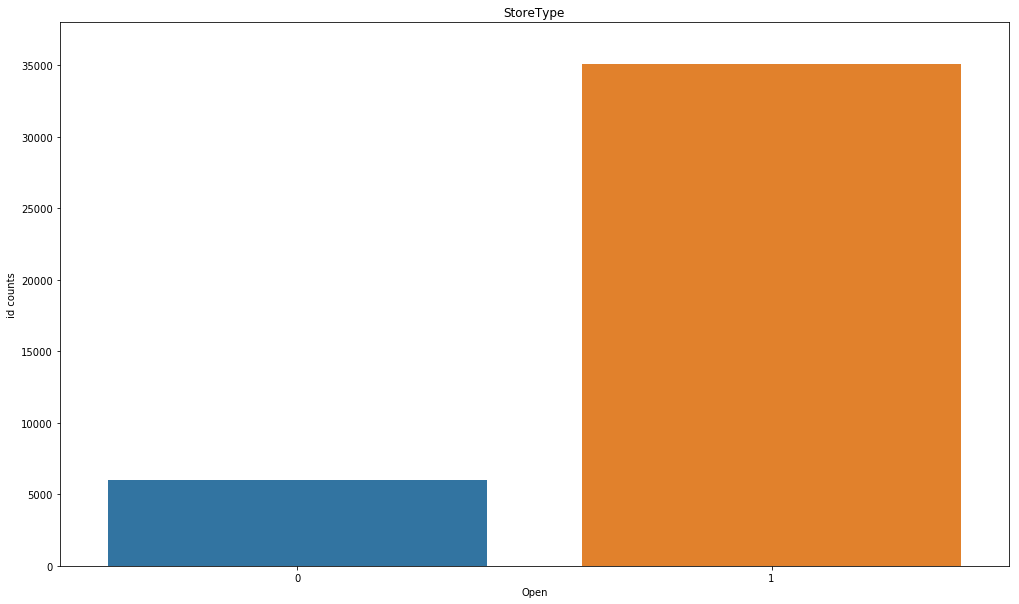

In [10]:
# 对open做可视化
po = test.groupby('Open')['Id'].count()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=38000)  
plt.title('StoreType')  
plt.ylabel('id counts')  
sns.barplot(po.index,po.values)
plt.show()

In [11]:
test.query('Open==0').count()

Id               5984
Store            5984
DayOfWeek        5984
Open             5984
Promo            5984
StateHoliday     5984
SchoolHoliday    5984
Year             5984
Month            5984
Day              5984
WeekOfYear       5984
dtype: int64

#### 整理store数据

In [12]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


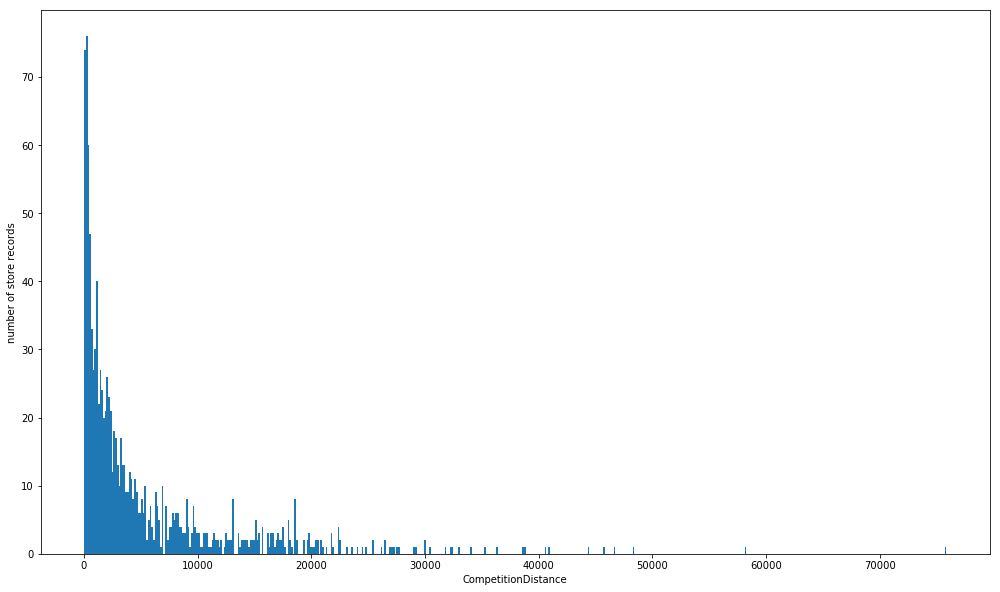

In [14]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.subplots(1,1,figsize=(17,10))  
# plt.plot(store['CompetitionDistance'])
# plt.xlabel('Store')
# plt.ylabel('CompetitionDistance')
# plt.show()
# 对最重要的Sales做可视化
plt.hist(store['CompetitionDistance'].dropna(), bins=500)  
plt.xlabel('CompetitionDistance')  
plt.ylabel('number of store records')  
plt.show()

In [15]:
store.query('CompetitionDistance==0').count()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [16]:
store['CompetitionDistance'].describe()

count    1112.000
mean     5404.901
std      7663.175
min        20.000
25%       717.500
50%      2325.000
75%      6882.500
max     75860.000
Name: CompetitionDistance, dtype: float64

In [17]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [18]:
# 设置距离超过20km的CompetitionOpenSinceYear为2030
store.loc[store['CompetitionDistance']>30000,'CompetitionOpenSinceYear']=2030

In [19]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

349


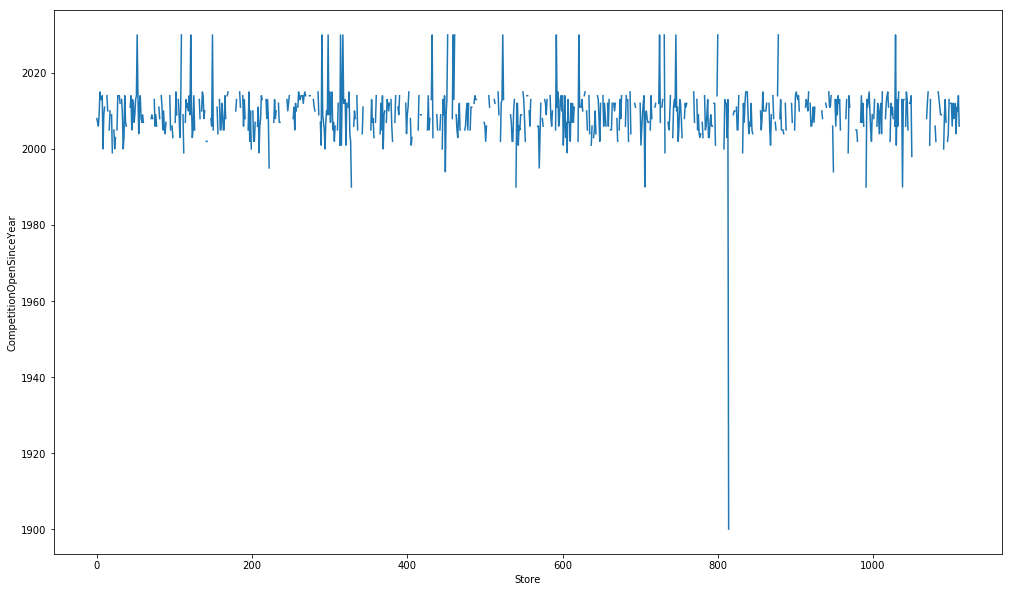

In [20]:
# 可视化CompetitionOpenSinceYear
# store['CompetitionOpenSinceYear'].describe()
plt.subplots(1,1,figsize=(17,10))  
plt.plot(store['CompetitionOpenSinceYear'])
plt.xlabel('Store')
plt.ylabel('CompetitionOpenSinceYear')
plt.show()

In [21]:
store['CompetitionOpenSinceYear'].describe()

count    766.000
mean    2009.242
std        7.115
min     1900.000
25%     2006.000
50%     2010.000
75%     2013.000
max     2030.000
Name: CompetitionOpenSinceYear, dtype: float64

In [22]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [23]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [24]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [25]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [26]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [27]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,2030,"0,0,0,0"
1,2,a,a,570,11,2007,1,13,2010,"0,3,6,9"
2,3,a,a,14130,12,2006,1,14,2011,"0,3,6,9"
3,4,c,c,620,9,2009,0,0,2030,"0,0,0,0"
4,5,a,a,29910,4,2015,0,0,2030,"0,0,0,0"


In [28]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [29]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [30]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1,dtype='int32')
store['PromoInterval2']=pd.Series(PromoInterval2,dtype='int32')
store['PromoInterval3']=pd.Series(PromoInterval3,dtype='int32')
store['PromoInterval4']=pd.Series(PromoInterval4,dtype='int32')
store.drop('PromoInterval',axis=1, inplace=True)

In [31]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [32]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,0,0,0,0,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,0,3,6,9,1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,0,3,6,9,1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,0,0,0,0,0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,0,0,0,0,1,0,0,1,0,0,0


In [33]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval1               1115 non-null int32
PromoInterval2               1115 non-null int32
PromoInterval3               1115 non-null int32
PromoInterval4               1115 non-null int32
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int

#### 整理train数据

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


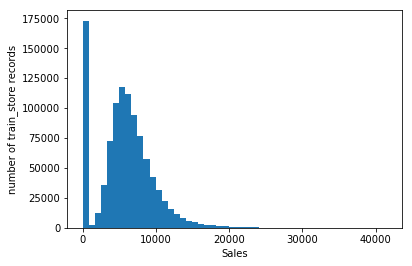

In [35]:
# 对最重要的Sales做可视化
plt.hist(train['Sales'], bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

In [36]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [37]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [38]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [39]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [40]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [41]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [42]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

,Id,Sales
543,544,0
676,677,0
840,841,0
1399,1400,0
1532,1533,0


In [43]:
len(test.query('Open==1'))

35104

In [44]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [45]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 28 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-nu

In [46]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 29 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64

In [47]:
test_data.set_index(['Id'],inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 40909
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-null int32
PromoInterval2               35104 non-nu

#### 数据探索

将CompetitionOpenSinceMonth,CompetitionOpenSinceYear合并为一个特征CompetitionMonths，  
将Promo2SinceWeek Promo2SinceYear PromoInterval合并为一个特征IsPromo2

In [48]:
train_data['CompetitionOpenSinceMonth'].value_counts()    
train_data['Month'].value_counts()

1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: Month, dtype: int64

In [49]:
# 先处理train的
# 计算月份相差
train_data['CompetitionMonths']=(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12+(train_data['Month']-train_data['CompetitionOpenSinceMonth'])


In [50]:
# 如果CompetitionMonths为负数则赋值为0
train_data['CompetitionMonths'].max()
train_data.loc[train_data['CompetitionMonths']==1386,'CompetitionOpenSinceYear']

615236    1900
615237    1900
615238    1900
615239    1900
615240    1900
615241    1900
615242    1900
615243    1900
615244    1900
615245    1900
615246    1900
615247    1900
615248    1900
615249    1900
615250    1900
615251    1900
615252    1900
615253    1900
615254    1900
615255    1900
615256    1900
615257    1900
615258    1900
615259    1900
615260    1900
615261    1900
615262    1900
Name: CompetitionOpenSinceYear, dtype: int32

In [51]:
train_data['CompetitionOpenSinceYear'].value_counts()

2010    304165
2012     60837
2013     58206
2014     52035
2005     46705
2011     41366
2009     40713
2008     37078
2007     36131
2006     35543
2015     28844
2002     19956
2030     17634
2004     16334
2003     13834
2001     12157
2000      7631
1999      6213
1990      3887
1994      1552
1995      1404
1961       779
1998       766
1900       622
Name: CompetitionOpenSinceYear, dtype: int64

In [52]:
train_data.loc[train_data['CompetitionMonths']<0,'CompetitionMonths']=0

In [53]:
# 去掉CompetitionOpenSinceMonth,CompetitionOpenSinceYear
train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [54]:
# 对test_data做同样的操作
test_data['CompetitionMonths']=(test_data['Year']-test_data['CompetitionOpenSinceYear'])*12+(test_data['Month']-test_data['CompetitionOpenSinceMonth'])
test_data.loc[test_data['CompetitionMonths']<0,'CompetitionMonths']=0
test_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [55]:
train_data['Promo2SinceWeek'].value_counts()

0     423307
14     60541
40     51507
31     33238
10     32214
5      29722
37     27116
1      26873
13     24579
45     24072
22     23645
18     22456
35     18888
9      10293
27      7925
36      7620
48      7033
39      3889
23      3558
44      2182
26       782
50       780
28       779
6        771
49       622
Name: Promo2SinceWeek, dtype: int64

In [56]:
# 处理Promo2相关特征
# 先处理train_data
train_data['IsPromo2']=0
train_data.loc[(train_data['Promo2']==1)&((train_data['PromoInterval1']==train_data['Month'])|(train_data['PromoInterval2']==train_data['Month'])|(train_data['PromoInterval3']==train_data['Month'])|(train_data['PromoInterval4']==train_data['Month']))&(((train_data['Promo2SinceYear']==train_data['Year'])&(train_data['Promo2SinceWeek']<=train_data['WeekOfYear']))|train_data['Promo2SinceYear']<train_data['Year']),'IsPromo2']=1

In [57]:
train_data['IsPromo2'].value_counts()

0    718900
1    125492
Name: IsPromo2, dtype: int64

In [58]:
# 计算参加Promo2的时间按周计算，如果Promo2为0就为0
train_data['Promo2weeks']=train_data['Promo2']*((train_data['Year']-train_data['Promo2SinceYear'])*54+(train_data['WeekOfYear']-train_data['Promo2SinceWeek']))

In [59]:
# 如果为负数就设置为0
train_data.loc[train_data['Promo2weeks']<0,'Promo2weeks']=0

In [60]:
train_data['Promo2weeks'].value_counts()

0      481933
100      1820
101      1811
96       1779
105      1768
98       1738
95       1715
99       1709
106      1681
97       1677
102      1674
104      1667
103      1644
108      1619
128      1613
107      1608
129      1601
109      1599
110      1598
111      1589
33       1586
38       1586
41       1584
124      1578
133      1566
131      1561
132      1556
119      1549
187      1543
42       1541
        ...  
289       431
291       430
286       427
308       425
287       425
292       414
297       408
299       407
309       403
305       402
294       398
307       389
293       384
310       379
302       373
301       373
312       258
314       258
317       252
316       251
315       251
313       251
311       251
318       217
323        42
322        42
321        42
320        42
319        42
324        35
Name: Promo2weeks, Length: 325, dtype: int64

In [61]:
# 删除Promo2SinceWeek Promo2SinceYear PromoInterval
train_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [62]:
# 在test_data上也按照这个思路处理Promo2相关特征
test_data['IsPromo2']=0
test_data.loc[(test_data['Promo2']==1)&((test_data['PromoInterval1']==test_data['Month'])|(test_data['PromoInterval2']==test_data['Month'])|(test_data['PromoInterval3']==test_data['Month'])|(test_data['PromoInterval4']==test_data['Month']))&(((test_data['Promo2SinceYear']==test_data['Year'])&(test_data['Promo2SinceWeek']<=test_data['WeekOfYear']))|test_data['Promo2SinceYear']<test_data['Year']),'IsPromo2']=1

In [63]:
test_data['Promo2weeks']=test_data['Promo2']*((test_data['Year']-test_data['Promo2SinceYear'])*54+(test_data['WeekOfYear']-test_data['Promo2SinceWeek']))

In [64]:
test_data.loc[test_data['Promo2weeks']<0,'Promo2weeks']=0

In [65]:
test_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [66]:
# 对StateHoliday做one_hot
# 先对train_data
train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
train_data.drop('StateHoliday',axis=1, inplace=True)

In [67]:
# 再处理test_data
test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
test_data.drop('StateHoliday',axis=1, inplace=True)

In [68]:
print(train_data.columns)
print(test_data.columns)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionDistance', 'Promo2', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'CompetitionMonths', 'IsPromo2', 'Promo2weeks',
       'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'CompetitionMonths', 'IsPromo2',
       'Promo2weeks', 'StateHoliday_0', 'StateHoliday_1'],
      dtype='object')


In [69]:
print(train_data['StateHoliday_2'].value_counts())

0    844247
1       145
Name: StateHoliday_2, dtype: int64


In [70]:
# 补充test_data相对于train_data少的两个特征
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0

#### 建模预测

In [71]:
# Store字段转变为object
# train_data['Store']=train_data['Store'].astype(object)
# test_data['Store']=test_data['Store'].astype(object)

Year
2013    337943
2014    310417
2015    196032
Name: Open, dtype: int64


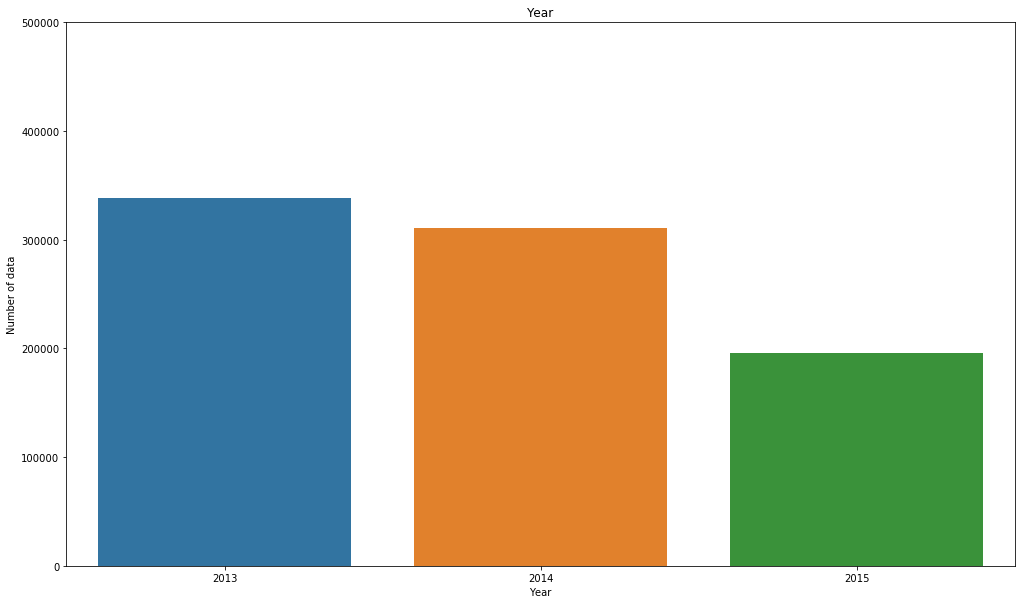

In [72]:
pt = train_data.groupby('Year')['Open'].count()
print(pt)
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=500000)  
plt.title('Year')  
plt.ylabel('Number of data')  
sns.barplot(pt.index,pt.values)
plt.show()
# 2015年数据有236380作为测试数据还是有点多的接下来看看月份数据分布

Month
1    28763
2    26767
3    29080
4    26931
5    25880
6    28423
7    30188
Name: Open, dtype: int64


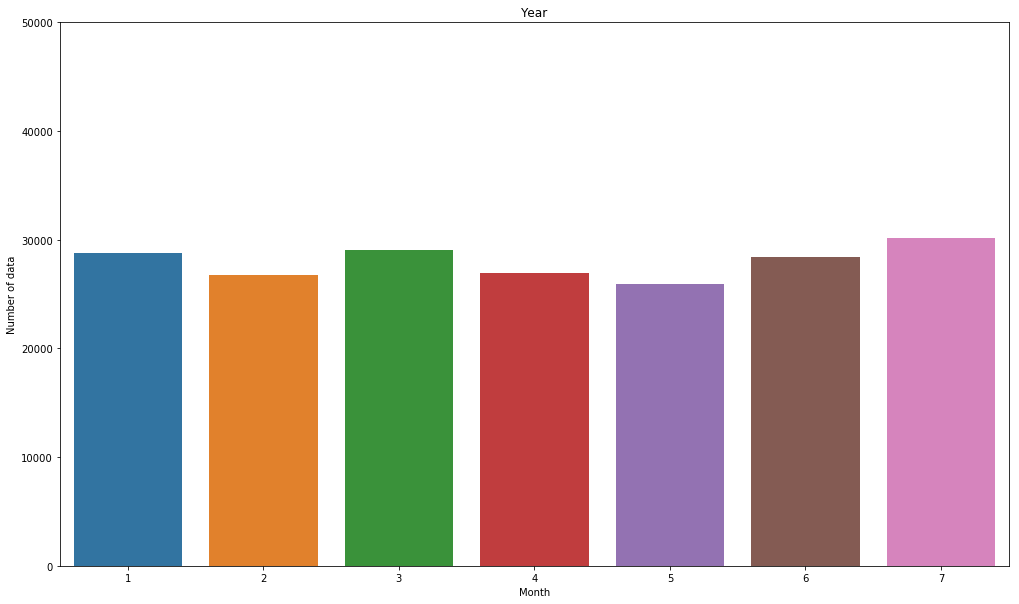

In [76]:
# 展现2015年各个月份的数据
pt = train_data.query('Year==2015').groupby('Month')['Open'].count()
print(pt)
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=50000)  
plt.title('Year')  
plt.ylabel('Number of data')  
sns.barplot(pt.index,pt.values)
plt.show()

In [78]:
# 展现test有哪些月数据
test_data['Year'].value_counts()
test_data['Month'].value_counts()

8    22228
9    12876
Name: Month, dtype: int64

In [90]:
print(train_data.query('Year==2015&(Month==6|Month==7)')['Open'].count()/train_data['Open'].count())
print(train_data.query('Year==2015&(Month==6|Month==7)')['Open'].count()+train_data.query('Year==2013|Year==2014|(Year==2015&(Month!=6&Month!=7))')['Open'].count())
print(train_data['Open'].count())



0.069412074013
844392
844392


In [91]:
# 确认训练特征和比对label
train_a=train_data.query('Year==2015&(Month==6|Month==7)')
X_test=train_a.drop(['Customers','Sales'],axis=1)
y_test=train_a['Sales']
print(len(train_a))
train_b=train_data.query('Year==2013|Year==2014|(Year==2015&(Month!=6&Month!=7))')
X_train=train_b.drop(['Customers','Sales'],axis=1)
y_train=train_b['Sales']
print(len(train_b))

58611
785781


In [92]:
# X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.1, random_state=0)

In [93]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def rmpse_estimator(estimator, X, y):
    yhat = estimator.predict(X)
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

In [94]:
# Ridge模型测试
clf = Ridge(alpha=1)
clf.fit(X_train,np.log1p(y_train))

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [95]:
# 测试Ridge模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.386109


In [96]:
# RidgeCV参数优化
clf = RidgeCV(alphas=[0.1, 0.5, 1.0, 10.0], cv=10, fit_intercept=True,scoring=rmpse_estimator)
starttime = datetime.datetime.now()
clf.fit(X_train,np.log1p(y_train))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef_：', clf.coef_)


0:00:35.528326
alpha:  0.1
coef_： [  4.43763546e-06  -2.04184019e-02   0.00000000e+00   3.21997392e-01
   1.74179109e-02   2.84862777e-02   8.08994134e-03  -6.07167786e-04
   4.49570919e-04  -3.19488147e-06  -1.30857367e-01   5.26310085e-02
  -2.21419866e-01   1.68788003e-01  -1.39052733e-01   4.07917972e-01
  -1.35773370e-01  -1.33091063e-01  -6.64623223e-06  -8.17304112e-03
   2.94838368e-04   6.12177962e-02  -5.10005108e-02  -6.70587844e-02
   5.68414967e-02]


In [97]:
# 测试RidgeCV模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.386109


In [98]:
# Ridge结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("ridge_submission.csv", index=False)

0:00:00.015041
41088


Kaggle进行评分是0.41700

In [99]:
# Lasso模型测试
clf = Lasso(alpha=3.0)
clf.fit(X_train,np.log1p(y_train))

Lasso(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [100]:
# 测试Lasso模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.506905


In [101]:
# LassoCV参数优化
clf = LassoCV(cv=20)
starttime = datetime.datetime.now()
clf.fit(X_train,np.log1p(y_train))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef：', clf.coef_)

0:00:23.330385
alpha:  0.170227898896
coef： [ -0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.03112685e-04
   1.33619316e-03  -2.15431475e-06  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -2.26496024e-04  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


In [102]:
# 测试LassoCV模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.505639


In [103]:
# Lasso结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("lasso_submission.csv", index=False)

0:00:00.011531
41088


Kaggle进行评分是0.43365

In [104]:
print(X_train.info())
print(X_test.info())
print(y_train.describe())
print(y_test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785781 entries, 52 to 844391
Data columns (total 25 columns):
Store                  785781 non-null int64
DayOfWeek              785781 non-null int64
Open                   785781 non-null int64
Promo                  785781 non-null int64
SchoolHoliday          785781 non-null int64
Year                   785781 non-null int64
Month                  785781 non-null int64
Day                    785781 non-null int64
WeekOfYear             785781 non-null int64
CompetitionDistance    785781 non-null int32
Promo2                 785781 non-null int64
Assortment_1           785781 non-null uint8
Assortment_2           785781 non-null uint8
Assortment_3           785781 non-null uint8
StoreType_1            785781 non-null uint8
StoreType_2            785781 non-null uint8
StoreType_3            785781 non-null uint8
StoreType_4            785781 non-null uint8
CompetitionMonths      785781 non-null int64
IsPromo2               785781 non

In [105]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

初次提交是0.13768，经过多次尝试目前使用这套参数的kaggle提交分数是0.12256

In [106]:
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:7.85364	eval-rmse:7.88869	train-rmspe:0.999708	eval-rmspe:0.999753
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.46197	eval-rmse:7.49656	train-rmspe:0.999503	eval-rmspe:0.999555
[2]	train-rmse:7.08985	eval-rmse:7.12361	train-rmspe:0.999218	eval-rmspe:0.999281
[3]	train-rmse:6.73624	eval-rmse:6.76993	train-rmspe:0.998832	eval-rmspe:0.998909
[4]	train-rmse:6.40036	eval-rmse:6.4344	train-rmspe:0.998315	eval-rmspe:0.998412
[5]	train-rmse:6.08135	eval-rmse:6.11586	train-rmspe:0.997634	eval-rmspe:0.997759
[6]	train-rmse:5.77832	eval-rmse:5.81288	train-rmspe:0.996754	eval-rmspe:0.996912
[7]	train-rmse:5.49046	eval-rmse:5.52467	train-rmspe:0.995633	eval-rmspe:0.995834
[8]	train-rmse:5.217	eval-rmse:5.25084	train-rmspe:0.994229	eval-rmspe:0.994481
[9]	train-rmse:4.95739	eval-rmse:4.99062	train-rmspe:0.992484	eval-rmspe:0.992798
[10]	train-rmse:4.71069	eval-rmse:4.7

[97]	train-rmse:0.248778	eval-rmse:0.251913	train-rmspe:0.273818	eval-rmspe:0.250901
[98]	train-rmse:0.247807	eval-rmse:0.25104	train-rmspe:0.273954	eval-rmspe:0.251024
[99]	train-rmse:0.246955	eval-rmse:0.250283	train-rmspe:0.274217	eval-rmspe:0.251231
[100]	train-rmse:0.246113	eval-rmse:0.249569	train-rmspe:0.274131	eval-rmspe:0.251245
[101]	train-rmse:0.245108	eval-rmse:0.248657	train-rmspe:0.274044	eval-rmspe:0.251112
[102]	train-rmse:0.24314	eval-rmse:0.246747	train-rmspe:0.272812	eval-rmspe:0.2497
[103]	train-rmse:0.24192	eval-rmse:0.245607	train-rmspe:0.272439	eval-rmspe:0.249229
[104]	train-rmse:0.240797	eval-rmse:0.244557	train-rmspe:0.271705	eval-rmspe:0.248967
[105]	train-rmse:0.240179	eval-rmse:0.244069	train-rmspe:0.271875	eval-rmspe:0.249158
[106]	train-rmse:0.239419	eval-rmse:0.243481	train-rmspe:0.271824	eval-rmspe:0.249204
[107]	train-rmse:0.238882	eval-rmse:0.243021	train-rmspe:0.271861	eval-rmspe:0.249317
[108]	train-rmse:0.237982	eval-rmse:0.242379	train-rmspe:0.271

[193]	train-rmse:0.18203	eval-rmse:0.196235	train-rmspe:0.222935	eval-rmspe:0.210779
[194]	train-rmse:0.180942	eval-rmse:0.195358	train-rmspe:0.221943	eval-rmspe:0.209871
[195]	train-rmse:0.180507	eval-rmse:0.1951	train-rmspe:0.221585	eval-rmspe:0.209586
[196]	train-rmse:0.180105	eval-rmse:0.194753	train-rmspe:0.221192	eval-rmspe:0.209226
[197]	train-rmse:0.179914	eval-rmse:0.1946	train-rmspe:0.221067	eval-rmspe:0.209065
[198]	train-rmse:0.178936	eval-rmse:0.193731	train-rmspe:0.219826	eval-rmspe:0.20811
[199]	train-rmse:0.178391	eval-rmse:0.193439	train-rmspe:0.219145	eval-rmspe:0.207765
[200]	train-rmse:0.17765	eval-rmse:0.192818	train-rmspe:0.21853	eval-rmspe:0.207127
[201]	train-rmse:0.177396	eval-rmse:0.19265	train-rmspe:0.218348	eval-rmspe:0.206947
[202]	train-rmse:0.176765	eval-rmse:0.192148	train-rmspe:0.21778	eval-rmspe:0.206416
[203]	train-rmse:0.176433	eval-rmse:0.192099	train-rmspe:0.217316	eval-rmspe:0.206433
[204]	train-rmse:0.175726	eval-rmse:0.191515	train-rmspe:0.21658

[289]	train-rmse:0.149739	eval-rmse:0.170633	train-rmspe:0.187577	eval-rmspe:0.182988
[290]	train-rmse:0.149459	eval-rmse:0.170377	train-rmspe:0.187283	eval-rmspe:0.182746
[291]	train-rmse:0.149163	eval-rmse:0.170524	train-rmspe:0.187058	eval-rmspe:0.182555
[292]	train-rmse:0.148778	eval-rmse:0.170104	train-rmspe:0.186706	eval-rmspe:0.182085
[293]	train-rmse:0.1487	eval-rmse:0.170035	train-rmspe:0.185962	eval-rmspe:0.182012
[294]	train-rmse:0.148455	eval-rmse:0.169817	train-rmspe:0.185768	eval-rmspe:0.181774
[295]	train-rmse:0.148151	eval-rmse:0.169579	train-rmspe:0.185466	eval-rmspe:0.181514
[296]	train-rmse:0.148034	eval-rmse:0.169692	train-rmspe:0.185358	eval-rmspe:0.18176
[297]	train-rmse:0.147947	eval-rmse:0.169729	train-rmspe:0.185251	eval-rmspe:0.181816
[298]	train-rmse:0.147798	eval-rmse:0.169626	train-rmspe:0.185134	eval-rmspe:0.181711
[299]	train-rmse:0.147469	eval-rmse:0.16932	train-rmspe:0.184856	eval-rmspe:0.181347
[300]	train-rmse:0.146945	eval-rmse:0.168911	train-rmspe:0

[385]	train-rmse:0.13095	eval-rmse:0.158037	train-rmspe:0.170611	eval-rmspe:0.16805
[386]	train-rmse:0.130778	eval-rmse:0.158076	train-rmspe:0.170511	eval-rmspe:0.167972
[387]	train-rmse:0.130526	eval-rmse:0.157859	train-rmspe:0.170198	eval-rmspe:0.16774
[388]	train-rmse:0.130272	eval-rmse:0.15765	train-rmspe:0.170009	eval-rmspe:0.167484
[389]	train-rmse:0.130069	eval-rmse:0.157484	train-rmspe:0.169859	eval-rmspe:0.16731
[390]	train-rmse:0.129988	eval-rmse:0.157404	train-rmspe:0.169791	eval-rmspe:0.167226
[391]	train-rmse:0.129936	eval-rmse:0.157365	train-rmspe:0.169757	eval-rmspe:0.167194
[392]	train-rmse:0.129831	eval-rmse:0.157269	train-rmspe:0.169674	eval-rmspe:0.167092
[393]	train-rmse:0.12971	eval-rmse:0.157203	train-rmspe:0.16936	eval-rmspe:0.166991
[394]	train-rmse:0.129489	eval-rmse:0.157009	train-rmspe:0.169192	eval-rmspe:0.16679
[395]	train-rmse:0.129256	eval-rmse:0.156797	train-rmspe:0.168994	eval-rmspe:0.166519
[396]	train-rmse:0.129119	eval-rmse:0.156706	train-rmspe:0.168

[481]	train-rmse:0.119351	eval-rmse:0.152086	train-rmspe:0.147334	eval-rmspe:0.159888
[482]	train-rmse:0.119256	eval-rmse:0.152016	train-rmspe:0.14726	eval-rmspe:0.159823
[483]	train-rmse:0.119123	eval-rmse:0.151909	train-rmspe:0.147165	eval-rmspe:0.159695
[484]	train-rmse:0.119008	eval-rmse:0.151828	train-rmspe:0.147031	eval-rmspe:0.159597
[485]	train-rmse:0.118954	eval-rmse:0.151807	train-rmspe:0.146969	eval-rmspe:0.159577
[486]	train-rmse:0.118844	eval-rmse:0.151749	train-rmspe:0.146875	eval-rmspe:0.159514
[487]	train-rmse:0.118775	eval-rmse:0.151678	train-rmspe:0.146823	eval-rmspe:0.159443
[488]	train-rmse:0.118731	eval-rmse:0.151658	train-rmspe:0.146799	eval-rmspe:0.159418
[489]	train-rmse:0.118602	eval-rmse:0.151555	train-rmspe:0.146709	eval-rmspe:0.1593
[490]	train-rmse:0.118461	eval-rmse:0.151475	train-rmspe:0.146619	eval-rmspe:0.15922
[491]	train-rmse:0.118306	eval-rmse:0.151419	train-rmspe:0.14647	eval-rmspe:0.159131
[492]	train-rmse:0.11815	eval-rmse:0.151314	train-rmspe:0.1

[577]	train-rmse:0.110598	eval-rmse:0.147256	train-rmspe:0.133647	eval-rmspe:0.154356
[578]	train-rmse:0.11053	eval-rmse:0.147217	train-rmspe:0.133587	eval-rmspe:0.154315
[579]	train-rmse:0.110355	eval-rmse:0.147107	train-rmspe:0.133429	eval-rmspe:0.154179
[580]	train-rmse:0.110317	eval-rmse:0.1471	train-rmspe:0.132921	eval-rmspe:0.154169
[581]	train-rmse:0.110222	eval-rmse:0.147063	train-rmspe:0.132767	eval-rmspe:0.154125
[582]	train-rmse:0.110131	eval-rmse:0.147006	train-rmspe:0.132661	eval-rmspe:0.154064
[583]	train-rmse:0.110073	eval-rmse:0.146963	train-rmspe:0.132616	eval-rmspe:0.154031
[584]	train-rmse:0.109964	eval-rmse:0.146933	train-rmspe:0.132538	eval-rmspe:0.154001
[585]	train-rmse:0.109931	eval-rmse:0.146919	train-rmspe:0.132506	eval-rmspe:0.153986
[586]	train-rmse:0.109848	eval-rmse:0.146876	train-rmspe:0.132452	eval-rmspe:0.15394
[587]	train-rmse:0.10978	eval-rmse:0.146907	train-rmspe:0.132407	eval-rmspe:0.153952
[588]	train-rmse:0.109751	eval-rmse:0.146884	train-rmspe:0.

[673]	train-rmse:0.104064	eval-rmse:0.144904	train-rmspe:0.126946	eval-rmspe:0.151498
[674]	train-rmse:0.104	eval-rmse:0.14486	train-rmspe:0.126896	eval-rmspe:0.151447
[675]	train-rmse:0.103926	eval-rmse:0.144992	train-rmspe:0.126838	eval-rmspe:0.151618
[676]	train-rmse:0.103839	eval-rmse:0.144943	train-rmspe:0.126765	eval-rmspe:0.15156
[677]	train-rmse:0.103818	eval-rmse:0.144946	train-rmspe:0.126745	eval-rmspe:0.151567
[678]	train-rmse:0.103761	eval-rmse:0.144909	train-rmspe:0.126703	eval-rmspe:0.151524
[679]	train-rmse:0.103732	eval-rmse:0.145061	train-rmspe:0.126688	eval-rmspe:0.151519
[680]	train-rmse:0.103699	eval-rmse:0.145031	train-rmspe:0.126656	eval-rmspe:0.151479
[681]	train-rmse:0.103633	eval-rmse:0.144981	train-rmspe:0.126579	eval-rmspe:0.151424
[682]	train-rmse:0.103545	eval-rmse:0.144936	train-rmspe:0.126502	eval-rmspe:0.151372
[683]	train-rmse:0.103483	eval-rmse:0.14491	train-rmspe:0.126438	eval-rmspe:0.151339
[684]	train-rmse:0.103424	eval-rmse:0.144895	train-rmspe:0.1

[769]	train-rmse:0.098748	eval-rmse:0.143623	train-rmspe:0.121611	eval-rmspe:0.149462
[770]	train-rmse:0.09873	eval-rmse:0.143623	train-rmspe:0.121597	eval-rmspe:0.149458
[771]	train-rmse:0.098691	eval-rmse:0.14362	train-rmspe:0.121531	eval-rmspe:0.149453
[772]	train-rmse:0.098647	eval-rmse:0.143605	train-rmspe:0.121499	eval-rmspe:0.149437
[773]	train-rmse:0.098632	eval-rmse:0.143594	train-rmspe:0.121487	eval-rmspe:0.149429
[774]	train-rmse:0.098556	eval-rmse:0.143637	train-rmspe:0.121373	eval-rmspe:0.149525
[775]	train-rmse:0.098489	eval-rmse:0.143754	train-rmspe:0.121332	eval-rmspe:0.149497
[776]	train-rmse:0.098401	eval-rmse:0.143762	train-rmspe:0.121069	eval-rmspe:0.149503
[777]	train-rmse:0.098368	eval-rmse:0.143759	train-rmspe:0.121059	eval-rmspe:0.149507
[778]	train-rmse:0.098318	eval-rmse:0.143775	train-rmspe:0.121035	eval-rmspe:0.149492
[779]	train-rmse:0.098256	eval-rmse:0.143758	train-rmspe:0.120995	eval-rmspe:0.149458
[780]	train-rmse:0.098209	eval-rmse:0.143731	train-rmspe

[865]	train-rmse:0.094543	eval-rmse:0.14343	train-rmspe:0.1166	eval-rmspe:0.148745
[866]	train-rmse:0.094482	eval-rmse:0.143391	train-rmspe:0.116521	eval-rmspe:0.148696
[867]	train-rmse:0.094434	eval-rmse:0.143369	train-rmspe:0.116475	eval-rmspe:0.148671
[868]	train-rmse:0.094397	eval-rmse:0.143371	train-rmspe:0.116459	eval-rmspe:0.148665
[869]	train-rmse:0.094335	eval-rmse:0.143772	train-rmspe:0.116432	eval-rmspe:0.148677
[870]	train-rmse:0.094275	eval-rmse:0.143752	train-rmspe:0.116403	eval-rmspe:0.148661
[871]	train-rmse:0.09422	eval-rmse:0.143688	train-rmspe:0.116375	eval-rmspe:0.148588
[872]	train-rmse:0.09416	eval-rmse:0.143667	train-rmspe:0.116331	eval-rmspe:0.148562
[873]	train-rmse:0.094145	eval-rmse:0.143673	train-rmspe:0.116317	eval-rmspe:0.148583
[874]	train-rmse:0.094114	eval-rmse:0.143656	train-rmspe:0.116348	eval-rmspe:0.14856
[875]	train-rmse:0.094064	eval-rmse:0.143682	train-rmspe:0.116307	eval-rmspe:0.148553
[876]	train-rmse:0.093988	eval-rmse:0.143682	train-rmspe:0.1

[961]	train-rmse:0.091108	eval-rmse:0.143516	train-rmspe:0.112615	eval-rmspe:0.14799
[962]	train-rmse:0.091082	eval-rmse:0.1435	train-rmspe:0.112595	eval-rmspe:0.147971
[963]	train-rmse:0.091035	eval-rmse:0.143551	train-rmspe:0.112571	eval-rmspe:0.147971
[964]	train-rmse:0.091005	eval-rmse:0.143613	train-rmspe:0.112551	eval-rmspe:0.147989
[965]	train-rmse:0.090966	eval-rmse:0.143663	train-rmspe:0.112518	eval-rmspe:0.148003
[966]	train-rmse:0.09094	eval-rmse:0.143659	train-rmspe:0.112495	eval-rmspe:0.147995
[967]	train-rmse:0.090917	eval-rmse:0.143648	train-rmspe:0.112486	eval-rmspe:0.147983
[968]	train-rmse:0.090907	eval-rmse:0.143683	train-rmspe:0.112463	eval-rmspe:0.14798
[969]	train-rmse:0.090873	eval-rmse:0.143679	train-rmspe:0.112444	eval-rmspe:0.147977
[970]	train-rmse:0.090839	eval-rmse:0.143671	train-rmspe:0.112418	eval-rmspe:0.147958
[971]	train-rmse:0.090817	eval-rmse:0.143665	train-rmspe:0.112398	eval-rmspe:0.147946
[972]	train-rmse:0.090802	eval-rmse:0.143662	train-rmspe:0.

[1057]	train-rmse:0.088215	eval-rmse:0.143964	train-rmspe:0.108352	eval-rmspe:0.147415
[1058]	train-rmse:0.088193	eval-rmse:0.143958	train-rmspe:0.108328	eval-rmspe:0.147404
[1059]	train-rmse:0.088142	eval-rmse:0.143965	train-rmspe:0.108296	eval-rmspe:0.147405
[1060]	train-rmse:0.088112	eval-rmse:0.143968	train-rmspe:0.108263	eval-rmspe:0.147414
[1061]	train-rmse:0.088058	eval-rmse:0.143967	train-rmspe:0.10798	eval-rmspe:0.147399
[1062]	train-rmse:0.088034	eval-rmse:0.143958	train-rmspe:0.107967	eval-rmspe:0.147388
[1063]	train-rmse:0.088009	eval-rmse:0.143947	train-rmspe:0.107963	eval-rmspe:0.147377
[1064]	train-rmse:0.087994	eval-rmse:0.143946	train-rmspe:0.107947	eval-rmspe:0.147375
[1065]	train-rmse:0.087955	eval-rmse:0.143943	train-rmspe:0.107918	eval-rmspe:0.147372
[1066]	train-rmse:0.087923	eval-rmse:0.143952	train-rmspe:0.107896	eval-rmspe:0.147403
[1067]	train-rmse:0.087901	eval-rmse:0.14398	train-rmspe:0.107877	eval-rmspe:0.147407
[1068]	train-rmse:0.087868	eval-rmse:0.143985

[1152]	train-rmse:0.08577	eval-rmse:0.144012	train-rmspe:0.103971	eval-rmspe:0.147113
[1153]	train-rmse:0.085714	eval-rmse:0.143993	train-rmspe:0.103943	eval-rmspe:0.147089
[1154]	train-rmse:0.085687	eval-rmse:0.143999	train-rmspe:0.103903	eval-rmspe:0.147087
[1155]	train-rmse:0.085662	eval-rmse:0.144008	train-rmspe:0.103844	eval-rmspe:0.147099
[1156]	train-rmse:0.085654	eval-rmse:0.144006	train-rmspe:0.103838	eval-rmspe:0.147098
[1157]	train-rmse:0.085635	eval-rmse:0.144006	train-rmspe:0.103826	eval-rmspe:0.147101
[1158]	train-rmse:0.085614	eval-rmse:0.144002	train-rmspe:0.103738	eval-rmspe:0.147096
[1159]	train-rmse:0.085591	eval-rmse:0.143988	train-rmspe:0.103713	eval-rmspe:0.14708
[1160]	train-rmse:0.085561	eval-rmse:0.143984	train-rmspe:0.103668	eval-rmspe:0.147074
[1161]	train-rmse:0.085538	eval-rmse:0.144024	train-rmspe:0.103634	eval-rmspe:0.147125
[1162]	train-rmse:0.085525	eval-rmse:0.14402	train-rmspe:0.103623	eval-rmspe:0.147122
[1163]	train-rmse:0.085493	eval-rmse:0.144028	

[1247]	train-rmse:0.08354	eval-rmse:0.143765	train-rmspe:0.097233	eval-rmspe:0.146932
[1248]	train-rmse:0.083526	eval-rmse:0.143762	train-rmspe:0.097198	eval-rmspe:0.14693
[1249]	train-rmse:0.08351	eval-rmse:0.143759	train-rmspe:0.097187	eval-rmspe:0.146925
[1250]	train-rmse:0.083478	eval-rmse:0.14375	train-rmspe:0.097168	eval-rmspe:0.146916
[1251]	train-rmse:0.083463	eval-rmse:0.143749	train-rmspe:0.097078	eval-rmspe:0.146914
[1252]	train-rmse:0.083442	eval-rmse:0.14374	train-rmspe:0.09707	eval-rmspe:0.146901
[1253]	train-rmse:0.083424	eval-rmse:0.143736	train-rmspe:0.09706	eval-rmspe:0.146896
[1254]	train-rmse:0.083415	eval-rmse:0.143744	train-rmspe:0.097035	eval-rmspe:0.146897
[1255]	train-rmse:0.083395	eval-rmse:0.143732	train-rmspe:0.097014	eval-rmspe:0.146882
[1256]	train-rmse:0.083353	eval-rmse:0.143724	train-rmspe:0.096971	eval-rmspe:0.146874
[1257]	train-rmse:0.083329	eval-rmse:0.14378	train-rmspe:0.096954	eval-rmspe:0.146871
[1258]	train-rmse:0.083299	eval-rmse:0.143773	train

[1342]	train-rmse:0.081552	eval-rmse:0.14372	train-rmspe:0.092927	eval-rmspe:0.146676
[1343]	train-rmse:0.081538	eval-rmse:0.143721	train-rmspe:0.092899	eval-rmspe:0.146681
[1344]	train-rmse:0.081523	eval-rmse:0.143718	train-rmspe:0.092884	eval-rmspe:0.146675
[1345]	train-rmse:0.081497	eval-rmse:0.143715	train-rmspe:0.092868	eval-rmspe:0.146675
[1346]	train-rmse:0.081466	eval-rmse:0.143704	train-rmspe:0.092855	eval-rmspe:0.146655
[1347]	train-rmse:0.081452	eval-rmse:0.143698	train-rmspe:0.09284	eval-rmspe:0.146649
[1348]	train-rmse:0.081436	eval-rmse:0.143716	train-rmspe:0.09283	eval-rmspe:0.146679
[1349]	train-rmse:0.081427	eval-rmse:0.143716	train-rmspe:0.092907	eval-rmspe:0.146679
[1350]	train-rmse:0.081384	eval-rmse:0.143717	train-rmspe:0.092284	eval-rmspe:0.14668
[1351]	train-rmse:0.081345	eval-rmse:0.143711	train-rmspe:0.092255	eval-rmspe:0.146673
[1352]	train-rmse:0.081317	eval-rmse:0.143711	train-rmspe:0.092233	eval-rmspe:0.146674
[1353]	train-rmse:0.081313	eval-rmse:0.143713	t

[1437]	train-rmse:0.079644	eval-rmse:0.143551	train-rmspe:0.08788	eval-rmspe:0.146408
[1438]	train-rmse:0.079637	eval-rmse:0.143548	train-rmspe:0.087874	eval-rmspe:0.146406
[1439]	train-rmse:0.079614	eval-rmse:0.143542	train-rmspe:0.087857	eval-rmspe:0.146399
[1440]	train-rmse:0.079596	eval-rmse:0.143539	train-rmspe:0.087841	eval-rmspe:0.146397
[1441]	train-rmse:0.079575	eval-rmse:0.143536	train-rmspe:0.087819	eval-rmspe:0.146394
[1442]	train-rmse:0.079554	eval-rmse:0.143532	train-rmspe:0.087778	eval-rmspe:0.14639
[1443]	train-rmse:0.079527	eval-rmse:0.143535	train-rmspe:0.087758	eval-rmspe:0.146396
[1444]	train-rmse:0.07952	eval-rmse:0.143534	train-rmspe:0.087751	eval-rmspe:0.146396
[1445]	train-rmse:0.079511	eval-rmse:0.143534	train-rmspe:0.087742	eval-rmspe:0.146396
[1446]	train-rmse:0.079499	eval-rmse:0.143528	train-rmspe:0.08773	eval-rmspe:0.146389
[1447]	train-rmse:0.079483	eval-rmse:0.143527	train-rmspe:0.087654	eval-rmspe:0.146387
[1448]	train-rmse:0.079445	eval-rmse:0.143535	t

[1532]	train-rmse:0.077879	eval-rmse:0.143609	train-rmspe:0.085445	eval-rmspe:0.146311
[1533]	train-rmse:0.077863	eval-rmse:0.143605	train-rmspe:0.085407	eval-rmspe:0.146308
[1534]	train-rmse:0.07784	eval-rmse:0.143624	train-rmspe:0.085388	eval-rmspe:0.146325
[1535]	train-rmse:0.077827	eval-rmse:0.143621	train-rmspe:0.085367	eval-rmspe:0.146322
[1536]	train-rmse:0.077801	eval-rmse:0.143629	train-rmspe:0.085334	eval-rmspe:0.14634
[1537]	train-rmse:0.077789	eval-rmse:0.143625	train-rmspe:0.085328	eval-rmspe:0.146336
[1538]	train-rmse:0.077776	eval-rmse:0.14362	train-rmspe:0.085314	eval-rmspe:0.146329
[1539]	train-rmse:0.077761	eval-rmse:0.14362	train-rmspe:0.08529	eval-rmspe:0.146326
[1540]	train-rmse:0.077742	eval-rmse:0.143617	train-rmspe:0.08526	eval-rmspe:0.146323
[1541]	train-rmse:0.077717	eval-rmse:0.143598	train-rmspe:0.085238	eval-rmspe:0.146303
[1542]	train-rmse:0.077691	eval-rmse:0.143624	train-rmspe:0.085226	eval-rmspe:0.146337
[1543]	train-rmse:0.07767	eval-rmse:0.143619	trai

[1627]	train-rmse:0.076319	eval-rmse:0.143527	train-rmspe:0.082868	eval-rmspe:0.146239
[1628]	train-rmse:0.076308	eval-rmse:0.143522	train-rmspe:0.082856	eval-rmspe:0.146233
[1629]	train-rmse:0.076284	eval-rmse:0.143524	train-rmspe:0.082779	eval-rmspe:0.146233
[1630]	train-rmse:0.076273	eval-rmse:0.143524	train-rmspe:0.082765	eval-rmspe:0.146231
[1631]	train-rmse:0.076245	eval-rmse:0.143519	train-rmspe:0.082752	eval-rmspe:0.146236
[1632]	train-rmse:0.076223	eval-rmse:0.143518	train-rmspe:0.082741	eval-rmspe:0.146233
[1633]	train-rmse:0.076213	eval-rmse:0.143513	train-rmspe:0.08273	eval-rmspe:0.146223
[1634]	train-rmse:0.076192	eval-rmse:0.143513	train-rmspe:0.082698	eval-rmspe:0.146222
[1635]	train-rmse:0.07615	eval-rmse:0.14359	train-rmspe:0.082681	eval-rmspe:0.146289
[1636]	train-rmse:0.076137	eval-rmse:0.143595	train-rmspe:0.082664	eval-rmspe:0.146291
[1637]	train-rmse:0.076134	eval-rmse:0.143594	train-rmspe:0.082661	eval-rmspe:0.146289
[1638]	train-rmse:0.076117	eval-rmse:0.143596	

In [107]:
# 测试XGBoost模型结果
dtest = xgb.DMatrix(X_test)
yhat = gbm.predict(dtest)
error = rmspe(y_test, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.331762


In [108]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = gbm.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission.csv", index=False)

0:00:01.317099
41088


kaggle进行评分0.12074

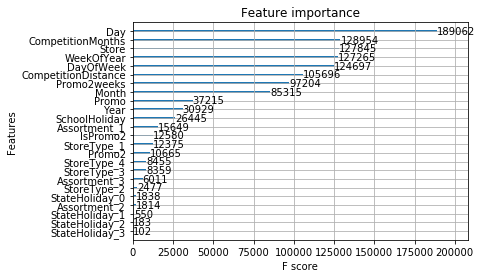

In [130]:
xgb.plot_importance(gbm)
plt.show()

In [131]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

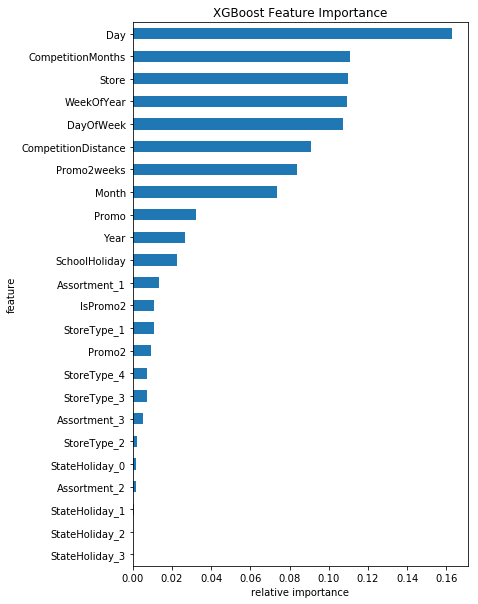

In [132]:
create_feature_map(X_train.columns)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

#### 模型及参数优化

In [133]:
# 提升树的数量
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 20000

In [134]:
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:8.21979	eval-rmse:8.25168	train-rmspe:0.999836	eval-rmspe:0.999872
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.17877	eval-rmse:8.2107	train-rmspe:0.999823	eval-rmspe:0.99986
[2]	train-rmse:8.13796	eval-rmse:8.16981	train-rmspe:0.99981	eval-rmspe:0.999848
[3]	train-rmse:8.09736	eval-rmse:8.1293	train-rmspe:0.999797	eval-rmspe:0.999835
[4]	train-rmse:8.05696	eval-rmse:8.08897	train-rmspe:0.999783	eval-rmspe:0.999822
[5]	train-rmse:8.01676	eval-rmse:8.04881	train-rmspe:0.999769	eval-rmspe:0.999808
[6]	train-rmse:7.97676	eval-rmse:8.00883	train-rmspe:0.999754	eval-rmspe:0.999794
[7]	train-rmse:7.93697	eval-rmse:7.9691	train-rmspe:0.999739	eval-rmspe:0.999779
[8]	train-rmse:7.89737	eval-rmse:7.92954	train-rmspe:0.999723	eval-rmspe:0.999764
[9]	train-rmse:7.85797	eval-rmse:7.89014	train-rmspe:0.999706	eval-rmspe:0.999748
[10]	train-rmse:7.81878	eval-rmse:7.850

[98]	train-rmse:5.03751	eval-rmse:5.07151	train-rmspe:0.993061	eval-rmspe:0.993363
[99]	train-rmse:5.01244	eval-rmse:5.04641	train-rmspe:0.992883	eval-rmspe:0.993192
[100]	train-rmse:4.9875	eval-rmse:5.02145	train-rmspe:0.9927	eval-rmspe:0.993016
[101]	train-rmse:4.96268	eval-rmse:4.99664	train-rmspe:0.992515	eval-rmspe:0.992838
[102]	train-rmse:4.93799	eval-rmse:4.97204	train-rmspe:0.992325	eval-rmspe:0.992656
[103]	train-rmse:4.91342	eval-rmse:4.94749	train-rmspe:0.992132	eval-rmspe:0.992471
[104]	train-rmse:4.88897	eval-rmse:4.92307	train-rmspe:0.991936	eval-rmspe:0.992282
[105]	train-rmse:4.86466	eval-rmse:4.89875	train-rmspe:0.991735	eval-rmspe:0.992089
[106]	train-rmse:4.84047	eval-rmse:4.87458	train-rmspe:0.99153	eval-rmspe:0.991892
[107]	train-rmse:4.81639	eval-rmse:4.85051	train-rmspe:0.991321	eval-rmspe:0.991691
[108]	train-rmse:4.79243	eval-rmse:4.82653	train-rmspe:0.991109	eval-rmspe:0.991487
[109]	train-rmse:4.76859	eval-rmse:4.80265	train-rmspe:0.990892	eval-rmspe:0.99127

[197]	train-rmse:3.0784	eval-rmse:3.11246	train-rmspe:0.950503	eval-rmspe:0.952387
[198]	train-rmse:3.06318	eval-rmse:3.09725	train-rmspe:0.949747	eval-rmspe:0.951658
[199]	train-rmse:3.04804	eval-rmse:3.08211	train-rmspe:0.948983	eval-rmspe:0.950922
[200]	train-rmse:3.03298	eval-rmse:3.06704	train-rmspe:0.948211	eval-rmspe:0.950178
[201]	train-rmse:3.01798	eval-rmse:3.05207	train-rmspe:0.947433	eval-rmspe:0.949429
[202]	train-rmse:3.00306	eval-rmse:3.0371	train-rmspe:0.946648	eval-rmspe:0.94867
[203]	train-rmse:2.98823	eval-rmse:3.0223	train-rmspe:0.945852	eval-rmspe:0.947904
[204]	train-rmse:2.97345	eval-rmse:3.00749	train-rmspe:0.945051	eval-rmspe:0.94713
[205]	train-rmse:2.95876	eval-rmse:2.99283	train-rmspe:0.944241	eval-rmspe:0.94635
[206]	train-rmse:2.94414	eval-rmse:2.97821	train-rmspe:0.943423	eval-rmspe:0.945561
[207]	train-rmse:2.92961	eval-rmse:2.9636	train-rmspe:0.942597	eval-rmspe:0.94476
[208]	train-rmse:2.91515	eval-rmse:2.94915	train-rmspe:0.941762	eval-rmspe:0.943956


[296]	train-rmse:1.89085	eval-rmse:1.92395	train-rmspe:0.838836	eval-rmspe:0.844322
[297]	train-rmse:1.88165	eval-rmse:1.91474	train-rmspe:0.837359	eval-rmspe:0.842888
[298]	train-rmse:1.87248	eval-rmse:1.90558	train-rmspe:0.835881	eval-rmspe:0.841457
[299]	train-rmse:1.86338	eval-rmse:1.89645	train-rmspe:0.834393	eval-rmspe:0.840009
[300]	train-rmse:1.85431	eval-rmse:1.8874	train-rmspe:0.832902	eval-rmspe:0.838564
[301]	train-rmse:1.84529	eval-rmse:1.87837	train-rmspe:0.831405	eval-rmspe:0.837111
[302]	train-rmse:1.83633	eval-rmse:1.86934	train-rmspe:0.829899	eval-rmspe:0.835637
[303]	train-rmse:1.82742	eval-rmse:1.86043	train-rmspe:0.828388	eval-rmspe:0.834171
[304]	train-rmse:1.81853	eval-rmse:1.85156	train-rmspe:0.826873	eval-rmspe:0.832706
[305]	train-rmse:1.8097	eval-rmse:1.84275	train-rmspe:0.825353	eval-rmspe:0.831232
[306]	train-rmse:1.80091	eval-rmse:1.83397	train-rmspe:0.823828	eval-rmspe:0.829754
[307]	train-rmse:1.79217	eval-rmse:1.8252	train-rmspe:0.822297	eval-rmspe:0.82

[394]	train-rmse:1.1813	eval-rmse:1.21286	train-rmspe:0.675593	eval-rmspe:0.684764
[395]	train-rmse:1.17578	eval-rmse:1.20726	train-rmspe:0.673831	eval-rmspe:0.683008
[396]	train-rmse:1.17027	eval-rmse:1.20177	train-rmspe:0.672072	eval-rmspe:0.681288
[397]	train-rmse:1.1648	eval-rmse:1.19628	train-rmspe:0.670312	eval-rmspe:0.679557
[398]	train-rmse:1.15935	eval-rmse:1.19082	train-rmspe:0.668555	eval-rmspe:0.677827
[399]	train-rmse:1.15392	eval-rmse:1.18541	train-rmspe:0.666795	eval-rmspe:0.676107
[400]	train-rmse:1.14854	eval-rmse:1.18002	train-rmspe:0.665034	eval-rmspe:0.674374
[401]	train-rmse:1.14319	eval-rmse:1.17464	train-rmspe:0.663275	eval-rmspe:0.672638
[402]	train-rmse:1.13783	eval-rmse:1.16928	train-rmspe:0.661521	eval-rmspe:0.670913
[403]	train-rmse:1.13251	eval-rmse:1.16397	train-rmspe:0.659764	eval-rmspe:0.66919
[404]	train-rmse:1.12723	eval-rmse:1.1587	train-rmspe:0.658008	eval-rmspe:0.667468
[405]	train-rmse:1.12196	eval-rmse:1.15342	train-rmspe:0.656251	eval-rmspe:0.665

[491]	train-rmse:0.761251	eval-rmse:0.790782	train-rmspe:0.513471	eval-rmspe:0.523476
[492]	train-rmse:0.757986	eval-rmse:0.787495	train-rmspe:0.511966	eval-rmspe:0.521962
[493]	train-rmse:0.754745	eval-rmse:0.784225	train-rmspe:0.510463	eval-rmspe:0.520446
[494]	train-rmse:0.751493	eval-rmse:0.780953	train-rmspe:0.508957	eval-rmspe:0.51893
[495]	train-rmse:0.74827	eval-rmse:0.777718	train-rmspe:0.507456	eval-rmspe:0.517428
[496]	train-rmse:0.745074	eval-rmse:0.77452	train-rmspe:0.505965	eval-rmspe:0.515934
[497]	train-rmse:0.741891	eval-rmse:0.771327	train-rmspe:0.504473	eval-rmspe:0.514445
[498]	train-rmse:0.738718	eval-rmse:0.768157	train-rmspe:0.502995	eval-rmspe:0.512963
[499]	train-rmse:0.735538	eval-rmse:0.76498	train-rmspe:0.501516	eval-rmspe:0.511483
[500]	train-rmse:0.732393	eval-rmse:0.761838	train-rmspe:0.500041	eval-rmspe:0.510003
[501]	train-rmse:0.729259	eval-rmse:0.758689	train-rmspe:0.498579	eval-rmspe:0.508518
[502]	train-rmse:0.726158	eval-rmse:0.755582	train-rmspe:0

[587]	train-rmse:0.519	eval-rmse:0.546394	train-rmspe:0.393341	eval-rmspe:0.399857
[588]	train-rmse:0.51716	eval-rmse:0.544516	train-rmspe:0.392375	eval-rmspe:0.398829
[589]	train-rmse:0.515311	eval-rmse:0.542637	train-rmspe:0.391414	eval-rmspe:0.397803
[590]	train-rmse:0.513462	eval-rmse:0.540752	train-rmspe:0.390453	eval-rmspe:0.396779
[591]	train-rmse:0.511656	eval-rmse:0.538895	train-rmspe:0.389513	eval-rmspe:0.395764
[592]	train-rmse:0.509806	eval-rmse:0.537016	train-rmspe:0.388555	eval-rmspe:0.394744
[593]	train-rmse:0.50797	eval-rmse:0.535164	train-rmspe:0.387588	eval-rmspe:0.39373
[594]	train-rmse:0.506137	eval-rmse:0.533306	train-rmspe:0.386634	eval-rmspe:0.392717
[595]	train-rmse:0.50435	eval-rmse:0.53149	train-rmspe:0.385699	eval-rmspe:0.391719
[596]	train-rmse:0.502551	eval-rmse:0.529646	train-rmspe:0.384777	eval-rmspe:0.390716
[597]	train-rmse:0.500815	eval-rmse:0.52786	train-rmspe:0.383869	eval-rmspe:0.389735
[598]	train-rmse:0.49902	eval-rmse:0.526055	train-rmspe:0.38293

[683]	train-rmse:0.383944	eval-rmse:0.409086	train-rmspe:0.324648	eval-rmspe:0.324735
[684]	train-rmse:0.382988	eval-rmse:0.408063	train-rmspe:0.324201	eval-rmspe:0.3242
[685]	train-rmse:0.381997	eval-rmse:0.407044	train-rmspe:0.323726	eval-rmspe:0.323658
[686]	train-rmse:0.380979	eval-rmse:0.406005	train-rmspe:0.323265	eval-rmspe:0.323094
[687]	train-rmse:0.380034	eval-rmse:0.405034	train-rmspe:0.322835	eval-rmspe:0.322595
[688]	train-rmse:0.379089	eval-rmse:0.404068	train-rmspe:0.322413	eval-rmspe:0.322092
[689]	train-rmse:0.378106	eval-rmse:0.40305	train-rmspe:0.321937	eval-rmspe:0.321546
[690]	train-rmse:0.377132	eval-rmse:0.402039	train-rmspe:0.321482	eval-rmspe:0.321013
[691]	train-rmse:0.376211	eval-rmse:0.401081	train-rmspe:0.321071	eval-rmspe:0.32052
[692]	train-rmse:0.375275	eval-rmse:0.400117	train-rmspe:0.320649	eval-rmspe:0.320021
[693]	train-rmse:0.374365	eval-rmse:0.399158	train-rmspe:0.320229	eval-rmspe:0.319522
[694]	train-rmse:0.373417	eval-rmse:0.398176	train-rmspe:0

[779]	train-rmse:0.313595	eval-rmse:0.33641	train-rmspe:0.294683	eval-rmspe:0.289261
[780]	train-rmse:0.313129	eval-rmse:0.335911	train-rmspe:0.29455	eval-rmspe:0.289076
[781]	train-rmse:0.312659	eval-rmse:0.335412	train-rmspe:0.294416	eval-rmspe:0.288884
[782]	train-rmse:0.312139	eval-rmse:0.334861	train-rmspe:0.294213	eval-rmspe:0.288627
[783]	train-rmse:0.311612	eval-rmse:0.334311	train-rmspe:0.294022	eval-rmspe:0.288385
[784]	train-rmse:0.311112	eval-rmse:0.333776	train-rmspe:0.293821	eval-rmspe:0.288148
[785]	train-rmse:0.310659	eval-rmse:0.333295	train-rmspe:0.293697	eval-rmspe:0.287979
[786]	train-rmse:0.310198	eval-rmse:0.332808	train-rmspe:0.293531	eval-rmspe:0.287783
[787]	train-rmse:0.309745	eval-rmse:0.332328	train-rmspe:0.293395	eval-rmspe:0.287617
[788]	train-rmse:0.30929	eval-rmse:0.331853	train-rmspe:0.293268	eval-rmspe:0.28743
[789]	train-rmse:0.308783	eval-rmse:0.331322	train-rmspe:0.293089	eval-rmspe:0.287199
[790]	train-rmse:0.308356	eval-rmse:0.330871	train-rmspe:0

[875]	train-rmse:0.277452	eval-rmse:0.298378	train-rmspe:0.283928	eval-rmspe:0.275351
[876]	train-rmse:0.277191	eval-rmse:0.298107	train-rmspe:0.283909	eval-rmspe:0.275279
[877]	train-rmse:0.276956	eval-rmse:0.297859	train-rmspe:0.28388	eval-rmspe:0.275231
[878]	train-rmse:0.276751	eval-rmse:0.297617	train-rmspe:0.283896	eval-rmspe:0.275189
[879]	train-rmse:0.276471	eval-rmse:0.297316	train-rmspe:0.283786	eval-rmspe:0.275044
[880]	train-rmse:0.276258	eval-rmse:0.297071	train-rmspe:0.283774	eval-rmspe:0.274993
[881]	train-rmse:0.275972	eval-rmse:0.296765	train-rmspe:0.283697	eval-rmspe:0.274883
[882]	train-rmse:0.2757	eval-rmse:0.29649	train-rmspe:0.283658	eval-rmspe:0.274806
[883]	train-rmse:0.27541	eval-rmse:0.296193	train-rmspe:0.283579	eval-rmspe:0.274701
[884]	train-rmse:0.275123	eval-rmse:0.295887	train-rmspe:0.283501	eval-rmspe:0.274592
[885]	train-rmse:0.274907	eval-rmse:0.295642	train-rmspe:0.283491	eval-rmspe:0.27454
[886]	train-rmse:0.274706	eval-rmse:0.295429	train-rmspe:0.2

[971]	train-rmse:0.257874	eval-rmse:0.277883	train-rmspe:0.279833	eval-rmspe:0.270255
[972]	train-rmse:0.257706	eval-rmse:0.27772	train-rmspe:0.279807	eval-rmspe:0.270211
[973]	train-rmse:0.257614	eval-rmse:0.277606	train-rmspe:0.279859	eval-rmspe:0.270227
[974]	train-rmse:0.257491	eval-rmse:0.277468	train-rmspe:0.279887	eval-rmspe:0.270215
[975]	train-rmse:0.257403	eval-rmse:0.277363	train-rmspe:0.279944	eval-rmspe:0.270232
[976]	train-rmse:0.257264	eval-rmse:0.277211	train-rmspe:0.279948	eval-rmspe:0.270197
[977]	train-rmse:0.257163	eval-rmse:0.277103	train-rmspe:0.279968	eval-rmspe:0.270219
[978]	train-rmse:0.257006	eval-rmse:0.276948	train-rmspe:0.279941	eval-rmspe:0.270185
[979]	train-rmse:0.256791	eval-rmse:0.276763	train-rmspe:0.279853	eval-rmspe:0.27012
[980]	train-rmse:0.256638	eval-rmse:0.276613	train-rmspe:0.279853	eval-rmspe:0.270073
[981]	train-rmse:0.256437	eval-rmse:0.276412	train-rmspe:0.279538	eval-rmspe:0.269981
[982]	train-rmse:0.256133	eval-rmse:0.276102	train-rmspe

[1067]	train-rmse:0.244825	eval-rmse:0.264927	train-rmspe:0.275973	eval-rmspe:0.266492
[1068]	train-rmse:0.244766	eval-rmse:0.264863	train-rmspe:0.275961	eval-rmspe:0.266505
[1069]	train-rmse:0.244613	eval-rmse:0.264745	train-rmspe:0.275863	eval-rmspe:0.26645
[1070]	train-rmse:0.244548	eval-rmse:0.264673	train-rmspe:0.275877	eval-rmspe:0.266454
[1071]	train-rmse:0.244472	eval-rmse:0.264592	train-rmspe:0.275881	eval-rmspe:0.26645
[1072]	train-rmse:0.244243	eval-rmse:0.264375	train-rmspe:0.275714	eval-rmspe:0.266313
[1073]	train-rmse:0.244098	eval-rmse:0.264237	train-rmspe:0.275643	eval-rmspe:0.266255
[1074]	train-rmse:0.243979	eval-rmse:0.264138	train-rmspe:0.275613	eval-rmspe:0.266216
[1075]	train-rmse:0.243841	eval-rmse:0.264008	train-rmspe:0.275556	eval-rmspe:0.266146
[1076]	train-rmse:0.243782	eval-rmse:0.263943	train-rmspe:0.275586	eval-rmspe:0.266154
[1077]	train-rmse:0.243558	eval-rmse:0.263729	train-rmspe:0.275417	eval-rmspe:0.266011
[1078]	train-rmse:0.243465	eval-rmse:0.263626

[1162]	train-rmse:0.235926	eval-rmse:0.256453	train-rmspe:0.272461	eval-rmspe:0.263622
[1163]	train-rmse:0.235895	eval-rmse:0.256429	train-rmspe:0.27247	eval-rmspe:0.26365
[1164]	train-rmse:0.235821	eval-rmse:0.256361	train-rmspe:0.272431	eval-rmspe:0.263627
[1165]	train-rmse:0.235796	eval-rmse:0.256323	train-rmspe:0.272439	eval-rmspe:0.263639
[1166]	train-rmse:0.235732	eval-rmse:0.256271	train-rmspe:0.272174	eval-rmspe:0.263645
[1167]	train-rmse:0.235522	eval-rmse:0.256084	train-rmspe:0.272009	eval-rmspe:0.263495
[1168]	train-rmse:0.235496	eval-rmse:0.256045	train-rmspe:0.272041	eval-rmspe:0.263506
[1169]	train-rmse:0.235428	eval-rmse:0.256018	train-rmspe:0.272019	eval-rmspe:0.263529
[1170]	train-rmse:0.235339	eval-rmse:0.255944	train-rmspe:0.271947	eval-rmspe:0.263517
[1171]	train-rmse:0.235279	eval-rmse:0.255911	train-rmspe:0.271926	eval-rmspe:0.263529
[1172]	train-rmse:0.235258	eval-rmse:0.25588	train-rmspe:0.271962	eval-rmspe:0.263544
[1173]	train-rmse:0.235177	eval-rmse:0.255804	

[1257]	train-rmse:0.228278	eval-rmse:0.249841	train-rmspe:0.267962	eval-rmspe:0.260246
[1258]	train-rmse:0.228225	eval-rmse:0.249794	train-rmspe:0.267941	eval-rmspe:0.260223
[1259]	train-rmse:0.228209	eval-rmse:0.249771	train-rmspe:0.267966	eval-rmspe:0.260232
[1260]	train-rmse:0.228118	eval-rmse:0.249687	train-rmspe:0.267934	eval-rmspe:0.26018
[1261]	train-rmse:0.228037	eval-rmse:0.24961	train-rmspe:0.267871	eval-rmspe:0.26012
[1262]	train-rmse:0.227944	eval-rmse:0.249521	train-rmspe:0.267803	eval-rmspe:0.260047
[1263]	train-rmse:0.227835	eval-rmse:0.249415	train-rmspe:0.267715	eval-rmspe:0.259959
[1264]	train-rmse:0.227628	eval-rmse:0.24927	train-rmspe:0.267533	eval-rmspe:0.259812
[1265]	train-rmse:0.227577	eval-rmse:0.249235	train-rmspe:0.267511	eval-rmspe:0.259806
[1266]	train-rmse:0.22754	eval-rmse:0.249213	train-rmspe:0.267499	eval-rmspe:0.259815
[1267]	train-rmse:0.227522	eval-rmse:0.249194	train-rmspe:0.267507	eval-rmspe:0.259831
[1268]	train-rmse:0.227458	eval-rmse:0.249143	tr

[1352]	train-rmse:0.221281	eval-rmse:0.243872	train-rmspe:0.262535	eval-rmspe:0.255936
[1353]	train-rmse:0.221181	eval-rmse:0.243784	train-rmspe:0.262457	eval-rmspe:0.255864
[1354]	train-rmse:0.221097	eval-rmse:0.243711	train-rmspe:0.262399	eval-rmspe:0.25581
[1355]	train-rmse:0.221034	eval-rmse:0.243655	train-rmspe:0.262377	eval-rmspe:0.255737
[1356]	train-rmse:0.220987	eval-rmse:0.243653	train-rmspe:0.262347	eval-rmspe:0.255759
[1357]	train-rmse:0.220954	eval-rmse:0.243634	train-rmspe:0.262338	eval-rmspe:0.255754
[1358]	train-rmse:0.22077	eval-rmse:0.24347	train-rmspe:0.262167	eval-rmspe:0.255594
[1359]	train-rmse:0.220742	eval-rmse:0.24345	train-rmspe:0.262161	eval-rmspe:0.255587
[1360]	train-rmse:0.220715	eval-rmse:0.243426	train-rmspe:0.262141	eval-rmspe:0.255581
[1361]	train-rmse:0.220658	eval-rmse:0.243371	train-rmspe:0.262102	eval-rmspe:0.255542
[1362]	train-rmse:0.220604	eval-rmse:0.243321	train-rmspe:0.262052	eval-rmspe:0.255498
[1363]	train-rmse:0.22059	eval-rmse:0.243303	tr

[1447]	train-rmse:0.214369	eval-rmse:0.238332	train-rmspe:0.256126	eval-rmspe:0.251236
[1448]	train-rmse:0.214349	eval-rmse:0.238331	train-rmspe:0.256115	eval-rmspe:0.251254
[1449]	train-rmse:0.214283	eval-rmse:0.238318	train-rmspe:0.256057	eval-rmspe:0.251245
[1450]	train-rmse:0.214249	eval-rmse:0.238307	train-rmspe:0.256037	eval-rmspe:0.251251
[1451]	train-rmse:0.214227	eval-rmse:0.238306	train-rmspe:0.256013	eval-rmspe:0.25127
[1452]	train-rmse:0.214131	eval-rmse:0.238219	train-rmspe:0.255942	eval-rmspe:0.251198
[1453]	train-rmse:0.214074	eval-rmse:0.23817	train-rmspe:0.2559	eval-rmspe:0.25112
[1454]	train-rmse:0.214026	eval-rmse:0.238125	train-rmspe:0.255857	eval-rmspe:0.251086
[1455]	train-rmse:0.213976	eval-rmse:0.238078	train-rmspe:0.255811	eval-rmspe:0.251047
[1456]	train-rmse:0.213858	eval-rmse:0.237985	train-rmspe:0.255704	eval-rmspe:0.25095
[1457]	train-rmse:0.213844	eval-rmse:0.237968	train-rmspe:0.255713	eval-rmspe:0.250947
[1458]	train-rmse:0.213741	eval-rmse:0.237872	tra

[1542]	train-rmse:0.207322	eval-rmse:0.232981	train-rmspe:0.249438	eval-rmspe:0.246439
[1543]	train-rmse:0.207186	eval-rmse:0.232881	train-rmspe:0.24933	eval-rmspe:0.246341
[1544]	train-rmse:0.207038	eval-rmse:0.232748	train-rmspe:0.249187	eval-rmspe:0.246207
[1545]	train-rmse:0.207021	eval-rmse:0.232737	train-rmspe:0.249179	eval-rmspe:0.246201
[1546]	train-rmse:0.206992	eval-rmse:0.232712	train-rmspe:0.249161	eval-rmspe:0.246181
[1547]	train-rmse:0.206871	eval-rmse:0.232605	train-rmspe:0.249049	eval-rmspe:0.246085
[1548]	train-rmse:0.20685	eval-rmse:0.232598	train-rmspe:0.24904	eval-rmspe:0.246087
[1549]	train-rmse:0.206838	eval-rmse:0.232594	train-rmspe:0.249034	eval-rmspe:0.246093
[1550]	train-rmse:0.206789	eval-rmse:0.232545	train-rmspe:0.248968	eval-rmspe:0.246051
[1551]	train-rmse:0.206759	eval-rmse:0.232534	train-rmspe:0.248694	eval-rmspe:0.246055
[1552]	train-rmse:0.206676	eval-rmse:0.232464	train-rmspe:0.248627	eval-rmspe:0.246001
[1553]	train-rmse:0.206561	eval-rmse:0.232366	

[1637]	train-rmse:0.201284	eval-rmse:0.228301	train-rmspe:0.243298	eval-rmspe:0.242213
[1638]	train-rmse:0.201247	eval-rmse:0.228292	train-rmspe:0.243247	eval-rmspe:0.242212
[1639]	train-rmse:0.201235	eval-rmse:0.22828	train-rmspe:0.243243	eval-rmspe:0.242207
[1640]	train-rmse:0.201202	eval-rmse:0.228262	train-rmspe:0.243219	eval-rmspe:0.242191
[1641]	train-rmse:0.201067	eval-rmse:0.22816	train-rmspe:0.243072	eval-rmspe:0.242075
[1642]	train-rmse:0.201056	eval-rmse:0.228149	train-rmspe:0.243072	eval-rmspe:0.242071
[1643]	train-rmse:0.200944	eval-rmse:0.22806	train-rmspe:0.242946	eval-rmspe:0.241974
[1644]	train-rmse:0.200926	eval-rmse:0.228059	train-rmspe:0.242932	eval-rmspe:0.241976
[1645]	train-rmse:0.200795	eval-rmse:0.227948	train-rmspe:0.242812	eval-rmspe:0.24186
[1646]	train-rmse:0.20076	eval-rmse:0.227936	train-rmspe:0.242785	eval-rmspe:0.241857
[1647]	train-rmse:0.200672	eval-rmse:0.22786	train-rmspe:0.242699	eval-rmspe:0.241774
[1648]	train-rmse:0.200571	eval-rmse:0.227778	tra

[1732]	train-rmse:0.195637	eval-rmse:0.22401	train-rmspe:0.237836	eval-rmspe:0.238022
[1733]	train-rmse:0.195503	eval-rmse:0.223909	train-rmspe:0.237719	eval-rmspe:0.237917
[1734]	train-rmse:0.195452	eval-rmse:0.223901	train-rmspe:0.237672	eval-rmspe:0.237913
[1735]	train-rmse:0.195359	eval-rmse:0.22383	train-rmspe:0.237597	eval-rmspe:0.237833
[1736]	train-rmse:0.195289	eval-rmse:0.223767	train-rmspe:0.237537	eval-rmspe:0.237785
[1737]	train-rmse:0.195141	eval-rmse:0.223674	train-rmspe:0.237388	eval-rmspe:0.237671
[1738]	train-rmse:0.195126	eval-rmse:0.223673	train-rmspe:0.237373	eval-rmspe:0.237677
[1739]	train-rmse:0.19504	eval-rmse:0.223603	train-rmspe:0.237299	eval-rmspe:0.237626
[1740]	train-rmse:0.194951	eval-rmse:0.22354	train-rmspe:0.237217	eval-rmspe:0.237552
[1741]	train-rmse:0.194879	eval-rmse:0.223475	train-rmspe:0.237154	eval-rmspe:0.237503
[1742]	train-rmse:0.19474	eval-rmse:0.223376	train-rmspe:0.237012	eval-rmspe:0.237388
[1743]	train-rmse:0.194731	eval-rmse:0.223371	tr

[1827]	train-rmse:0.190158	eval-rmse:0.21998	train-rmspe:0.232536	eval-rmspe:0.23381
[1828]	train-rmse:0.190098	eval-rmse:0.219937	train-rmspe:0.232478	eval-rmspe:0.23376
[1829]	train-rmse:0.190065	eval-rmse:0.219923	train-rmspe:0.232453	eval-rmspe:0.233745
[1830]	train-rmse:0.189923	eval-rmse:0.219821	train-rmspe:0.232313	eval-rmspe:0.233632
[1831]	train-rmse:0.189894	eval-rmse:0.219817	train-rmspe:0.232291	eval-rmspe:0.233628
[1832]	train-rmse:0.189876	eval-rmse:0.219802	train-rmspe:0.232211	eval-rmspe:0.233615
[1833]	train-rmse:0.189786	eval-rmse:0.219731	train-rmspe:0.232086	eval-rmspe:0.233545
[1834]	train-rmse:0.189721	eval-rmse:0.219676	train-rmspe:0.232025	eval-rmspe:0.233456
[1835]	train-rmse:0.189688	eval-rmse:0.219651	train-rmspe:0.231996	eval-rmspe:0.233431
[1836]	train-rmse:0.189576	eval-rmse:0.219575	train-rmspe:0.231887	eval-rmspe:0.233321
[1837]	train-rmse:0.18949	eval-rmse:0.219509	train-rmspe:0.231823	eval-rmspe:0.233258
[1838]	train-rmse:0.189455	eval-rmse:0.219477	t

[1922]	train-rmse:0.184672	eval-rmse:0.216157	train-rmspe:0.226468	eval-rmspe:0.229818
[1923]	train-rmse:0.184654	eval-rmse:0.21615	train-rmspe:0.226442	eval-rmspe:0.229813
[1924]	train-rmse:0.184641	eval-rmse:0.216138	train-rmspe:0.226346	eval-rmspe:0.229802
[1925]	train-rmse:0.184559	eval-rmse:0.216081	train-rmspe:0.226271	eval-rmspe:0.229747
[1926]	train-rmse:0.18449	eval-rmse:0.216037	train-rmspe:0.226203	eval-rmspe:0.229695
[1927]	train-rmse:0.184413	eval-rmse:0.215975	train-rmspe:0.226128	eval-rmspe:0.229635
[1928]	train-rmse:0.184324	eval-rmse:0.21591	train-rmspe:0.225905	eval-rmspe:0.229564
[1929]	train-rmse:0.184296	eval-rmse:0.215897	train-rmspe:0.225873	eval-rmspe:0.229553
[1930]	train-rmse:0.184278	eval-rmse:0.215905	train-rmspe:0.225844	eval-rmspe:0.229557
[1931]	train-rmse:0.184224	eval-rmse:0.215861	train-rmspe:0.225768	eval-rmspe:0.229518
[1932]	train-rmse:0.184195	eval-rmse:0.215853	train-rmspe:0.22574	eval-rmspe:0.229512
[1933]	train-rmse:0.18413	eval-rmse:0.215802	tr

[2017]	train-rmse:0.180187	eval-rmse:0.213034	train-rmspe:0.220664	eval-rmspe:0.226416
[2018]	train-rmse:0.180175	eval-rmse:0.213046	train-rmspe:0.220662	eval-rmspe:0.226416
[2019]	train-rmse:0.180146	eval-rmse:0.21303	train-rmspe:0.220635	eval-rmspe:0.2264
[2020]	train-rmse:0.180111	eval-rmse:0.213007	train-rmspe:0.220609	eval-rmspe:0.226376
[2021]	train-rmse:0.180063	eval-rmse:0.212972	train-rmspe:0.220566	eval-rmspe:0.226339
[2022]	train-rmse:0.179993	eval-rmse:0.212928	train-rmspe:0.2205	eval-rmspe:0.226283
[2023]	train-rmse:0.179968	eval-rmse:0.212914	train-rmspe:0.220465	eval-rmspe:0.22627
[2024]	train-rmse:0.179939	eval-rmse:0.21289	train-rmspe:0.220438	eval-rmspe:0.226245
[2025]	train-rmse:0.179905	eval-rmse:0.212884	train-rmspe:0.220405	eval-rmspe:0.226246
[2026]	train-rmse:0.17985	eval-rmse:0.212836	train-rmspe:0.220351	eval-rmspe:0.2262
[2027]	train-rmse:0.179835	eval-rmse:0.212834	train-rmspe:0.220337	eval-rmspe:0.226202
[2028]	train-rmse:0.179759	eval-rmse:0.212778	train-r

[2112]	train-rmse:0.176325	eval-rmse:0.210643	train-rmspe:0.215988	eval-rmspe:0.223533
[2113]	train-rmse:0.176288	eval-rmse:0.210648	train-rmspe:0.215961	eval-rmspe:0.223535
[2114]	train-rmse:0.176239	eval-rmse:0.210606	train-rmspe:0.215916	eval-rmspe:0.223496
[2115]	train-rmse:0.176197	eval-rmse:0.210577	train-rmspe:0.215879	eval-rmspe:0.223469
[2116]	train-rmse:0.176131	eval-rmse:0.210521	train-rmspe:0.215811	eval-rmspe:0.223412
[2117]	train-rmse:0.176103	eval-rmse:0.210495	train-rmspe:0.215781	eval-rmspe:0.223357
[2118]	train-rmse:0.176086	eval-rmse:0.210497	train-rmspe:0.215762	eval-rmspe:0.223365
[2119]	train-rmse:0.176022	eval-rmse:0.210433	train-rmspe:0.215698	eval-rmspe:0.223297
[2120]	train-rmse:0.175999	eval-rmse:0.210417	train-rmspe:0.215682	eval-rmspe:0.223283
[2121]	train-rmse:0.175954	eval-rmse:0.210384	train-rmspe:0.215642	eval-rmspe:0.223248
[2122]	train-rmse:0.175896	eval-rmse:0.210339	train-rmspe:0.215569	eval-rmspe:0.223195
[2123]	train-rmse:0.175828	eval-rmse:0.2102

[2207]	train-rmse:0.172674	eval-rmse:0.208196	train-rmspe:0.21175	eval-rmspe:0.220812
[2208]	train-rmse:0.172653	eval-rmse:0.208193	train-rmspe:0.211714	eval-rmspe:0.220807
[2209]	train-rmse:0.172625	eval-rmse:0.208172	train-rmspe:0.211713	eval-rmspe:0.220787
[2210]	train-rmse:0.172615	eval-rmse:0.208164	train-rmspe:0.2116	eval-rmspe:0.22078
[2211]	train-rmse:0.172588	eval-rmse:0.208144	train-rmspe:0.211597	eval-rmspe:0.220736
[2212]	train-rmse:0.172554	eval-rmse:0.208114	train-rmspe:0.211566	eval-rmspe:0.220706
[2213]	train-rmse:0.172547	eval-rmse:0.208108	train-rmspe:0.211485	eval-rmspe:0.2207
[2214]	train-rmse:0.172537	eval-rmse:0.208099	train-rmspe:0.211478	eval-rmspe:0.220692
[2215]	train-rmse:0.172524	eval-rmse:0.208107	train-rmspe:0.211464	eval-rmspe:0.220705
[2216]	train-rmse:0.172495	eval-rmse:0.20809	train-rmspe:0.211438	eval-rmspe:0.220689
[2217]	train-rmse:0.172479	eval-rmse:0.208078	train-rmspe:0.211426	eval-rmspe:0.220677
[2218]	train-rmse:0.172442	eval-rmse:0.208049	trai

[2302]	train-rmse:0.169053	eval-rmse:0.205779	train-rmspe:0.207553	eval-rmspe:0.218095
[2303]	train-rmse:0.169015	eval-rmse:0.205748	train-rmspe:0.207436	eval-rmspe:0.218034
[2304]	train-rmse:0.169005	eval-rmse:0.20577	train-rmspe:0.207427	eval-rmspe:0.218035
[2305]	train-rmse:0.168994	eval-rmse:0.205764	train-rmspe:0.207409	eval-rmspe:0.218026
[2306]	train-rmse:0.168916	eval-rmse:0.205701	train-rmspe:0.207339	eval-rmspe:0.217959
[2307]	train-rmse:0.168889	eval-rmse:0.205679	train-rmspe:0.207314	eval-rmspe:0.217936
[2308]	train-rmse:0.16884	eval-rmse:0.205643	train-rmspe:0.207271	eval-rmspe:0.217899
[2309]	train-rmse:0.168819	eval-rmse:0.205631	train-rmspe:0.207254	eval-rmspe:0.217886
[2310]	train-rmse:0.168771	eval-rmse:0.20559	train-rmspe:0.207212	eval-rmspe:0.217844
[2311]	train-rmse:0.168753	eval-rmse:0.205596	train-rmspe:0.20719	eval-rmspe:0.217854
[2312]	train-rmse:0.168725	eval-rmse:0.205581	train-rmspe:0.207167	eval-rmspe:0.217841
[2313]	train-rmse:0.168679	eval-rmse:0.205553	t

[2397]	train-rmse:0.165504	eval-rmse:0.203373	train-rmspe:0.203786	eval-rmspe:0.215385
[2398]	train-rmse:0.165465	eval-rmse:0.20334	train-rmspe:0.203753	eval-rmspe:0.215322
[2399]	train-rmse:0.165384	eval-rmse:0.203299	train-rmspe:0.203676	eval-rmspe:0.215272
[2400]	train-rmse:0.165362	eval-rmse:0.203286	train-rmspe:0.203525	eval-rmspe:0.215257
[2401]	train-rmse:0.165326	eval-rmse:0.20326	train-rmspe:0.203495	eval-rmspe:0.21523
[2402]	train-rmse:0.165299	eval-rmse:0.20324	train-rmspe:0.203466	eval-rmspe:0.215207
[2403]	train-rmse:0.165261	eval-rmse:0.203211	train-rmspe:0.203419	eval-rmspe:0.215149
[2404]	train-rmse:0.165228	eval-rmse:0.203203	train-rmspe:0.203306	eval-rmspe:0.21514
[2405]	train-rmse:0.16521	eval-rmse:0.203203	train-rmspe:0.203293	eval-rmspe:0.215143
[2406]	train-rmse:0.165142	eval-rmse:0.203144	train-rmspe:0.203212	eval-rmspe:0.215077
[2407]	train-rmse:0.165132	eval-rmse:0.203134	train-rmspe:0.203174	eval-rmspe:0.215068
[2408]	train-rmse:0.165111	eval-rmse:0.203125	tra

[2492]	train-rmse:0.161903	eval-rmse:0.201101	train-rmspe:0.199342	eval-rmspe:0.212687
[2493]	train-rmse:0.161866	eval-rmse:0.201072	train-rmspe:0.19931	eval-rmspe:0.212649
[2494]	train-rmse:0.161856	eval-rmse:0.201098	train-rmspe:0.19928	eval-rmspe:0.212649
[2495]	train-rmse:0.161797	eval-rmse:0.201059	train-rmspe:0.199224	eval-rmspe:0.2126
[2496]	train-rmse:0.161786	eval-rmse:0.20105	train-rmspe:0.199217	eval-rmspe:0.21259
[2497]	train-rmse:0.161721	eval-rmse:0.201004	train-rmspe:0.1991	eval-rmspe:0.212539
[2498]	train-rmse:0.161709	eval-rmse:0.200994	train-rmspe:0.199014	eval-rmspe:0.212529
[2499]	train-rmse:0.161672	eval-rmse:0.200966	train-rmspe:0.198984	eval-rmspe:0.212499
[2500]	train-rmse:0.161655	eval-rmse:0.200965	train-rmspe:0.198965	eval-rmspe:0.212498
[2501]	train-rmse:0.161608	eval-rmse:0.200933	train-rmspe:0.198922	eval-rmspe:0.212465
[2502]	train-rmse:0.161562	eval-rmse:0.200895	train-rmspe:0.19888	eval-rmspe:0.212425
[2503]	train-rmse:0.161505	eval-rmse:0.200854	train-

[2587]	train-rmse:0.158634	eval-rmse:0.199033	train-rmspe:0.195826	eval-rmspe:0.210266
[2588]	train-rmse:0.158593	eval-rmse:0.198996	train-rmspe:0.195788	eval-rmspe:0.21023
[2589]	train-rmse:0.158573	eval-rmse:0.199016	train-rmspe:0.195665	eval-rmspe:0.210221
[2590]	train-rmse:0.158562	eval-rmse:0.199007	train-rmspe:0.195554	eval-rmspe:0.210215
[2591]	train-rmse:0.158495	eval-rmse:0.198955	train-rmspe:0.195495	eval-rmspe:0.210163
[2592]	train-rmse:0.158449	eval-rmse:0.198923	train-rmspe:0.195453	eval-rmspe:0.210128
[2593]	train-rmse:0.158417	eval-rmse:0.198899	train-rmspe:0.195372	eval-rmspe:0.2101
[2594]	train-rmse:0.158403	eval-rmse:0.198902	train-rmspe:0.195356	eval-rmspe:0.210105
[2595]	train-rmse:0.158338	eval-rmse:0.198864	train-rmspe:0.195298	eval-rmspe:0.210064
[2596]	train-rmse:0.158328	eval-rmse:0.19887	train-rmspe:0.195286	eval-rmspe:0.210081
[2597]	train-rmse:0.158285	eval-rmse:0.198842	train-rmspe:0.195244	eval-rmspe:0.210049
[2598]	train-rmse:0.158268	eval-rmse:0.198831	t

[2682]	train-rmse:0.155392	eval-rmse:0.197108	train-rmspe:0.192266	eval-rmspe:0.207998
[2683]	train-rmse:0.155339	eval-rmse:0.197068	train-rmspe:0.19222	eval-rmspe:0.207931
[2684]	train-rmse:0.155309	eval-rmse:0.197038	train-rmspe:0.19219	eval-rmspe:0.2079
[2685]	train-rmse:0.155283	eval-rmse:0.197016	train-rmspe:0.192166	eval-rmspe:0.207877
[2686]	train-rmse:0.155263	eval-rmse:0.197007	train-rmspe:0.192138	eval-rmspe:0.207868
[2687]	train-rmse:0.15523	eval-rmse:0.196985	train-rmspe:0.192107	eval-rmspe:0.207842
[2688]	train-rmse:0.155167	eval-rmse:0.19695	train-rmspe:0.192049	eval-rmspe:0.2078
[2689]	train-rmse:0.155143	eval-rmse:0.196932	train-rmspe:0.192026	eval-rmspe:0.207779
[2690]	train-rmse:0.155099	eval-rmse:0.196902	train-rmspe:0.191984	eval-rmspe:0.207744
[2691]	train-rmse:0.15506	eval-rmse:0.196872	train-rmspe:0.191968	eval-rmspe:0.207715
[2692]	train-rmse:0.155015	eval-rmse:0.196848	train-rmspe:0.191924	eval-rmspe:0.207686
[2693]	train-rmse:0.15496	eval-rmse:0.196801	train-r

[2777]	train-rmse:0.152207	eval-rmse:0.195143	train-rmspe:0.189177	eval-rmspe:0.205626
[2778]	train-rmse:0.152171	eval-rmse:0.195116	train-rmspe:0.189138	eval-rmspe:0.205589
[2779]	train-rmse:0.152148	eval-rmse:0.195103	train-rmspe:0.189117	eval-rmspe:0.205576
[2780]	train-rmse:0.152136	eval-rmse:0.195104	train-rmspe:0.189105	eval-rmspe:0.205602
[2781]	train-rmse:0.152091	eval-rmse:0.195082	train-rmspe:0.18907	eval-rmspe:0.205555
[2782]	train-rmse:0.152062	eval-rmse:0.195063	train-rmspe:0.189039	eval-rmspe:0.205535
[2783]	train-rmse:0.152051	eval-rmse:0.195054	train-rmspe:0.189027	eval-rmspe:0.205527
[2784]	train-rmse:0.152021	eval-rmse:0.195031	train-rmspe:0.189	eval-rmspe:0.205501
[2785]	train-rmse:0.151988	eval-rmse:0.195008	train-rmspe:0.18895	eval-rmspe:0.205471
[2786]	train-rmse:0.151972	eval-rmse:0.195029	train-rmspe:0.188915	eval-rmspe:0.205466
[2787]	train-rmse:0.151942	eval-rmse:0.195005	train-rmspe:0.188891	eval-rmspe:0.205443
[2788]	train-rmse:0.151914	eval-rmse:0.194985	tr

[2872]	train-rmse:0.149446	eval-rmse:0.193447	train-rmspe:0.186155	eval-rmspe:0.203586
[2873]	train-rmse:0.149409	eval-rmse:0.193427	train-rmspe:0.186123	eval-rmspe:0.203563
[2874]	train-rmse:0.149387	eval-rmse:0.193413	train-rmspe:0.186096	eval-rmspe:0.203545
[2875]	train-rmse:0.149327	eval-rmse:0.193376	train-rmspe:0.186039	eval-rmspe:0.203507
[2876]	train-rmse:0.149299	eval-rmse:0.193354	train-rmspe:0.186008	eval-rmspe:0.203482
[2877]	train-rmse:0.149255	eval-rmse:0.193327	train-rmspe:0.185974	eval-rmspe:0.203449
[2878]	train-rmse:0.149211	eval-rmse:0.193291	train-rmspe:0.185938	eval-rmspe:0.203416
[2879]	train-rmse:0.149172	eval-rmse:0.193261	train-rmspe:0.185897	eval-rmspe:0.203384
[2880]	train-rmse:0.14915	eval-rmse:0.193247	train-rmspe:0.185861	eval-rmspe:0.203364
[2881]	train-rmse:0.149126	eval-rmse:0.19323	train-rmspe:0.18584	eval-rmspe:0.203341
[2882]	train-rmse:0.1491	eval-rmse:0.193226	train-rmspe:0.185823	eval-rmspe:0.203339
[2883]	train-rmse:0.149073	eval-rmse:0.193208	tr

[2967]	train-rmse:0.146678	eval-rmse:0.191874	train-rmspe:0.183524	eval-rmspe:0.20164
[2968]	train-rmse:0.146666	eval-rmse:0.191871	train-rmspe:0.183517	eval-rmspe:0.201634
[2969]	train-rmse:0.146652	eval-rmse:0.191869	train-rmspe:0.183434	eval-rmspe:0.201626
[2970]	train-rmse:0.146632	eval-rmse:0.191857	train-rmspe:0.183419	eval-rmspe:0.201614
[2971]	train-rmse:0.146603	eval-rmse:0.191841	train-rmspe:0.183392	eval-rmspe:0.201595
[2972]	train-rmse:0.146577	eval-rmse:0.19183	train-rmspe:0.183368	eval-rmspe:0.201577
[2973]	train-rmse:0.146558	eval-rmse:0.191813	train-rmspe:0.18335	eval-rmspe:0.201562
[2974]	train-rmse:0.146545	eval-rmse:0.191837	train-rmspe:0.183325	eval-rmspe:0.201558
[2975]	train-rmse:0.14652	eval-rmse:0.191821	train-rmspe:0.183294	eval-rmspe:0.20154
[2976]	train-rmse:0.146492	eval-rmse:0.191804	train-rmspe:0.183273	eval-rmspe:0.201523
[2977]	train-rmse:0.146478	eval-rmse:0.191802	train-rmspe:0.183257	eval-rmspe:0.201521
[2978]	train-rmse:0.146466	eval-rmse:0.191813	tr

[3062]	train-rmse:0.144362	eval-rmse:0.190559	train-rmspe:0.180948	eval-rmspe:0.200115
[3063]	train-rmse:0.144346	eval-rmse:0.190566	train-rmspe:0.180935	eval-rmspe:0.200126
[3064]	train-rmse:0.144326	eval-rmse:0.190563	train-rmspe:0.180923	eval-rmspe:0.200121
[3065]	train-rmse:0.144312	eval-rmse:0.190585	train-rmspe:0.180892	eval-rmspe:0.200115
[3066]	train-rmse:0.144292	eval-rmse:0.190574	train-rmspe:0.180876	eval-rmspe:0.200102
[3067]	train-rmse:0.144275	eval-rmse:0.190568	train-rmspe:0.180925	eval-rmspe:0.20009
[3068]	train-rmse:0.144246	eval-rmse:0.190541	train-rmspe:0.180895	eval-rmspe:0.200063
[3069]	train-rmse:0.144215	eval-rmse:0.190522	train-rmspe:0.180866	eval-rmspe:0.200041
[3070]	train-rmse:0.144165	eval-rmse:0.190488	train-rmspe:0.180824	eval-rmspe:0.199997
[3071]	train-rmse:0.144131	eval-rmse:0.190466	train-rmspe:0.180795	eval-rmspe:0.19996
[3072]	train-rmse:0.14412	eval-rmse:0.190465	train-rmspe:0.180784	eval-rmspe:0.19996
[3073]	train-rmse:0.1441	eval-rmse:0.190451	tra

[3157]	train-rmse:0.142126	eval-rmse:0.189404	train-rmspe:0.178314	eval-rmspe:0.19862
[3158]	train-rmse:0.14211	eval-rmse:0.189396	train-rmspe:0.1783	eval-rmspe:0.19861
[3159]	train-rmse:0.142098	eval-rmse:0.189394	train-rmspe:0.178273	eval-rmspe:0.198602
[3160]	train-rmse:0.142088	eval-rmse:0.189385	train-rmspe:0.178264	eval-rmspe:0.198594
[3161]	train-rmse:0.142074	eval-rmse:0.189376	train-rmspe:0.178251	eval-rmspe:0.198579
[3162]	train-rmse:0.142051	eval-rmse:0.189358	train-rmspe:0.178234	eval-rmspe:0.19856
[3163]	train-rmse:0.142024	eval-rmse:0.189344	train-rmspe:0.178208	eval-rmspe:0.19853
[3164]	train-rmse:0.141992	eval-rmse:0.189327	train-rmspe:0.1782	eval-rmspe:0.19851
[3165]	train-rmse:0.141976	eval-rmse:0.189328	train-rmspe:0.178178	eval-rmspe:0.19851
[3166]	train-rmse:0.141951	eval-rmse:0.189314	train-rmspe:0.178162	eval-rmspe:0.198495
[3167]	train-rmse:0.141937	eval-rmse:0.189312	train-rmspe:0.178154	eval-rmspe:0.198494
[3168]	train-rmse:0.141918	eval-rmse:0.189298	train-rm

[3252]	train-rmse:0.140173	eval-rmse:0.188352	train-rmspe:0.176321	eval-rmspe:0.197341
[3253]	train-rmse:0.140155	eval-rmse:0.188343	train-rmspe:0.176299	eval-rmspe:0.197332
[3254]	train-rmse:0.140131	eval-rmse:0.188322	train-rmspe:0.176275	eval-rmspe:0.197311
[3255]	train-rmse:0.140115	eval-rmse:0.18831	train-rmspe:0.176262	eval-rmspe:0.1973
[3256]	train-rmse:0.140079	eval-rmse:0.188281	train-rmspe:0.17623	eval-rmspe:0.19727
[3257]	train-rmse:0.140054	eval-rmse:0.188261	train-rmspe:0.176213	eval-rmspe:0.197244
[3258]	train-rmse:0.140018	eval-rmse:0.188238	train-rmspe:0.176182	eval-rmspe:0.197218
[3259]	train-rmse:0.140007	eval-rmse:0.188246	train-rmspe:0.176178	eval-rmspe:0.197215
[3260]	train-rmse:0.13999	eval-rmse:0.188241	train-rmspe:0.176164	eval-rmspe:0.197211
[3261]	train-rmse:0.139974	eval-rmse:0.188237	train-rmspe:0.176151	eval-rmspe:0.197208
[3262]	train-rmse:0.139921	eval-rmse:0.188193	train-rmspe:0.176103	eval-rmspe:0.197162
[3263]	train-rmse:0.139912	eval-rmse:0.188193	tra

[3347]	train-rmse:0.138196	eval-rmse:0.187242	train-rmspe:0.174432	eval-rmspe:0.196024
[3348]	train-rmse:0.138175	eval-rmse:0.187232	train-rmspe:0.174417	eval-rmspe:0.196014
[3349]	train-rmse:0.138161	eval-rmse:0.187237	train-rmspe:0.174399	eval-rmspe:0.196022
[3350]	train-rmse:0.138141	eval-rmse:0.187222	train-rmspe:0.17438	eval-rmspe:0.196006
[3351]	train-rmse:0.138119	eval-rmse:0.18722	train-rmspe:0.174362	eval-rmspe:0.195995
[3352]	train-rmse:0.138102	eval-rmse:0.187207	train-rmspe:0.174344	eval-rmspe:0.195982
[3353]	train-rmse:0.138075	eval-rmse:0.187195	train-rmspe:0.174323	eval-rmspe:0.19597
[3354]	train-rmse:0.138052	eval-rmse:0.187176	train-rmspe:0.174304	eval-rmspe:0.19594
[3355]	train-rmse:0.138022	eval-rmse:0.187156	train-rmspe:0.174281	eval-rmspe:0.195917
[3356]	train-rmse:0.13801	eval-rmse:0.187153	train-rmspe:0.174276	eval-rmspe:0.195914
[3357]	train-rmse:0.137974	eval-rmse:0.187131	train-rmspe:0.174249	eval-rmspe:0.195889
[3358]	train-rmse:0.137955	eval-rmse:0.187128	tr

[3442]	train-rmse:0.136244	eval-rmse:0.186187	train-rmspe:0.171623	eval-rmspe:0.194745
[3443]	train-rmse:0.136236	eval-rmse:0.186185	train-rmspe:0.171617	eval-rmspe:0.194742
[3444]	train-rmse:0.136227	eval-rmse:0.186178	train-rmspe:0.1716	eval-rmspe:0.194734
[3445]	train-rmse:0.136209	eval-rmse:0.186171	train-rmspe:0.171588	eval-rmspe:0.194726
[3446]	train-rmse:0.136192	eval-rmse:0.18616	train-rmspe:0.171572	eval-rmspe:0.194715
[3447]	train-rmse:0.13617	eval-rmse:0.186144	train-rmspe:0.171556	eval-rmspe:0.1947
[3448]	train-rmse:0.136156	eval-rmse:0.186137	train-rmspe:0.171526	eval-rmspe:0.194691
[3449]	train-rmse:0.136139	eval-rmse:0.186123	train-rmspe:0.171509	eval-rmspe:0.194676
[3450]	train-rmse:0.136122	eval-rmse:0.186111	train-rmspe:0.171497	eval-rmspe:0.194662
[3451]	train-rmse:0.136105	eval-rmse:0.186097	train-rmspe:0.171482	eval-rmspe:0.194649
[3452]	train-rmse:0.136083	eval-rmse:0.186079	train-rmspe:0.171462	eval-rmspe:0.19463
[3453]	train-rmse:0.136074	eval-rmse:0.18608	train

[3537]	train-rmse:0.134528	eval-rmse:0.185374	train-rmspe:0.169967	eval-rmspe:0.193857
[3538]	train-rmse:0.134507	eval-rmse:0.185363	train-rmspe:0.16995	eval-rmspe:0.193842
[3539]	train-rmse:0.134493	eval-rmse:0.185351	train-rmspe:0.169938	eval-rmspe:0.193831
[3540]	train-rmse:0.134483	eval-rmse:0.185343	train-rmspe:0.16993	eval-rmspe:0.193824
[3541]	train-rmse:0.134449	eval-rmse:0.185319	train-rmspe:0.169899	eval-rmspe:0.193797
[3542]	train-rmse:0.134443	eval-rmse:0.185314	train-rmspe:0.169894	eval-rmspe:0.193793
[3543]	train-rmse:0.134431	eval-rmse:0.185303	train-rmspe:0.169883	eval-rmspe:0.193783
[3544]	train-rmse:0.134403	eval-rmse:0.185293	train-rmspe:0.16986	eval-rmspe:0.193773
[3545]	train-rmse:0.134389	eval-rmse:0.185282	train-rmspe:0.169848	eval-rmspe:0.193759
[3546]	train-rmse:0.134375	eval-rmse:0.185289	train-rmspe:0.16984	eval-rmspe:0.193769
[3547]	train-rmse:0.13436	eval-rmse:0.185277	train-rmspe:0.16982	eval-rmspe:0.193746
[3548]	train-rmse:0.134341	eval-rmse:0.18526	trai

[3632]	train-rmse:0.132692	eval-rmse:0.184478	train-rmspe:0.166909	eval-rmspe:0.192752
[3633]	train-rmse:0.13268	eval-rmse:0.184467	train-rmspe:0.166899	eval-rmspe:0.19274
[3634]	train-rmse:0.132663	eval-rmse:0.184451	train-rmspe:0.166883	eval-rmspe:0.192716
[3635]	train-rmse:0.132647	eval-rmse:0.184443	train-rmspe:0.166871	eval-rmspe:0.192706
[3636]	train-rmse:0.132636	eval-rmse:0.184438	train-rmspe:0.16686	eval-rmspe:0.1927
[3637]	train-rmse:0.132621	eval-rmse:0.184426	train-rmspe:0.166847	eval-rmspe:0.192689
[3638]	train-rmse:0.132617	eval-rmse:0.184462	train-rmspe:0.166844	eval-rmspe:0.192692
[3639]	train-rmse:0.132606	eval-rmse:0.184461	train-rmspe:0.166836	eval-rmspe:0.192691
[3640]	train-rmse:0.132564	eval-rmse:0.184429	train-rmspe:0.166797	eval-rmspe:0.19266
[3641]	train-rmse:0.132557	eval-rmse:0.184424	train-rmspe:0.166791	eval-rmspe:0.192654
[3642]	train-rmse:0.132545	eval-rmse:0.184418	train-rmspe:0.166781	eval-rmspe:0.192647
[3643]	train-rmse:0.132516	eval-rmse:0.184394	tra

[3727]	train-rmse:0.131022	eval-rmse:0.183665	train-rmspe:0.165013	eval-rmspe:0.191801
[3728]	train-rmse:0.13099	eval-rmse:0.183643	train-rmspe:0.164957	eval-rmspe:0.191777
[3729]	train-rmse:0.130956	eval-rmse:0.183622	train-rmspe:0.164925	eval-rmspe:0.191753
[3730]	train-rmse:0.130941	eval-rmse:0.183611	train-rmspe:0.164913	eval-rmspe:0.191742
[3731]	train-rmse:0.130907	eval-rmse:0.18358	train-rmspe:0.164882	eval-rmspe:0.191709
[3732]	train-rmse:0.130899	eval-rmse:0.183582	train-rmspe:0.164835	eval-rmspe:0.191705
[3733]	train-rmse:0.130869	eval-rmse:0.183559	train-rmspe:0.164809	eval-rmspe:0.191682
[3734]	train-rmse:0.130853	eval-rmse:0.183562	train-rmspe:0.164797	eval-rmspe:0.191676
[3735]	train-rmse:0.130845	eval-rmse:0.183555	train-rmspe:0.16479	eval-rmspe:0.19167
[3736]	train-rmse:0.130834	eval-rmse:0.183555	train-rmspe:0.164782	eval-rmspe:0.191672
[3737]	train-rmse:0.130818	eval-rmse:0.183546	train-rmspe:0.164769	eval-rmspe:0.191662
[3738]	train-rmse:0.130783	eval-rmse:0.183515	t

[3822]	train-rmse:0.129217	eval-rmse:0.182712	train-rmspe:0.163249	eval-rmspe:0.19071
[3823]	train-rmse:0.129196	eval-rmse:0.182705	train-rmspe:0.163261	eval-rmspe:0.190692
[3824]	train-rmse:0.129163	eval-rmse:0.182691	train-rmspe:0.163234	eval-rmspe:0.190674
[3825]	train-rmse:0.129149	eval-rmse:0.182689	train-rmspe:0.163227	eval-rmspe:0.190669
[3826]	train-rmse:0.129138	eval-rmse:0.18268	train-rmspe:0.163218	eval-rmspe:0.190661
[3827]	train-rmse:0.129127	eval-rmse:0.182676	train-rmspe:0.163209	eval-rmspe:0.190657
[3828]	train-rmse:0.129113	eval-rmse:0.182677	train-rmspe:0.163201	eval-rmspe:0.190651
[3829]	train-rmse:0.129078	eval-rmse:0.182656	train-rmspe:0.163171	eval-rmspe:0.190626
[3830]	train-rmse:0.129059	eval-rmse:0.182642	train-rmspe:0.163154	eval-rmspe:0.190612
[3831]	train-rmse:0.129041	eval-rmse:0.182628	train-rmspe:0.163138	eval-rmspe:0.190599
[3832]	train-rmse:0.129037	eval-rmse:0.182626	train-rmspe:0.163121	eval-rmspe:0.190596
[3833]	train-rmse:0.129026	eval-rmse:0.182616

[3917]	train-rmse:0.127606	eval-rmse:0.181947	train-rmspe:0.161307	eval-rmspe:0.189765
[3918]	train-rmse:0.127585	eval-rmse:0.181931	train-rmspe:0.16129	eval-rmspe:0.189751
[3919]	train-rmse:0.127566	eval-rmse:0.181933	train-rmspe:0.16128	eval-rmspe:0.189752
[3920]	train-rmse:0.12754	eval-rmse:0.181913	train-rmspe:0.161255	eval-rmspe:0.189732
[3921]	train-rmse:0.127526	eval-rmse:0.181905	train-rmspe:0.161228	eval-rmspe:0.189726
[3922]	train-rmse:0.127518	eval-rmse:0.181903	train-rmspe:0.161221	eval-rmspe:0.189726
[3923]	train-rmse:0.127503	eval-rmse:0.181899	train-rmspe:0.161209	eval-rmspe:0.18972
[3924]	train-rmse:0.127491	eval-rmse:0.18192	train-rmspe:0.161203	eval-rmspe:0.189723
[3925]	train-rmse:0.127478	eval-rmse:0.181914	train-rmspe:0.161196	eval-rmspe:0.189716
[3926]	train-rmse:0.127466	eval-rmse:0.181904	train-rmspe:0.161185	eval-rmspe:0.189707
[3927]	train-rmse:0.127451	eval-rmse:0.181897	train-rmspe:0.161174	eval-rmspe:0.189699
[3928]	train-rmse:0.127433	eval-rmse:0.181883	tr

[4012]	train-rmse:0.12613	eval-rmse:0.18131	train-rmspe:0.158809	eval-rmspe:0.189024
[4013]	train-rmse:0.126113	eval-rmse:0.181305	train-rmspe:0.1588	eval-rmspe:0.189018
[4014]	train-rmse:0.126102	eval-rmse:0.181307	train-rmspe:0.158787	eval-rmspe:0.189022
[4015]	train-rmse:0.126081	eval-rmse:0.181306	train-rmspe:0.158772	eval-rmspe:0.18901
[4016]	train-rmse:0.12607	eval-rmse:0.181295	train-rmspe:0.158762	eval-rmspe:0.188999
[4017]	train-rmse:0.12606	eval-rmse:0.181294	train-rmspe:0.158754	eval-rmspe:0.188999
[4018]	train-rmse:0.126051	eval-rmse:0.181288	train-rmspe:0.158746	eval-rmspe:0.188993
[4019]	train-rmse:0.126041	eval-rmse:0.181287	train-rmspe:0.158741	eval-rmspe:0.188989
[4020]	train-rmse:0.126023	eval-rmse:0.181272	train-rmspe:0.158726	eval-rmspe:0.188974
[4021]	train-rmse:0.126011	eval-rmse:0.181265	train-rmspe:0.15871	eval-rmspe:0.188967
[4022]	train-rmse:0.125995	eval-rmse:0.181252	train-rmspe:0.158696	eval-rmspe:0.188952
[4023]	train-rmse:0.125975	eval-rmse:0.181238	train

[4107]	train-rmse:0.124655	eval-rmse:0.18057	train-rmspe:0.155963	eval-rmspe:0.188137
[4108]	train-rmse:0.124628	eval-rmse:0.180549	train-rmspe:0.155937	eval-rmspe:0.188116
[4109]	train-rmse:0.124618	eval-rmse:0.180542	train-rmspe:0.155927	eval-rmspe:0.188109
[4110]	train-rmse:0.124605	eval-rmse:0.180533	train-rmspe:0.155914	eval-rmspe:0.1881
[4111]	train-rmse:0.124586	eval-rmse:0.180521	train-rmspe:0.1559	eval-rmspe:0.188087
[4112]	train-rmse:0.124575	eval-rmse:0.180513	train-rmspe:0.155889	eval-rmspe:0.188078
[4113]	train-rmse:0.124562	eval-rmse:0.180504	train-rmspe:0.155879	eval-rmspe:0.188069
[4114]	train-rmse:0.124554	eval-rmse:0.180498	train-rmspe:0.155872	eval-rmspe:0.188062
[4115]	train-rmse:0.124538	eval-rmse:0.18049	train-rmspe:0.15586	eval-rmspe:0.188052
[4116]	train-rmse:0.12453	eval-rmse:0.180484	train-rmspe:0.155852	eval-rmspe:0.188047
[4117]	train-rmse:0.124522	eval-rmse:0.180483	train-rmspe:0.155844	eval-rmspe:0.188045
[4118]	train-rmse:0.124509	eval-rmse:0.180486	train

[4202]	train-rmse:0.123342	eval-rmse:0.17995	train-rmspe:0.154805	eval-rmspe:0.187386
[4203]	train-rmse:0.123329	eval-rmse:0.179938	train-rmspe:0.154793	eval-rmspe:0.187375
[4204]	train-rmse:0.123318	eval-rmse:0.179932	train-rmspe:0.154784	eval-rmspe:0.187368
[4205]	train-rmse:0.123308	eval-rmse:0.179933	train-rmspe:0.154776	eval-rmspe:0.187368
[4206]	train-rmse:0.123301	eval-rmse:0.179928	train-rmspe:0.15477	eval-rmspe:0.187361
[4207]	train-rmse:0.123287	eval-rmse:0.179923	train-rmspe:0.154755	eval-rmspe:0.187356
[4208]	train-rmse:0.123263	eval-rmse:0.179902	train-rmspe:0.154735	eval-rmspe:0.187336
[4209]	train-rmse:0.123247	eval-rmse:0.179895	train-rmspe:0.154724	eval-rmspe:0.187328
[4210]	train-rmse:0.123237	eval-rmse:0.179893	train-rmspe:0.15471	eval-rmspe:0.187325
[4211]	train-rmse:0.12323	eval-rmse:0.179889	train-rmspe:0.154694	eval-rmspe:0.18732
[4212]	train-rmse:0.123215	eval-rmse:0.179877	train-rmspe:0.154681	eval-rmspe:0.187308
[4213]	train-rmse:0.123202	eval-rmse:0.179877	tr

[4297]	train-rmse:0.122066	eval-rmse:0.179404	train-rmspe:0.152811	eval-rmspe:0.186699
[4298]	train-rmse:0.12206	eval-rmse:0.179399	train-rmspe:0.152803	eval-rmspe:0.186694
[4299]	train-rmse:0.122046	eval-rmse:0.179389	train-rmspe:0.152791	eval-rmspe:0.186684
[4300]	train-rmse:0.12204	eval-rmse:0.179386	train-rmspe:0.152783	eval-rmspe:0.18668
[4301]	train-rmse:0.122023	eval-rmse:0.179376	train-rmspe:0.152771	eval-rmspe:0.18667
[4302]	train-rmse:0.122008	eval-rmse:0.179366	train-rmspe:0.15276	eval-rmspe:0.186659
[4303]	train-rmse:0.122	eval-rmse:0.179369	train-rmspe:0.152753	eval-rmspe:0.186666
[4304]	train-rmse:0.121993	eval-rmse:0.179371	train-rmspe:0.152749	eval-rmspe:0.186666
[4305]	train-rmse:0.121985	eval-rmse:0.179364	train-rmspe:0.152742	eval-rmspe:0.18666
[4306]	train-rmse:0.121976	eval-rmse:0.179357	train-rmspe:0.152733	eval-rmspe:0.186652
[4307]	train-rmse:0.121968	eval-rmse:0.179365	train-rmspe:0.152721	eval-rmspe:0.186664
[4308]	train-rmse:0.12196	eval-rmse:0.179358	train-r

[4392]	train-rmse:0.12097	eval-rmse:0.178946	train-rmspe:0.151194	eval-rmspe:0.186122
[4393]	train-rmse:0.120949	eval-rmse:0.178931	train-rmspe:0.151061	eval-rmspe:0.186106
[4394]	train-rmse:0.120937	eval-rmse:0.178936	train-rmspe:0.151054	eval-rmspe:0.186103
[4395]	train-rmse:0.120934	eval-rmse:0.178934	train-rmspe:0.151053	eval-rmspe:0.186101
[4396]	train-rmse:0.120921	eval-rmse:0.178931	train-rmspe:0.151047	eval-rmspe:0.186098
[4397]	train-rmse:0.120914	eval-rmse:0.178926	train-rmspe:0.151041	eval-rmspe:0.186094
[4398]	train-rmse:0.120905	eval-rmse:0.17892	train-rmspe:0.151032	eval-rmspe:0.186088
[4399]	train-rmse:0.120896	eval-rmse:0.17892	train-rmspe:0.151028	eval-rmspe:0.186086
[4400]	train-rmse:0.12089	eval-rmse:0.178918	train-rmspe:0.151024	eval-rmspe:0.186085
[4401]	train-rmse:0.120881	eval-rmse:0.178913	train-rmspe:0.151016	eval-rmspe:0.186079
[4402]	train-rmse:0.12087	eval-rmse:0.178905	train-rmspe:0.151007	eval-rmspe:0.186071
[4403]	train-rmse:0.120858	eval-rmse:0.178898	tr

[4487]	train-rmse:0.119854	eval-rmse:0.178452	train-rmspe:0.148328	eval-rmspe:0.185487
[4488]	train-rmse:0.119844	eval-rmse:0.178458	train-rmspe:0.148301	eval-rmspe:0.185489
[4489]	train-rmse:0.119829	eval-rmse:0.178455	train-rmspe:0.148288	eval-rmspe:0.18548
[4490]	train-rmse:0.119825	eval-rmse:0.178453	train-rmspe:0.148284	eval-rmspe:0.185479
[4491]	train-rmse:0.119817	eval-rmse:0.178451	train-rmspe:0.148276	eval-rmspe:0.185476
[4492]	train-rmse:0.119801	eval-rmse:0.178449	train-rmspe:0.148267	eval-rmspe:0.18547
[4493]	train-rmse:0.119793	eval-rmse:0.178448	train-rmspe:0.148261	eval-rmspe:0.185471
[4494]	train-rmse:0.119783	eval-rmse:0.178446	train-rmspe:0.148252	eval-rmspe:0.185468
[4495]	train-rmse:0.11977	eval-rmse:0.178433	train-rmspe:0.148234	eval-rmspe:0.185456
[4496]	train-rmse:0.119761	eval-rmse:0.178429	train-rmspe:0.14823	eval-rmspe:0.185452
[4497]	train-rmse:0.119746	eval-rmse:0.178419	train-rmspe:0.148218	eval-rmspe:0.18544
[4498]	train-rmse:0.119738	eval-rmse:0.178411	tr

[4582]	train-rmse:0.118768	eval-rmse:0.178061	train-rmspe:0.147236	eval-rmspe:0.184894
[4583]	train-rmse:0.118755	eval-rmse:0.178057	train-rmspe:0.147225	eval-rmspe:0.18489
[4584]	train-rmse:0.118745	eval-rmse:0.17805	train-rmspe:0.147216	eval-rmspe:0.184883
[4585]	train-rmse:0.118736	eval-rmse:0.178046	train-rmspe:0.1472	eval-rmspe:0.18488
[4586]	train-rmse:0.118724	eval-rmse:0.178038	train-rmspe:0.14719	eval-rmspe:0.184872
[4587]	train-rmse:0.11872	eval-rmse:0.178045	train-rmspe:0.147188	eval-rmspe:0.18487
[4588]	train-rmse:0.118699	eval-rmse:0.178034	train-rmspe:0.147172	eval-rmspe:0.184857
[4589]	train-rmse:0.118696	eval-rmse:0.178032	train-rmspe:0.147181	eval-rmspe:0.184856
[4590]	train-rmse:0.11867	eval-rmse:0.178011	train-rmspe:0.147158	eval-rmspe:0.184834
[4591]	train-rmse:0.118662	eval-rmse:0.178007	train-rmspe:0.147151	eval-rmspe:0.184828
[4592]	train-rmse:0.118656	eval-rmse:0.178002	train-rmspe:0.147147	eval-rmspe:0.184823
[4593]	train-rmse:0.118645	eval-rmse:0.178003	train-

[4677]	train-rmse:0.117752	eval-rmse:0.177646	train-rmspe:0.145261	eval-rmspe:0.184368
[4678]	train-rmse:0.117747	eval-rmse:0.177655	train-rmspe:0.145258	eval-rmspe:0.184372
[4679]	train-rmse:0.117735	eval-rmse:0.177645	train-rmspe:0.145248	eval-rmspe:0.184362
[4680]	train-rmse:0.117725	eval-rmse:0.177643	train-rmspe:0.145239	eval-rmspe:0.184358
[4681]	train-rmse:0.117699	eval-rmse:0.177633	train-rmspe:0.145224	eval-rmspe:0.184348
[4682]	train-rmse:0.117687	eval-rmse:0.177626	train-rmspe:0.145212	eval-rmspe:0.184341
[4683]	train-rmse:0.117678	eval-rmse:0.177621	train-rmspe:0.145205	eval-rmspe:0.184336
[4684]	train-rmse:0.117672	eval-rmse:0.17762	train-rmspe:0.145198	eval-rmspe:0.184334
[4685]	train-rmse:0.117654	eval-rmse:0.177606	train-rmspe:0.145183	eval-rmspe:0.184309
[4686]	train-rmse:0.117648	eval-rmse:0.177607	train-rmspe:0.145178	eval-rmspe:0.184311
[4687]	train-rmse:0.117637	eval-rmse:0.177603	train-rmspe:0.145171	eval-rmspe:0.184308
[4688]	train-rmse:0.117629	eval-rmse:0.17759

[4772]	train-rmse:0.116672	eval-rmse:0.177186	train-rmspe:0.143838	eval-rmspe:0.183744
[4773]	train-rmse:0.116664	eval-rmse:0.177189	train-rmspe:0.143833	eval-rmspe:0.183742
[4774]	train-rmse:0.116652	eval-rmse:0.17718	train-rmspe:0.14377	eval-rmspe:0.183722
[4775]	train-rmse:0.116647	eval-rmse:0.177187	train-rmspe:0.143765	eval-rmspe:0.183733
[4776]	train-rmse:0.116639	eval-rmse:0.177178	train-rmspe:0.143758	eval-rmspe:0.183725
[4777]	train-rmse:0.11663	eval-rmse:0.177171	train-rmspe:0.14375	eval-rmspe:0.183717
[4778]	train-rmse:0.116622	eval-rmse:0.177168	train-rmspe:0.143744	eval-rmspe:0.183714
[4779]	train-rmse:0.116615	eval-rmse:0.177172	train-rmspe:0.143738	eval-rmspe:0.183719
[4780]	train-rmse:0.116603	eval-rmse:0.177164	train-rmspe:0.143723	eval-rmspe:0.183711
[4781]	train-rmse:0.116597	eval-rmse:0.177161	train-rmspe:0.143721	eval-rmspe:0.183707
[4782]	train-rmse:0.116583	eval-rmse:0.177155	train-rmspe:0.14371	eval-rmspe:0.183699
[4783]	train-rmse:0.116573	eval-rmse:0.177145	tr

[4867]	train-rmse:0.115712	eval-rmse:0.176881	train-rmspe:0.143014	eval-rmspe:0.183244
[4868]	train-rmse:0.115704	eval-rmse:0.176879	train-rmspe:0.143009	eval-rmspe:0.183244
[4869]	train-rmse:0.115699	eval-rmse:0.176877	train-rmspe:0.143004	eval-rmspe:0.183242
[4870]	train-rmse:0.115688	eval-rmse:0.17687	train-rmspe:0.14299	eval-rmspe:0.183234
[4871]	train-rmse:0.115682	eval-rmse:0.176871	train-rmspe:0.14298	eval-rmspe:0.183228
[4872]	train-rmse:0.115674	eval-rmse:0.176865	train-rmspe:0.142973	eval-rmspe:0.183222
[4873]	train-rmse:0.115661	eval-rmse:0.176876	train-rmspe:0.142963	eval-rmspe:0.183231
[4874]	train-rmse:0.115651	eval-rmse:0.17687	train-rmspe:0.142955	eval-rmspe:0.183226
[4875]	train-rmse:0.115634	eval-rmse:0.176877	train-rmspe:0.142943	eval-rmspe:0.183223
[4876]	train-rmse:0.115622	eval-rmse:0.17687	train-rmspe:0.142874	eval-rmspe:0.183217
[4877]	train-rmse:0.115615	eval-rmse:0.176864	train-rmspe:0.142868	eval-rmspe:0.183211
[4878]	train-rmse:0.115608	eval-rmse:0.176863	tr

[4962]	train-rmse:0.114739	eval-rmse:0.176604	train-rmspe:0.14146	eval-rmspe:0.18275
[4963]	train-rmse:0.114714	eval-rmse:0.176608	train-rmspe:0.141443	eval-rmspe:0.182745
[4964]	train-rmse:0.114708	eval-rmse:0.176608	train-rmspe:0.14144	eval-rmspe:0.182747
[4965]	train-rmse:0.114698	eval-rmse:0.176611	train-rmspe:0.141432	eval-rmspe:0.182745
[4966]	train-rmse:0.114685	eval-rmse:0.176603	train-rmspe:0.141423	eval-rmspe:0.182728
[4967]	train-rmse:0.114667	eval-rmse:0.176589	train-rmspe:0.141408	eval-rmspe:0.182716
[4968]	train-rmse:0.114656	eval-rmse:0.176581	train-rmspe:0.141399	eval-rmspe:0.182708
[4969]	train-rmse:0.114654	eval-rmse:0.176581	train-rmspe:0.141397	eval-rmspe:0.182707
[4970]	train-rmse:0.114649	eval-rmse:0.176577	train-rmspe:0.141392	eval-rmspe:0.182703
[4971]	train-rmse:0.114634	eval-rmse:0.176571	train-rmspe:0.141375	eval-rmspe:0.182696
[4972]	train-rmse:0.114629	eval-rmse:0.176568	train-rmspe:0.141294	eval-rmspe:0.182689
[4973]	train-rmse:0.114612	eval-rmse:0.176561	

[5057]	train-rmse:0.113774	eval-rmse:0.176239	train-rmspe:0.140167	eval-rmspe:0.182243
[5058]	train-rmse:0.113765	eval-rmse:0.176233	train-rmspe:0.14016	eval-rmspe:0.182238
[5059]	train-rmse:0.113756	eval-rmse:0.176231	train-rmspe:0.140148	eval-rmspe:0.182232
[5060]	train-rmse:0.11375	eval-rmse:0.17623	train-rmspe:0.140143	eval-rmspe:0.182231
[5061]	train-rmse:0.113745	eval-rmse:0.176228	train-rmspe:0.140138	eval-rmspe:0.182229
[5062]	train-rmse:0.113734	eval-rmse:0.176222	train-rmspe:0.140127	eval-rmspe:0.182221
[5063]	train-rmse:0.113719	eval-rmse:0.176212	train-rmspe:0.140114	eval-rmspe:0.182211
[5064]	train-rmse:0.113709	eval-rmse:0.176205	train-rmspe:0.140105	eval-rmspe:0.182203
[5065]	train-rmse:0.113705	eval-rmse:0.176202	train-rmspe:0.1401	eval-rmspe:0.182199
[5066]	train-rmse:0.113699	eval-rmse:0.1762	train-rmspe:0.140095	eval-rmspe:0.182197
[5067]	train-rmse:0.11369	eval-rmse:0.176195	train-rmspe:0.140087	eval-rmspe:0.182192
[5068]	train-rmse:0.113682	eval-rmse:0.17619	train-

[5152]	train-rmse:0.112939	eval-rmse:0.176013	train-rmspe:0.139426	eval-rmspe:0.181873
[5153]	train-rmse:0.112931	eval-rmse:0.176014	train-rmspe:0.139419	eval-rmspe:0.181869
[5154]	train-rmse:0.112922	eval-rmse:0.17601	train-rmspe:0.13941	eval-rmspe:0.181865
[5155]	train-rmse:0.112912	eval-rmse:0.176024	train-rmspe:0.1394	eval-rmspe:0.181864
[5156]	train-rmse:0.112906	eval-rmse:0.176022	train-rmspe:0.139397	eval-rmspe:0.181862
[5157]	train-rmse:0.112895	eval-rmse:0.176015	train-rmspe:0.139389	eval-rmspe:0.181855
[5158]	train-rmse:0.112884	eval-rmse:0.176012	train-rmspe:0.139383	eval-rmspe:0.181852
[5159]	train-rmse:0.112873	eval-rmse:0.176008	train-rmspe:0.139375	eval-rmspe:0.181847
[5160]	train-rmse:0.11287	eval-rmse:0.176006	train-rmspe:0.139371	eval-rmspe:0.181845
[5161]	train-rmse:0.112859	eval-rmse:0.176003	train-rmspe:0.139364	eval-rmspe:0.18184
[5162]	train-rmse:0.112845	eval-rmse:0.175996	train-rmspe:0.139351	eval-rmspe:0.181832
[5163]	train-rmse:0.112833	eval-rmse:0.175995	tra

[5247]	train-rmse:0.112033	eval-rmse:0.175754	train-rmspe:0.138305	eval-rmspe:0.181509
[5248]	train-rmse:0.112023	eval-rmse:0.175752	train-rmspe:0.138323	eval-rmspe:0.181503
[5249]	train-rmse:0.112015	eval-rmse:0.175749	train-rmspe:0.138313	eval-rmspe:0.181501
[5250]	train-rmse:0.112009	eval-rmse:0.175749	train-rmspe:0.138306	eval-rmspe:0.181497
[5251]	train-rmse:0.111999	eval-rmse:0.175748	train-rmspe:0.138296	eval-rmspe:0.181495
[5252]	train-rmse:0.111976	eval-rmse:0.175737	train-rmspe:0.138279	eval-rmspe:0.181482
[5253]	train-rmse:0.111971	eval-rmse:0.175734	train-rmspe:0.138275	eval-rmspe:0.18148
[5254]	train-rmse:0.111964	eval-rmse:0.175732	train-rmspe:0.138269	eval-rmspe:0.181478
[5255]	train-rmse:0.11195	eval-rmse:0.175729	train-rmspe:0.13826	eval-rmspe:0.181474
[5256]	train-rmse:0.111944	eval-rmse:0.175724	train-rmspe:0.138255	eval-rmspe:0.181469
[5257]	train-rmse:0.111939	eval-rmse:0.175721	train-rmspe:0.138251	eval-rmspe:0.181466
[5258]	train-rmse:0.111923	eval-rmse:0.175709	

[5342]	train-rmse:0.111211	eval-rmse:0.17545	train-rmspe:0.137486	eval-rmspe:0.181096
[5343]	train-rmse:0.111205	eval-rmse:0.175447	train-rmspe:0.137482	eval-rmspe:0.181093
[5344]	train-rmse:0.111197	eval-rmse:0.175451	train-rmspe:0.137478	eval-rmspe:0.181093
[5345]	train-rmse:0.111191	eval-rmse:0.175453	train-rmspe:0.137475	eval-rmspe:0.181093
[5346]	train-rmse:0.111183	eval-rmse:0.175456	train-rmspe:0.137467	eval-rmspe:0.181097
[5347]	train-rmse:0.111181	eval-rmse:0.175453	train-rmspe:0.137465	eval-rmspe:0.181094
[5348]	train-rmse:0.111172	eval-rmse:0.175449	train-rmspe:0.137461	eval-rmspe:0.181089
[5349]	train-rmse:0.111165	eval-rmse:0.175443	train-rmspe:0.137455	eval-rmspe:0.181083
[5350]	train-rmse:0.111154	eval-rmse:0.175441	train-rmspe:0.137446	eval-rmspe:0.181081
[5351]	train-rmse:0.111146	eval-rmse:0.175436	train-rmspe:0.13744	eval-rmspe:0.181076
[5352]	train-rmse:0.111138	eval-rmse:0.17543	train-rmspe:0.137431	eval-rmspe:0.18107
[5353]	train-rmse:0.111128	eval-rmse:0.175425	t

[5437]	train-rmse:0.110372	eval-rmse:0.175205	train-rmspe:0.136723	eval-rmspe:0.180741
[5438]	train-rmse:0.110361	eval-rmse:0.175198	train-rmspe:0.136716	eval-rmspe:0.180734
[5439]	train-rmse:0.110356	eval-rmse:0.175205	train-rmspe:0.136712	eval-rmspe:0.180733
[5440]	train-rmse:0.110349	eval-rmse:0.175203	train-rmspe:0.136711	eval-rmspe:0.180727
[5441]	train-rmse:0.110346	eval-rmse:0.175201	train-rmspe:0.136709	eval-rmspe:0.180725
[5442]	train-rmse:0.110329	eval-rmse:0.175195	train-rmspe:0.136694	eval-rmspe:0.180717
[5443]	train-rmse:0.110317	eval-rmse:0.17519	train-rmspe:0.136685	eval-rmspe:0.180712
[5444]	train-rmse:0.110311	eval-rmse:0.175192	train-rmspe:0.136679	eval-rmspe:0.180714
[5445]	train-rmse:0.110305	eval-rmse:0.175192	train-rmspe:0.136676	eval-rmspe:0.180713
[5446]	train-rmse:0.110296	eval-rmse:0.175198	train-rmspe:0.136658	eval-rmspe:0.180715
[5447]	train-rmse:0.110287	eval-rmse:0.175191	train-rmspe:0.136652	eval-rmspe:0.180709
[5448]	train-rmse:0.110274	eval-rmse:0.17518

[5532]	train-rmse:0.109517	eval-rmse:0.174944	train-rmspe:0.135914	eval-rmspe:0.180403
[5533]	train-rmse:0.10951	eval-rmse:0.174939	train-rmspe:0.135898	eval-rmspe:0.180398
[5534]	train-rmse:0.109502	eval-rmse:0.174948	train-rmspe:0.135893	eval-rmspe:0.1804
[5535]	train-rmse:0.109489	eval-rmse:0.17494	train-rmspe:0.135885	eval-rmspe:0.180392
[5536]	train-rmse:0.109487	eval-rmse:0.17494	train-rmspe:0.135881	eval-rmspe:0.180392
[5537]	train-rmse:0.109482	eval-rmse:0.174937	train-rmspe:0.135877	eval-rmspe:0.180389
[5538]	train-rmse:0.109474	eval-rmse:0.174939	train-rmspe:0.135873	eval-rmspe:0.180385
[5539]	train-rmse:0.109465	eval-rmse:0.174936	train-rmspe:0.135866	eval-rmspe:0.180382
[5540]	train-rmse:0.109456	eval-rmse:0.174933	train-rmspe:0.135422	eval-rmspe:0.180379
[5541]	train-rmse:0.109445	eval-rmse:0.174943	train-rmspe:0.13541	eval-rmspe:0.180391
[5542]	train-rmse:0.109437	eval-rmse:0.174948	train-rmspe:0.135403	eval-rmspe:0.1804
[5543]	train-rmse:0.109434	eval-rmse:0.174946	train

[5627]	train-rmse:0.108702	eval-rmse:0.174799	train-rmspe:0.134669	eval-rmspe:0.180138
[5628]	train-rmse:0.108695	eval-rmse:0.174795	train-rmspe:0.134657	eval-rmspe:0.180132
[5629]	train-rmse:0.108682	eval-rmse:0.174788	train-rmspe:0.134649	eval-rmspe:0.180124
[5630]	train-rmse:0.108677	eval-rmse:0.174802	train-rmspe:0.134646	eval-rmspe:0.180122
[5631]	train-rmse:0.108662	eval-rmse:0.174802	train-rmspe:0.134633	eval-rmspe:0.180122
[5632]	train-rmse:0.108655	eval-rmse:0.174803	train-rmspe:0.134626	eval-rmspe:0.180122
[5633]	train-rmse:0.108648	eval-rmse:0.174799	train-rmspe:0.134622	eval-rmspe:0.180119
[5634]	train-rmse:0.108639	eval-rmse:0.174796	train-rmspe:0.134615	eval-rmspe:0.180116
[5635]	train-rmse:0.108635	eval-rmse:0.174791	train-rmspe:0.134611	eval-rmspe:0.180111
[5636]	train-rmse:0.108625	eval-rmse:0.174787	train-rmspe:0.134602	eval-rmspe:0.180099
[5637]	train-rmse:0.108616	eval-rmse:0.17478	train-rmspe:0.134597	eval-rmspe:0.180092
[5638]	train-rmse:0.10861	eval-rmse:0.174781

[5722]	train-rmse:0.107943	eval-rmse:0.174649	train-rmspe:0.13373	eval-rmspe:0.179838
[5723]	train-rmse:0.107941	eval-rmse:0.174648	train-rmspe:0.133725	eval-rmspe:0.179837
[5724]	train-rmse:0.107934	eval-rmse:0.174646	train-rmspe:0.13372	eval-rmspe:0.179834
[5725]	train-rmse:0.107919	eval-rmse:0.174639	train-rmspe:0.133707	eval-rmspe:0.179827
[5726]	train-rmse:0.107909	eval-rmse:0.174635	train-rmspe:0.1337	eval-rmspe:0.179822
[5727]	train-rmse:0.107903	eval-rmse:0.17463	train-rmspe:0.133693	eval-rmspe:0.179816
[5728]	train-rmse:0.107893	eval-rmse:0.174625	train-rmspe:0.133686	eval-rmspe:0.179811
[5729]	train-rmse:0.107889	eval-rmse:0.174623	train-rmspe:0.133658	eval-rmspe:0.179808
[5730]	train-rmse:0.107886	eval-rmse:0.17462	train-rmspe:0.133654	eval-rmspe:0.179806
[5731]	train-rmse:0.107883	eval-rmse:0.174618	train-rmspe:0.133651	eval-rmspe:0.179804
[5732]	train-rmse:0.107874	eval-rmse:0.174614	train-rmspe:0.133647	eval-rmspe:0.179789
[5733]	train-rmse:0.107872	eval-rmse:0.174613	tra

[5817]	train-rmse:0.107243	eval-rmse:0.174454	train-rmspe:0.132907	eval-rmspe:0.179546
[5818]	train-rmse:0.10724	eval-rmse:0.174452	train-rmspe:0.132903	eval-rmspe:0.179544
[5819]	train-rmse:0.107234	eval-rmse:0.174454	train-rmspe:0.132899	eval-rmspe:0.179546
[5820]	train-rmse:0.107225	eval-rmse:0.174458	train-rmspe:0.13287	eval-rmspe:0.179549
[5821]	train-rmse:0.107215	eval-rmse:0.174463	train-rmspe:0.132865	eval-rmspe:0.179548
[5822]	train-rmse:0.107205	eval-rmse:0.174475	train-rmspe:0.13286	eval-rmspe:0.179551
[5823]	train-rmse:0.107201	eval-rmse:0.174474	train-rmspe:0.132883	eval-rmspe:0.179548
[5824]	train-rmse:0.107196	eval-rmse:0.174472	train-rmspe:0.132878	eval-rmspe:0.179545
[5825]	train-rmse:0.107193	eval-rmse:0.17447	train-rmspe:0.132876	eval-rmspe:0.179543
[5826]	train-rmse:0.107189	eval-rmse:0.174471	train-rmspe:0.132874	eval-rmspe:0.179542
[5827]	train-rmse:0.107184	eval-rmse:0.174466	train-rmspe:0.132869	eval-rmspe:0.179538
[5828]	train-rmse:0.107177	eval-rmse:0.174471	t

[5912]	train-rmse:0.106518	eval-rmse:0.174292	train-rmspe:0.132244	eval-rmspe:0.179272
[5913]	train-rmse:0.106509	eval-rmse:0.174291	train-rmspe:0.132239	eval-rmspe:0.179269
[5914]	train-rmse:0.106495	eval-rmse:0.174289	train-rmspe:0.132232	eval-rmspe:0.179264
[5915]	train-rmse:0.10648	eval-rmse:0.174283	train-rmspe:0.132219	eval-rmspe:0.179257
[5916]	train-rmse:0.106474	eval-rmse:0.174291	train-rmspe:0.132217	eval-rmspe:0.179261
[5917]	train-rmse:0.106468	eval-rmse:0.174286	train-rmspe:0.132195	eval-rmspe:0.179256
[5918]	train-rmse:0.106455	eval-rmse:0.174276	train-rmspe:0.132184	eval-rmspe:0.179247
[5919]	train-rmse:0.106452	eval-rmse:0.174277	train-rmspe:0.132182	eval-rmspe:0.179247
[5920]	train-rmse:0.10644	eval-rmse:0.174274	train-rmspe:0.132176	eval-rmspe:0.179243
[5921]	train-rmse:0.106433	eval-rmse:0.174272	train-rmspe:0.132168	eval-rmspe:0.17924
[5922]	train-rmse:0.10642	eval-rmse:0.174274	train-rmspe:0.13216	eval-rmspe:0.179237
[5923]	train-rmse:0.106411	eval-rmse:0.174269	tr

[6007]	train-rmse:0.105821	eval-rmse:0.174173	train-rmspe:0.131486	eval-rmspe:0.179068
[6008]	train-rmse:0.105818	eval-rmse:0.174173	train-rmspe:0.131483	eval-rmspe:0.179067
[6009]	train-rmse:0.105807	eval-rmse:0.17417	train-rmspe:0.131478	eval-rmspe:0.179063
[6010]	train-rmse:0.105804	eval-rmse:0.174168	train-rmspe:0.131474	eval-rmspe:0.179061
[6011]	train-rmse:0.1058	eval-rmse:0.174167	train-rmspe:0.131471	eval-rmspe:0.17906
[6012]	train-rmse:0.105799	eval-rmse:0.174166	train-rmspe:0.13147	eval-rmspe:0.179059
[6013]	train-rmse:0.105795	eval-rmse:0.174163	train-rmspe:0.131466	eval-rmspe:0.179056
[6014]	train-rmse:0.105791	eval-rmse:0.174163	train-rmspe:0.131465	eval-rmspe:0.179055
[6015]	train-rmse:0.105788	eval-rmse:0.174162	train-rmspe:0.131462	eval-rmspe:0.179053
[6016]	train-rmse:0.105777	eval-rmse:0.174167	train-rmspe:0.131456	eval-rmspe:0.179053
[6017]	train-rmse:0.105772	eval-rmse:0.174166	train-rmspe:0.131452	eval-rmspe:0.17905
[6018]	train-rmse:0.105764	eval-rmse:0.174189	tra

[6102]	train-rmse:0.105182	eval-rmse:0.174198	train-rmspe:0.130477	eval-rmspe:0.17889
[6103]	train-rmse:0.105174	eval-rmse:0.174199	train-rmspe:0.130464	eval-rmspe:0.178891
[6104]	train-rmse:0.10517	eval-rmse:0.174197	train-rmspe:0.130462	eval-rmspe:0.178889
[6105]	train-rmse:0.105164	eval-rmse:0.174196	train-rmspe:0.130458	eval-rmspe:0.178885
[6106]	train-rmse:0.105161	eval-rmse:0.174194	train-rmspe:0.130343	eval-rmspe:0.178884
[6107]	train-rmse:0.105154	eval-rmse:0.174193	train-rmspe:0.130339	eval-rmspe:0.178882
[6108]	train-rmse:0.105145	eval-rmse:0.174189	train-rmspe:0.130332	eval-rmspe:0.178876
[6109]	train-rmse:0.105137	eval-rmse:0.174191	train-rmspe:0.130328	eval-rmspe:0.178875
[6110]	train-rmse:0.10513	eval-rmse:0.174193	train-rmspe:0.130326	eval-rmspe:0.178875
[6111]	train-rmse:0.10512	eval-rmse:0.174191	train-rmspe:0.130318	eval-rmspe:0.178871
[6112]	train-rmse:0.105112	eval-rmse:0.174195	train-rmspe:0.130311	eval-rmspe:0.178874
[6113]	train-rmse:0.105105	eval-rmse:0.17419	tr

[6197]	train-rmse:0.104503	eval-rmse:0.174044	train-rmspe:0.129596	eval-rmspe:0.178641
[6198]	train-rmse:0.104495	eval-rmse:0.174043	train-rmspe:0.129592	eval-rmspe:0.178639
[6199]	train-rmse:0.104486	eval-rmse:0.174041	train-rmspe:0.129587	eval-rmspe:0.178635
[6200]	train-rmse:0.10448	eval-rmse:0.174039	train-rmspe:0.129539	eval-rmspe:0.178633
[6201]	train-rmse:0.104477	eval-rmse:0.174037	train-rmspe:0.129535	eval-rmspe:0.178629
[6202]	train-rmse:0.104467	eval-rmse:0.174048	train-rmspe:0.129528	eval-rmspe:0.178631
[6203]	train-rmse:0.104465	eval-rmse:0.174046	train-rmspe:0.129527	eval-rmspe:0.17863
[6204]	train-rmse:0.104455	eval-rmse:0.174044	train-rmspe:0.129521	eval-rmspe:0.178628
[6205]	train-rmse:0.104448	eval-rmse:0.174043	train-rmspe:0.129518	eval-rmspe:0.17863
[6206]	train-rmse:0.104428	eval-rmse:0.174032	train-rmspe:0.129469	eval-rmspe:0.178618
[6207]	train-rmse:0.104418	eval-rmse:0.174026	train-rmspe:0.129456	eval-rmspe:0.178609
[6208]	train-rmse:0.10441	eval-rmse:0.174022	t

[6292]	train-rmse:0.103824	eval-rmse:0.173877	train-rmspe:0.128982	eval-rmspe:0.178385
[6293]	train-rmse:0.103811	eval-rmse:0.173871	train-rmspe:0.128971	eval-rmspe:0.178379
[6294]	train-rmse:0.103798	eval-rmse:0.173867	train-rmspe:0.128961	eval-rmspe:0.178374
[6295]	train-rmse:0.10379	eval-rmse:0.173867	train-rmspe:0.128958	eval-rmspe:0.178374
[6296]	train-rmse:0.103781	eval-rmse:0.173865	train-rmspe:0.128687	eval-rmspe:0.178372
[6297]	train-rmse:0.103777	eval-rmse:0.173865	train-rmspe:0.128684	eval-rmspe:0.178372
[6298]	train-rmse:0.103774	eval-rmse:0.173865	train-rmspe:0.128682	eval-rmspe:0.178372
[6299]	train-rmse:0.103761	eval-rmse:0.173864	train-rmspe:0.128675	eval-rmspe:0.17837
[6300]	train-rmse:0.103755	eval-rmse:0.173864	train-rmspe:0.128673	eval-rmspe:0.178369
[6301]	train-rmse:0.10375	eval-rmse:0.173867	train-rmspe:0.128668	eval-rmspe:0.178371
[6302]	train-rmse:0.103748	eval-rmse:0.173869	train-rmspe:0.128666	eval-rmspe:0.178372
[6303]	train-rmse:0.103739	eval-rmse:0.173866	

[6387]	train-rmse:0.10318	eval-rmse:0.173813	train-rmspe:0.128177	eval-rmspe:0.178161
[6388]	train-rmse:0.103171	eval-rmse:0.173811	train-rmspe:0.128173	eval-rmspe:0.178158
[6389]	train-rmse:0.103165	eval-rmse:0.173808	train-rmspe:0.128169	eval-rmspe:0.178155
[6390]	train-rmse:0.103158	eval-rmse:0.173806	train-rmspe:0.128165	eval-rmspe:0.178153
[6391]	train-rmse:0.10315	eval-rmse:0.173798	train-rmspe:0.128158	eval-rmspe:0.178146
[6392]	train-rmse:0.103143	eval-rmse:0.173797	train-rmspe:0.128153	eval-rmspe:0.178144
[6393]	train-rmse:0.103132	eval-rmse:0.173795	train-rmspe:0.128149	eval-rmspe:0.178141
[6394]	train-rmse:0.103129	eval-rmse:0.173794	train-rmspe:0.128145	eval-rmspe:0.17814
[6395]	train-rmse:0.103126	eval-rmse:0.173792	train-rmspe:0.128144	eval-rmspe:0.178138
[6396]	train-rmse:0.103124	eval-rmse:0.173791	train-rmspe:0.128153	eval-rmspe:0.178136
[6397]	train-rmse:0.103121	eval-rmse:0.173787	train-rmspe:0.128151	eval-rmspe:0.178134
[6398]	train-rmse:0.103105	eval-rmse:0.173795	

[6482]	train-rmse:0.102538	eval-rmse:0.173787	train-rmspe:0.127631	eval-rmspe:0.177986
[6483]	train-rmse:0.102527	eval-rmse:0.173796	train-rmspe:0.127626	eval-rmspe:0.177996
[6484]	train-rmse:0.102513	eval-rmse:0.173797	train-rmspe:0.127607	eval-rmspe:0.177996
[6485]	train-rmse:0.102509	eval-rmse:0.173794	train-rmspe:0.127607	eval-rmspe:0.177989
[6486]	train-rmse:0.102505	eval-rmse:0.173792	train-rmspe:0.127603	eval-rmspe:0.177987
[6487]	train-rmse:0.102499	eval-rmse:0.173792	train-rmspe:0.127599	eval-rmspe:0.177988
[6488]	train-rmse:0.102493	eval-rmse:0.17379	train-rmspe:0.127606	eval-rmspe:0.177991
[6489]	train-rmse:0.102489	eval-rmse:0.173793	train-rmspe:0.127604	eval-rmspe:0.177994
[6490]	train-rmse:0.102484	eval-rmse:0.17379	train-rmspe:0.1276	eval-rmspe:0.17799
[6491]	train-rmse:0.102478	eval-rmse:0.173791	train-rmspe:0.127596	eval-rmspe:0.177991
[6492]	train-rmse:0.102471	eval-rmse:0.173795	train-rmspe:0.127587	eval-rmspe:0.17799
[6493]	train-rmse:0.102468	eval-rmse:0.173795	tra

[6577]	train-rmse:0.101951	eval-rmse:0.173746	train-rmspe:0.127067	eval-rmspe:0.177792
[6578]	train-rmse:0.101944	eval-rmse:0.173746	train-rmspe:0.127062	eval-rmspe:0.177792
[6579]	train-rmse:0.101938	eval-rmse:0.173747	train-rmspe:0.127054	eval-rmspe:0.177791
[6580]	train-rmse:0.101934	eval-rmse:0.173748	train-rmspe:0.127051	eval-rmspe:0.177789
[6581]	train-rmse:0.101924	eval-rmse:0.173746	train-rmspe:0.127048	eval-rmspe:0.177787
[6582]	train-rmse:0.101919	eval-rmse:0.173752	train-rmspe:0.127043	eval-rmspe:0.17779
[6583]	train-rmse:0.101916	eval-rmse:0.173751	train-rmspe:0.12704	eval-rmspe:0.177789
[6584]	train-rmse:0.101911	eval-rmse:0.173752	train-rmspe:0.127037	eval-rmspe:0.177789
[6585]	train-rmse:0.10191	eval-rmse:0.173752	train-rmspe:0.127036	eval-rmspe:0.177789
[6586]	train-rmse:0.101902	eval-rmse:0.173746	train-rmspe:0.12703	eval-rmspe:0.177783
[6587]	train-rmse:0.101897	eval-rmse:0.173743	train-rmspe:0.127017	eval-rmspe:0.177779
[6588]	train-rmse:0.101889	eval-rmse:0.173738	t

[6672]	train-rmse:0.10138	eval-rmse:0.173688	train-rmspe:0.126592	eval-rmspe:0.177621
[6673]	train-rmse:0.101372	eval-rmse:0.173683	train-rmspe:0.126586	eval-rmspe:0.177615
[6674]	train-rmse:0.101366	eval-rmse:0.17368	train-rmspe:0.126578	eval-rmspe:0.17761
[6675]	train-rmse:0.101362	eval-rmse:0.173679	train-rmspe:0.126574	eval-rmspe:0.177609
[6676]	train-rmse:0.101355	eval-rmse:0.173676	train-rmspe:0.126569	eval-rmspe:0.177606
[6677]	train-rmse:0.101344	eval-rmse:0.173671	train-rmspe:0.126559	eval-rmspe:0.1776
[6678]	train-rmse:0.101336	eval-rmse:0.173666	train-rmspe:0.126551	eval-rmspe:0.177595
[6679]	train-rmse:0.101328	eval-rmse:0.173666	train-rmspe:0.126547	eval-rmspe:0.177591
[6680]	train-rmse:0.101317	eval-rmse:0.173673	train-rmspe:0.126539	eval-rmspe:0.177592
[6681]	train-rmse:0.101308	eval-rmse:0.173671	train-rmspe:0.126535	eval-rmspe:0.17759
[6682]	train-rmse:0.101303	eval-rmse:0.173666	train-rmspe:0.126529	eval-rmspe:0.177584
[6683]	train-rmse:0.101299	eval-rmse:0.173664	tra

[6767]	train-rmse:0.100783	eval-rmse:0.173578	train-rmspe:0.12601	eval-rmspe:0.177419
[6768]	train-rmse:0.100774	eval-rmse:0.173581	train-rmspe:0.126005	eval-rmspe:0.177416
[6769]	train-rmse:0.100768	eval-rmse:0.173581	train-rmspe:0.126003	eval-rmspe:0.177416
[6770]	train-rmse:0.100767	eval-rmse:0.173581	train-rmspe:0.126001	eval-rmspe:0.177416
[6771]	train-rmse:0.100762	eval-rmse:0.173579	train-rmspe:0.125998	eval-rmspe:0.177413
[6772]	train-rmse:0.100758	eval-rmse:0.173578	train-rmspe:0.125994	eval-rmspe:0.177413
[6773]	train-rmse:0.100752	eval-rmse:0.173574	train-rmspe:0.125988	eval-rmspe:0.177406
[6774]	train-rmse:0.100749	eval-rmse:0.173573	train-rmspe:0.125987	eval-rmspe:0.177405
[6775]	train-rmse:0.100742	eval-rmse:0.173569	train-rmspe:0.125982	eval-rmspe:0.177401
[6776]	train-rmse:0.100735	eval-rmse:0.173565	train-rmspe:0.125976	eval-rmspe:0.177397
[6777]	train-rmse:0.100722	eval-rmse:0.173562	train-rmspe:0.125957	eval-rmspe:0.177393
[6778]	train-rmse:0.100713	eval-rmse:0.17355

[6862]	train-rmse:0.100193	eval-rmse:0.173546	train-rmspe:0.125303	eval-rmspe:0.177277
[6863]	train-rmse:0.100181	eval-rmse:0.173549	train-rmspe:0.125297	eval-rmspe:0.177278
[6864]	train-rmse:0.100176	eval-rmse:0.173548	train-rmspe:0.125293	eval-rmspe:0.177277
[6865]	train-rmse:0.100174	eval-rmse:0.173546	train-rmspe:0.125291	eval-rmspe:0.177275
[6866]	train-rmse:0.100169	eval-rmse:0.173544	train-rmspe:0.125288	eval-rmspe:0.177273
[6867]	train-rmse:0.100167	eval-rmse:0.173544	train-rmspe:0.125287	eval-rmspe:0.177273
[6868]	train-rmse:0.100162	eval-rmse:0.173541	train-rmspe:0.125283	eval-rmspe:0.177271
[6869]	train-rmse:0.100159	eval-rmse:0.173543	train-rmspe:0.125281	eval-rmspe:0.177272
[6870]	train-rmse:0.100154	eval-rmse:0.17354	train-rmspe:0.125275	eval-rmspe:0.177268
[6871]	train-rmse:0.100148	eval-rmse:0.17354	train-rmspe:0.125268	eval-rmspe:0.17727
[6872]	train-rmse:0.100141	eval-rmse:0.173539	train-rmspe:0.125263	eval-rmspe:0.177266
[6873]	train-rmse:0.100132	eval-rmse:0.173539	

[6957]	train-rmse:0.099656	eval-rmse:0.173564	train-rmspe:0.124265	eval-rmspe:0.177191
[6958]	train-rmse:0.099642	eval-rmse:0.17357	train-rmspe:0.124255	eval-rmspe:0.177191
[6959]	train-rmse:0.099638	eval-rmse:0.173568	train-rmspe:0.124251	eval-rmspe:0.17719
[6960]	train-rmse:0.099632	eval-rmse:0.173565	train-rmspe:0.124247	eval-rmspe:0.177178
[6961]	train-rmse:0.099625	eval-rmse:0.173563	train-rmspe:0.124239	eval-rmspe:0.177176
[6962]	train-rmse:0.099618	eval-rmse:0.173561	train-rmspe:0.124234	eval-rmspe:0.177174
[6963]	train-rmse:0.099612	eval-rmse:0.173559	train-rmspe:0.124229	eval-rmspe:0.177171
[6964]	train-rmse:0.099606	eval-rmse:0.173556	train-rmspe:0.124224	eval-rmspe:0.177168
[6965]	train-rmse:0.099605	eval-rmse:0.173555	train-rmspe:0.124223	eval-rmspe:0.177167
[6966]	train-rmse:0.0996	eval-rmse:0.173553	train-rmspe:0.124247	eval-rmspe:0.177164
[6967]	train-rmse:0.099591	eval-rmse:0.173571	train-rmspe:0.124242	eval-rmspe:0.17717
[6968]	train-rmse:0.099588	eval-rmse:0.17357	tra

[7052]	train-rmse:0.099111	eval-rmse:0.173534	train-rmspe:0.123657	eval-rmspe:0.177054
[7053]	train-rmse:0.0991	eval-rmse:0.173536	train-rmspe:0.123649	eval-rmspe:0.177056
[7054]	train-rmse:0.099092	eval-rmse:0.173534	train-rmspe:0.123644	eval-rmspe:0.177054
[7055]	train-rmse:0.09909	eval-rmse:0.17354	train-rmspe:0.123643	eval-rmspe:0.177054
[7056]	train-rmse:0.099085	eval-rmse:0.173539	train-rmspe:0.123641	eval-rmspe:0.177053
[7057]	train-rmse:0.099083	eval-rmse:0.173538	train-rmspe:0.123648	eval-rmspe:0.17705
[7058]	train-rmse:0.099079	eval-rmse:0.173537	train-rmspe:0.123644	eval-rmspe:0.177048
[7059]	train-rmse:0.099073	eval-rmse:0.173534	train-rmspe:0.123639	eval-rmspe:0.177044
[7060]	train-rmse:0.099067	eval-rmse:0.173532	train-rmspe:0.123635	eval-rmspe:0.177042
[7061]	train-rmse:0.099062	eval-rmse:0.173529	train-rmspe:0.12363	eval-rmspe:0.177038
[7062]	train-rmse:0.099053	eval-rmse:0.173522	train-rmspe:0.123621	eval-rmspe:0.177025
[7063]	train-rmse:0.099043	eval-rmse:0.173523	tra

[7147]	train-rmse:0.098568	eval-rmse:0.173534	train-rmspe:0.122799	eval-rmspe:0.176916
[7148]	train-rmse:0.098556	eval-rmse:0.173534	train-rmspe:0.122792	eval-rmspe:0.176915
[7149]	train-rmse:0.098554	eval-rmse:0.173531	train-rmspe:0.122789	eval-rmspe:0.176914
[7150]	train-rmse:0.098553	eval-rmse:0.173532	train-rmspe:0.122788	eval-rmspe:0.176914
[7151]	train-rmse:0.098544	eval-rmse:0.173529	train-rmspe:0.122783	eval-rmspe:0.176911
[7152]	train-rmse:0.098537	eval-rmse:0.173525	train-rmspe:0.122778	eval-rmspe:0.176906
[7153]	train-rmse:0.098534	eval-rmse:0.173522	train-rmspe:0.122777	eval-rmspe:0.176904
[7154]	train-rmse:0.098527	eval-rmse:0.17352	train-rmspe:0.12277	eval-rmspe:0.176903
[7155]	train-rmse:0.098521	eval-rmse:0.173519	train-rmspe:0.122763	eval-rmspe:0.176902
[7156]	train-rmse:0.098519	eval-rmse:0.17352	train-rmspe:0.122762	eval-rmspe:0.176902
[7157]	train-rmse:0.098512	eval-rmse:0.17352	train-rmspe:0.122753	eval-rmspe:0.176901
[7158]	train-rmse:0.098509	eval-rmse:0.173521	t

[7242]	train-rmse:0.098059	eval-rmse:0.173445	train-rmspe:0.122269	eval-rmspe:0.176753
[7243]	train-rmse:0.098052	eval-rmse:0.17344	train-rmspe:0.122264	eval-rmspe:0.176748
[7244]	train-rmse:0.098045	eval-rmse:0.173437	train-rmspe:0.122258	eval-rmspe:0.176745
[7245]	train-rmse:0.098044	eval-rmse:0.173437	train-rmspe:0.122249	eval-rmspe:0.176745
[7246]	train-rmse:0.098034	eval-rmse:0.173433	train-rmspe:0.122241	eval-rmspe:0.176741
[7247]	train-rmse:0.098032	eval-rmse:0.173432	train-rmspe:0.122241	eval-rmspe:0.17674
[7248]	train-rmse:0.098024	eval-rmse:0.173431	train-rmspe:0.122236	eval-rmspe:0.176739
[7249]	train-rmse:0.098023	eval-rmse:0.173428	train-rmspe:0.122243	eval-rmspe:0.176738
[7250]	train-rmse:0.098013	eval-rmse:0.173427	train-rmspe:0.122238	eval-rmspe:0.176737
[7251]	train-rmse:0.098004	eval-rmse:0.173423	train-rmspe:0.122225	eval-rmspe:0.176733
[7252]	train-rmse:0.097998	eval-rmse:0.173423	train-rmspe:0.122221	eval-rmspe:0.176732
[7253]	train-rmse:0.097993	eval-rmse:0.173419

[7337]	train-rmse:0.097517	eval-rmse:0.173381	train-rmspe:0.121278	eval-rmspe:0.176603
[7338]	train-rmse:0.097512	eval-rmse:0.173378	train-rmspe:0.121274	eval-rmspe:0.176601
[7339]	train-rmse:0.097506	eval-rmse:0.173377	train-rmspe:0.121271	eval-rmspe:0.1766
[7340]	train-rmse:0.097503	eval-rmse:0.173376	train-rmspe:0.121268	eval-rmspe:0.176599
[7341]	train-rmse:0.0975	eval-rmse:0.173374	train-rmspe:0.12126	eval-rmspe:0.176597
[7342]	train-rmse:0.097496	eval-rmse:0.173374	train-rmspe:0.121258	eval-rmspe:0.176595
[7343]	train-rmse:0.097491	eval-rmse:0.173372	train-rmspe:0.121255	eval-rmspe:0.176595
[7344]	train-rmse:0.097486	eval-rmse:0.17337	train-rmspe:0.121251	eval-rmspe:0.176593
[7345]	train-rmse:0.097483	eval-rmse:0.173371	train-rmspe:0.12125	eval-rmspe:0.176595
[7346]	train-rmse:0.09748	eval-rmse:0.173369	train-rmspe:0.121248	eval-rmspe:0.176592
[7347]	train-rmse:0.097474	eval-rmse:0.173368	train-rmspe:0.121242	eval-rmspe:0.176591
[7348]	train-rmse:0.097472	eval-rmse:0.173367	train

[7432]	train-rmse:0.097065	eval-rmse:0.173398	train-rmspe:0.120149	eval-rmspe:0.176539
[7433]	train-rmse:0.097062	eval-rmse:0.173399	train-rmspe:0.120146	eval-rmspe:0.176539
[7434]	train-rmse:0.097054	eval-rmse:0.173401	train-rmspe:0.120123	eval-rmspe:0.176537
[7435]	train-rmse:0.097053	eval-rmse:0.173402	train-rmspe:0.120122	eval-rmspe:0.176537
[7436]	train-rmse:0.09705	eval-rmse:0.173403	train-rmspe:0.120119	eval-rmspe:0.176538
[7437]	train-rmse:0.097045	eval-rmse:0.1734	train-rmspe:0.120116	eval-rmspe:0.176535
[7438]	train-rmse:0.097041	eval-rmse:0.1734	train-rmspe:0.120111	eval-rmspe:0.176534
[7439]	train-rmse:0.097038	eval-rmse:0.173399	train-rmspe:0.12011	eval-rmspe:0.176534
[7440]	train-rmse:0.097032	eval-rmse:0.173407	train-rmspe:0.120108	eval-rmspe:0.176536
[7441]	train-rmse:0.097029	eval-rmse:0.173407	train-rmspe:0.120106	eval-rmspe:0.176535
[7442]	train-rmse:0.097025	eval-rmse:0.173408	train-rmspe:0.120105	eval-rmspe:0.176536
[7443]	train-rmse:0.097022	eval-rmse:0.173406	tra

[7527]	train-rmse:0.096588	eval-rmse:0.173357	train-rmspe:0.119655	eval-rmspe:0.176425
[7528]	train-rmse:0.09658	eval-rmse:0.173359	train-rmspe:0.119647	eval-rmspe:0.176421
[7529]	train-rmse:0.096575	eval-rmse:0.173357	train-rmspe:0.119643	eval-rmspe:0.176419
[7530]	train-rmse:0.096572	eval-rmse:0.173356	train-rmspe:0.119637	eval-rmspe:0.176417
[7531]	train-rmse:0.096568	eval-rmse:0.173354	train-rmspe:0.119636	eval-rmspe:0.176414
[7532]	train-rmse:0.096568	eval-rmse:0.173353	train-rmspe:0.119635	eval-rmspe:0.176414
[7533]	train-rmse:0.096564	eval-rmse:0.173354	train-rmspe:0.119632	eval-rmspe:0.176416
[7534]	train-rmse:0.096561	eval-rmse:0.173354	train-rmspe:0.119631	eval-rmspe:0.176416
[7535]	train-rmse:0.096556	eval-rmse:0.173351	train-rmspe:0.119627	eval-rmspe:0.176412
[7536]	train-rmse:0.096548	eval-rmse:0.173371	train-rmspe:0.119623	eval-rmspe:0.176413
[7537]	train-rmse:0.096544	eval-rmse:0.17337	train-rmspe:0.11962	eval-rmspe:0.176412
[7538]	train-rmse:0.096534	eval-rmse:0.173367	

[7622]	train-rmse:0.096132	eval-rmse:0.173351	train-rmspe:0.118821	eval-rmspe:0.176347
[7623]	train-rmse:0.096124	eval-rmse:0.173349	train-rmspe:0.118817	eval-rmspe:0.176346
[7624]	train-rmse:0.096117	eval-rmse:0.173349	train-rmspe:0.118812	eval-rmspe:0.176345
[7625]	train-rmse:0.096116	eval-rmse:0.17335	train-rmspe:0.118811	eval-rmspe:0.176344
[7626]	train-rmse:0.096109	eval-rmse:0.173355	train-rmspe:0.118804	eval-rmspe:0.17635
[7627]	train-rmse:0.096106	eval-rmse:0.173353	train-rmspe:0.118801	eval-rmspe:0.176348
[7628]	train-rmse:0.096099	eval-rmse:0.173361	train-rmspe:0.118793	eval-rmspe:0.176357
[7629]	train-rmse:0.096092	eval-rmse:0.17336	train-rmspe:0.118773	eval-rmspe:0.176356
[7630]	train-rmse:0.096089	eval-rmse:0.173366	train-rmspe:0.11877	eval-rmspe:0.176362
[7631]	train-rmse:0.096082	eval-rmse:0.173372	train-rmspe:0.118764	eval-rmspe:0.176361
[7632]	train-rmse:0.09608	eval-rmse:0.173385	train-rmspe:0.118763	eval-rmspe:0.176363
[7633]	train-rmse:0.096076	eval-rmse:0.173384	tr

[7717]	train-rmse:0.095657	eval-rmse:0.173361	train-rmspe:0.117939	eval-rmspe:0.176236
[7718]	train-rmse:0.095652	eval-rmse:0.173359	train-rmspe:0.117934	eval-rmspe:0.176233
[7719]	train-rmse:0.095643	eval-rmse:0.173356	train-rmspe:0.117928	eval-rmspe:0.17623
[7720]	train-rmse:0.095641	eval-rmse:0.173355	train-rmspe:0.117926	eval-rmspe:0.176229
[7721]	train-rmse:0.095637	eval-rmse:0.17336	train-rmspe:0.117923	eval-rmspe:0.17623
[7722]	train-rmse:0.09563	eval-rmse:0.173357	train-rmspe:0.117907	eval-rmspe:0.176225
[7723]	train-rmse:0.095625	eval-rmse:0.173356	train-rmspe:0.117903	eval-rmspe:0.176225
[7724]	train-rmse:0.095617	eval-rmse:0.173356	train-rmspe:0.1179	eval-rmspe:0.176224
[7725]	train-rmse:0.095607	eval-rmse:0.173362	train-rmspe:0.117897	eval-rmspe:0.176224
[7726]	train-rmse:0.095605	eval-rmse:0.173362	train-rmspe:0.117896	eval-rmspe:0.176224
[7727]	train-rmse:0.095599	eval-rmse:0.173359	train-rmspe:0.117891	eval-rmspe:0.17622
[7728]	train-rmse:0.095598	eval-rmse:0.173359	trai

[7812]	train-rmse:0.095187	eval-rmse:0.173379	train-rmspe:0.117409	eval-rmspe:0.176166
[7813]	train-rmse:0.095183	eval-rmse:0.17338	train-rmspe:0.117407	eval-rmspe:0.176168
[7814]	train-rmse:0.095181	eval-rmse:0.173379	train-rmspe:0.117406	eval-rmspe:0.176167
[7815]	train-rmse:0.09518	eval-rmse:0.173378	train-rmspe:0.117405	eval-rmspe:0.176166
[7816]	train-rmse:0.095178	eval-rmse:0.173373	train-rmspe:0.117404	eval-rmspe:0.176162
[7817]	train-rmse:0.095172	eval-rmse:0.173381	train-rmspe:0.117396	eval-rmspe:0.176164
[7818]	train-rmse:0.095169	eval-rmse:0.17338	train-rmspe:0.117393	eval-rmspe:0.176163
[7819]	train-rmse:0.095164	eval-rmse:0.173383	train-rmspe:0.117394	eval-rmspe:0.176158
[7820]	train-rmse:0.09516	eval-rmse:0.173383	train-rmspe:0.11739	eval-rmspe:0.176157
[7821]	train-rmse:0.095155	eval-rmse:0.17338	train-rmspe:0.117387	eval-rmspe:0.176155
[7822]	train-rmse:0.095152	eval-rmse:0.17338	train-rmspe:0.117383	eval-rmspe:0.176154
[7823]	train-rmse:0.095147	eval-rmse:0.173378	trai

[7907]	train-rmse:0.094778	eval-rmse:0.173406	train-rmspe:0.117042	eval-rmspe:0.176078
[7908]	train-rmse:0.094772	eval-rmse:0.173404	train-rmspe:0.117035	eval-rmspe:0.176075
[7909]	train-rmse:0.094768	eval-rmse:0.173402	train-rmspe:0.117033	eval-rmspe:0.176074
[7910]	train-rmse:0.094761	eval-rmse:0.173418	train-rmspe:0.117029	eval-rmspe:0.17608
[7911]	train-rmse:0.094757	eval-rmse:0.173416	train-rmspe:0.117001	eval-rmspe:0.176079
[7912]	train-rmse:0.094755	eval-rmse:0.173415	train-rmspe:0.116998	eval-rmspe:0.176073
[7913]	train-rmse:0.094754	eval-rmse:0.173414	train-rmspe:0.116997	eval-rmspe:0.176072
[7914]	train-rmse:0.094746	eval-rmse:0.173416	train-rmspe:0.116989	eval-rmspe:0.176073
[7915]	train-rmse:0.094745	eval-rmse:0.173415	train-rmspe:0.116988	eval-rmspe:0.176072
[7916]	train-rmse:0.094737	eval-rmse:0.173412	train-rmspe:0.116982	eval-rmspe:0.176069
[7917]	train-rmse:0.094732	eval-rmse:0.173411	train-rmspe:0.116967	eval-rmspe:0.176066
[7918]	train-rmse:0.094726	eval-rmse:0.17341

[8002]	train-rmse:0.094375	eval-rmse:0.173387	train-rmspe:0.116513	eval-rmspe:0.17601
[8003]	train-rmse:0.094373	eval-rmse:0.173392	train-rmspe:0.116511	eval-rmspe:0.176015
[8004]	train-rmse:0.094365	eval-rmse:0.173391	train-rmspe:0.116507	eval-rmspe:0.176015
[8005]	train-rmse:0.094361	eval-rmse:0.17339	train-rmspe:0.116503	eval-rmspe:0.176013
[8006]	train-rmse:0.09436	eval-rmse:0.173389	train-rmspe:0.116503	eval-rmspe:0.176013
[8007]	train-rmse:0.094355	eval-rmse:0.173386	train-rmspe:0.116501	eval-rmspe:0.17601
[8008]	train-rmse:0.094351	eval-rmse:0.173383	train-rmspe:0.116484	eval-rmspe:0.176008
[8009]	train-rmse:0.094347	eval-rmse:0.173381	train-rmspe:0.11648	eval-rmspe:0.176002
[8010]	train-rmse:0.094341	eval-rmse:0.173385	train-rmspe:0.116477	eval-rmspe:0.176001
[8011]	train-rmse:0.094338	eval-rmse:0.173385	train-rmspe:0.116476	eval-rmspe:0.176002
[8012]	train-rmse:0.094333	eval-rmse:0.173388	train-rmspe:0.116472	eval-rmspe:0.176006
[8013]	train-rmse:0.094328	eval-rmse:0.173387	tr

[8097]	train-rmse:0.093963	eval-rmse:0.173449	train-rmspe:0.115266	eval-rmspe:0.175953
[8098]	train-rmse:0.093961	eval-rmse:0.173449	train-rmspe:0.115264	eval-rmspe:0.175952
[8099]	train-rmse:0.093957	eval-rmse:0.17345	train-rmspe:0.115261	eval-rmspe:0.175953
[8100]	train-rmse:0.093955	eval-rmse:0.173452	train-rmspe:0.11526	eval-rmspe:0.175952
[8101]	train-rmse:0.093954	eval-rmse:0.173452	train-rmspe:0.11526	eval-rmspe:0.175953
[8102]	train-rmse:0.093953	eval-rmse:0.173452	train-rmspe:0.115259	eval-rmspe:0.175952
[8103]	train-rmse:0.093945	eval-rmse:0.173451	train-rmspe:0.115252	eval-rmspe:0.175948
[8104]	train-rmse:0.093937	eval-rmse:0.173448	train-rmspe:0.115248	eval-rmspe:0.175945
[8105]	train-rmse:0.093934	eval-rmse:0.173447	train-rmspe:0.115247	eval-rmspe:0.175945
[8106]	train-rmse:0.09393	eval-rmse:0.173446	train-rmspe:0.115244	eval-rmspe:0.175943
[8107]	train-rmse:0.093929	eval-rmse:0.173446	train-rmspe:0.115243	eval-rmspe:0.175943
[8108]	train-rmse:0.093922	eval-rmse:0.173448	t

[8192]	train-rmse:0.093537	eval-rmse:0.173472	train-rmspe:0.113801	eval-rmspe:0.175908
[8193]	train-rmse:0.093527	eval-rmse:0.173468	train-rmspe:0.113794	eval-rmspe:0.175904
[8194]	train-rmse:0.093524	eval-rmse:0.173468	train-rmspe:0.113792	eval-rmspe:0.175904
[8195]	train-rmse:0.093519	eval-rmse:0.173464	train-rmspe:0.113779	eval-rmspe:0.175901
[8196]	train-rmse:0.093514	eval-rmse:0.173464	train-rmspe:0.113777	eval-rmspe:0.1759
[8197]	train-rmse:0.093509	eval-rmse:0.173464	train-rmspe:0.113773	eval-rmspe:0.175899
[8198]	train-rmse:0.093505	eval-rmse:0.173463	train-rmspe:0.113768	eval-rmspe:0.175898
[8199]	train-rmse:0.093502	eval-rmse:0.173462	train-rmspe:0.113765	eval-rmspe:0.175896
[8200]	train-rmse:0.093496	eval-rmse:0.173464	train-rmspe:0.113761	eval-rmspe:0.175896
[8201]	train-rmse:0.093495	eval-rmse:0.173462	train-rmspe:0.113761	eval-rmspe:0.175895
[8202]	train-rmse:0.093491	eval-rmse:0.17346	train-rmspe:0.113744	eval-rmspe:0.175893
[8203]	train-rmse:0.093487	eval-rmse:0.17346	t

[8287]	train-rmse:0.093157	eval-rmse:0.173457	train-rmspe:0.11342	eval-rmspe:0.175835
[8288]	train-rmse:0.093154	eval-rmse:0.173456	train-rmspe:0.113418	eval-rmspe:0.175833
[8289]	train-rmse:0.093149	eval-rmse:0.173456	train-rmspe:0.113415	eval-rmspe:0.175834
[8290]	train-rmse:0.093144	eval-rmse:0.173464	train-rmspe:0.113407	eval-rmspe:0.175835
[8291]	train-rmse:0.093139	eval-rmse:0.173464	train-rmspe:0.113403	eval-rmspe:0.175834
[8292]	train-rmse:0.093138	eval-rmse:0.173464	train-rmspe:0.113402	eval-rmspe:0.175834
[8293]	train-rmse:0.093134	eval-rmse:0.173465	train-rmspe:0.113398	eval-rmspe:0.175833
[8294]	train-rmse:0.093127	eval-rmse:0.173465	train-rmspe:0.113396	eval-rmspe:0.175831
[8295]	train-rmse:0.093125	eval-rmse:0.173464	train-rmspe:0.113393	eval-rmspe:0.175828
[8296]	train-rmse:0.093122	eval-rmse:0.173462	train-rmspe:0.113392	eval-rmspe:0.175827
[8297]	train-rmse:0.09312	eval-rmse:0.173461	train-rmspe:0.113389	eval-rmspe:0.175825
[8298]	train-rmse:0.093115	eval-rmse:0.17346	

[8382]	train-rmse:0.092756	eval-rmse:0.173497	train-rmspe:0.112715	eval-rmspe:0.175743
[8383]	train-rmse:0.092751	eval-rmse:0.173496	train-rmspe:0.112711	eval-rmspe:0.175739
[8384]	train-rmse:0.092745	eval-rmse:0.173502	train-rmspe:0.112707	eval-rmspe:0.175744
[8385]	train-rmse:0.092742	eval-rmse:0.1735	train-rmspe:0.112705	eval-rmspe:0.175741
[8386]	train-rmse:0.092739	eval-rmse:0.173501	train-rmspe:0.112703	eval-rmspe:0.175742
[8387]	train-rmse:0.092736	eval-rmse:0.173499	train-rmspe:0.112699	eval-rmspe:0.17574
[8388]	train-rmse:0.092731	eval-rmse:0.173505	train-rmspe:0.112696	eval-rmspe:0.17574
[8389]	train-rmse:0.092728	eval-rmse:0.173503	train-rmspe:0.112693	eval-rmspe:0.175738
[8390]	train-rmse:0.092726	eval-rmse:0.173503	train-rmspe:0.112692	eval-rmspe:0.175737
[8391]	train-rmse:0.09272	eval-rmse:0.173507	train-rmspe:0.112686	eval-rmspe:0.175738
[8392]	train-rmse:0.092714	eval-rmse:0.173506	train-rmspe:0.112681	eval-rmspe:0.175737
[8393]	train-rmse:0.092709	eval-rmse:0.173507	tr

[8477]	train-rmse:0.092324	eval-rmse:0.173549	train-rmspe:0.11227	eval-rmspe:0.175684
[8478]	train-rmse:0.09232	eval-rmse:0.173546	train-rmspe:0.112265	eval-rmspe:0.17568
[8479]	train-rmse:0.092314	eval-rmse:0.173543	train-rmspe:0.112247	eval-rmspe:0.175677
[8480]	train-rmse:0.092307	eval-rmse:0.173545	train-rmspe:0.112241	eval-rmspe:0.175675
[8481]	train-rmse:0.092303	eval-rmse:0.173554	train-rmspe:0.112237	eval-rmspe:0.175681
[8482]	train-rmse:0.092297	eval-rmse:0.173554	train-rmspe:0.112228	eval-rmspe:0.175681
[8483]	train-rmse:0.092293	eval-rmse:0.173556	train-rmspe:0.112222	eval-rmspe:0.175681
[8484]	train-rmse:0.092289	eval-rmse:0.173556	train-rmspe:0.112219	eval-rmspe:0.17568
[8485]	train-rmse:0.092287	eval-rmse:0.173556	train-rmspe:0.112216	eval-rmspe:0.17568
[8486]	train-rmse:0.092285	eval-rmse:0.173555	train-rmspe:0.112213	eval-rmspe:0.17568
[8487]	train-rmse:0.092284	eval-rmse:0.173551	train-rmspe:0.112213	eval-rmspe:0.175678
[8488]	train-rmse:0.09228	eval-rmse:0.17355	train

[8572]	train-rmse:0.091934	eval-rmse:0.173531	train-rmspe:0.111857	eval-rmspe:0.175608
[8573]	train-rmse:0.091932	eval-rmse:0.17353	train-rmspe:0.111856	eval-rmspe:0.175606
[8574]	train-rmse:0.091928	eval-rmse:0.17353	train-rmspe:0.111854	eval-rmspe:0.175606
[8575]	train-rmse:0.091925	eval-rmse:0.17353	train-rmspe:0.111852	eval-rmspe:0.175606
[8576]	train-rmse:0.091922	eval-rmse:0.173529	train-rmspe:0.111849	eval-rmspe:0.175606
[8577]	train-rmse:0.091918	eval-rmse:0.173528	train-rmspe:0.111845	eval-rmspe:0.175604
[8578]	train-rmse:0.091915	eval-rmse:0.173528	train-rmspe:0.111843	eval-rmspe:0.175604
[8579]	train-rmse:0.091913	eval-rmse:0.173527	train-rmspe:0.111842	eval-rmspe:0.175604
[8580]	train-rmse:0.091906	eval-rmse:0.173536	train-rmspe:0.111838	eval-rmspe:0.175606
[8581]	train-rmse:0.091897	eval-rmse:0.173539	train-rmspe:0.111835	eval-rmspe:0.17561
[8582]	train-rmse:0.091895	eval-rmse:0.173539	train-rmspe:0.111834	eval-rmspe:0.175609
[8583]	train-rmse:0.091889	eval-rmse:0.173537	t

[8667]	train-rmse:0.091542	eval-rmse:0.173519	train-rmspe:0.111198	eval-rmspe:0.175523
[8668]	train-rmse:0.091538	eval-rmse:0.173517	train-rmspe:0.111194	eval-rmspe:0.175521
[8669]	train-rmse:0.091536	eval-rmse:0.173514	train-rmspe:0.111192	eval-rmspe:0.175519
[8670]	train-rmse:0.091531	eval-rmse:0.173534	train-rmspe:0.111186	eval-rmspe:0.175523
[8671]	train-rmse:0.091523	eval-rmse:0.173535	train-rmspe:0.111059	eval-rmspe:0.175523
[8672]	train-rmse:0.091518	eval-rmse:0.173534	train-rmspe:0.111056	eval-rmspe:0.175521
[8673]	train-rmse:0.091513	eval-rmse:0.173533	train-rmspe:0.111052	eval-rmspe:0.175518
[8674]	train-rmse:0.091509	eval-rmse:0.173532	train-rmspe:0.111049	eval-rmspe:0.175517
[8675]	train-rmse:0.091505	eval-rmse:0.173534	train-rmspe:0.11106	eval-rmspe:0.175518
[8676]	train-rmse:0.091502	eval-rmse:0.173533	train-rmspe:0.111058	eval-rmspe:0.175517
[8677]	train-rmse:0.091498	eval-rmse:0.173531	train-rmspe:0.111055	eval-rmspe:0.175515
[8678]	train-rmse:0.091496	eval-rmse:0.17353

[8762]	train-rmse:0.091181	eval-rmse:0.173576	train-rmspe:0.110225	eval-rmspe:0.175457
[8763]	train-rmse:0.091181	eval-rmse:0.173576	train-rmspe:0.110224	eval-rmspe:0.175457
[8764]	train-rmse:0.091179	eval-rmse:0.173575	train-rmspe:0.110223	eval-rmspe:0.175456
[8765]	train-rmse:0.091176	eval-rmse:0.173574	train-rmspe:0.110221	eval-rmspe:0.175455
[8766]	train-rmse:0.091174	eval-rmse:0.173574	train-rmspe:0.110219	eval-rmspe:0.175455
[8767]	train-rmse:0.091171	eval-rmse:0.173573	train-rmspe:0.110214	eval-rmspe:0.175454
[8768]	train-rmse:0.091168	eval-rmse:0.173571	train-rmspe:0.110213	eval-rmspe:0.175453
[8769]	train-rmse:0.091166	eval-rmse:0.173571	train-rmspe:0.110062	eval-rmspe:0.175452
[8770]	train-rmse:0.091165	eval-rmse:0.17357	train-rmspe:0.11006	eval-rmspe:0.175451
[8771]	train-rmse:0.091155	eval-rmse:0.173571	train-rmspe:0.109759	eval-rmspe:0.175451
[8772]	train-rmse:0.091145	eval-rmse:0.173572	train-rmspe:0.109753	eval-rmspe:0.175446
[8773]	train-rmse:0.091141	eval-rmse:0.173571

[8857]	train-rmse:0.090773	eval-rmse:0.17358	train-rmspe:0.10906	eval-rmspe:0.175386
[8858]	train-rmse:0.090768	eval-rmse:0.173579	train-rmspe:0.109055	eval-rmspe:0.175385
[8859]	train-rmse:0.09076	eval-rmse:0.173584	train-rmspe:0.109047	eval-rmspe:0.175391
[8860]	train-rmse:0.090757	eval-rmse:0.173586	train-rmspe:0.109034	eval-rmspe:0.175391
[8861]	train-rmse:0.090752	eval-rmse:0.173584	train-rmspe:0.109031	eval-rmspe:0.175389
[8862]	train-rmse:0.090747	eval-rmse:0.173582	train-rmspe:0.109027	eval-rmspe:0.175386
[8863]	train-rmse:0.090743	eval-rmse:0.17358	train-rmspe:0.109023	eval-rmspe:0.175384
[8864]	train-rmse:0.090741	eval-rmse:0.173579	train-rmspe:0.109022	eval-rmspe:0.175383
[8865]	train-rmse:0.09074	eval-rmse:0.173578	train-rmspe:0.10902	eval-rmspe:0.175383
[8866]	train-rmse:0.090735	eval-rmse:0.173587	train-rmspe:0.109017	eval-rmspe:0.175382
[8867]	train-rmse:0.090727	eval-rmse:0.173585	train-rmspe:0.109007	eval-rmspe:0.175379
[8868]	train-rmse:0.090724	eval-rmse:0.173584	tra

[8952]	train-rmse:0.090417	eval-rmse:0.173642	train-rmspe:0.108598	eval-rmspe:0.175356
[8953]	train-rmse:0.090414	eval-rmse:0.173641	train-rmspe:0.108593	eval-rmspe:0.175355
[8954]	train-rmse:0.090411	eval-rmse:0.173643	train-rmspe:0.108591	eval-rmspe:0.175353
[8955]	train-rmse:0.090411	eval-rmse:0.173643	train-rmspe:0.10859	eval-rmspe:0.175353
[8956]	train-rmse:0.09041	eval-rmse:0.173643	train-rmspe:0.108589	eval-rmspe:0.175352
[8957]	train-rmse:0.090408	eval-rmse:0.173641	train-rmspe:0.108588	eval-rmspe:0.17535
[8958]	train-rmse:0.090405	eval-rmse:0.173641	train-rmspe:0.108586	eval-rmspe:0.175338
[8959]	train-rmse:0.090405	eval-rmse:0.173641	train-rmspe:0.108586	eval-rmspe:0.175338
[8960]	train-rmse:0.0904	eval-rmse:0.173646	train-rmspe:0.108582	eval-rmspe:0.175348
[8961]	train-rmse:0.090396	eval-rmse:0.173647	train-rmspe:0.108576	eval-rmspe:0.175348
[8962]	train-rmse:0.090395	eval-rmse:0.173646	train-rmspe:0.108575	eval-rmspe:0.175346
[8963]	train-rmse:0.09039	eval-rmse:0.173646	tra

[9047]	train-rmse:0.090093	eval-rmse:0.17362	train-rmspe:0.107933	eval-rmspe:0.175265
[9048]	train-rmse:0.090091	eval-rmse:0.173619	train-rmspe:0.107931	eval-rmspe:0.175264
[9049]	train-rmse:0.090088	eval-rmse:0.173621	train-rmspe:0.107917	eval-rmspe:0.175265
[9050]	train-rmse:0.090083	eval-rmse:0.17362	train-rmspe:0.107913	eval-rmspe:0.175264
[9051]	train-rmse:0.090073	eval-rmse:0.173617	train-rmspe:0.107906	eval-rmspe:0.175261
[9052]	train-rmse:0.090069	eval-rmse:0.173615	train-rmspe:0.107903	eval-rmspe:0.175258
[9053]	train-rmse:0.090063	eval-rmse:0.173614	train-rmspe:0.107898	eval-rmspe:0.175257
[9054]	train-rmse:0.09006	eval-rmse:0.173615	train-rmspe:0.107895	eval-rmspe:0.175257
[9055]	train-rmse:0.090058	eval-rmse:0.173617	train-rmspe:0.107893	eval-rmspe:0.175257
[9056]	train-rmse:0.090052	eval-rmse:0.173613	train-rmspe:0.107891	eval-rmspe:0.17525
[9057]	train-rmse:0.090051	eval-rmse:0.173614	train-rmspe:0.10789	eval-rmspe:0.17525
[9058]	train-rmse:0.090046	eval-rmse:0.173613	tra

[9142]	train-rmse:0.089753	eval-rmse:0.173653	train-rmspe:0.107469	eval-rmspe:0.175204
[9143]	train-rmse:0.08975	eval-rmse:0.173653	train-rmspe:0.107467	eval-rmspe:0.175205
[9144]	train-rmse:0.089748	eval-rmse:0.173659	train-rmspe:0.107465	eval-rmspe:0.175212
[9145]	train-rmse:0.089743	eval-rmse:0.173664	train-rmspe:0.107461	eval-rmspe:0.175214
[9146]	train-rmse:0.089739	eval-rmse:0.173663	train-rmspe:0.107458	eval-rmspe:0.175213
[9147]	train-rmse:0.089738	eval-rmse:0.173663	train-rmspe:0.107457	eval-rmspe:0.175212
[9148]	train-rmse:0.089734	eval-rmse:0.173663	train-rmspe:0.107454	eval-rmspe:0.175211
[9149]	train-rmse:0.089726	eval-rmse:0.173664	train-rmspe:0.107448	eval-rmspe:0.175211
[9150]	train-rmse:0.089722	eval-rmse:0.17367	train-rmspe:0.107442	eval-rmspe:0.175219
[9151]	train-rmse:0.089718	eval-rmse:0.17367	train-rmspe:0.10744	eval-rmspe:0.175219
[9152]	train-rmse:0.089714	eval-rmse:0.173668	train-rmspe:0.107436	eval-rmspe:0.175217
[9153]	train-rmse:0.08971	eval-rmse:0.173665	tr

[9237]	train-rmse:0.08943	eval-rmse:0.173682	train-rmspe:0.106946	eval-rmspe:0.175167
[9238]	train-rmse:0.089428	eval-rmse:0.173681	train-rmspe:0.106945	eval-rmspe:0.175166
[9239]	train-rmse:0.089421	eval-rmse:0.17368	train-rmspe:0.106941	eval-rmspe:0.175165
[9240]	train-rmse:0.089417	eval-rmse:0.173685	train-rmspe:0.106937	eval-rmspe:0.175166
[9241]	train-rmse:0.089414	eval-rmse:0.173686	train-rmspe:0.106935	eval-rmspe:0.175166
[9242]	train-rmse:0.089408	eval-rmse:0.173685	train-rmspe:0.106932	eval-rmspe:0.175161
[9243]	train-rmse:0.089405	eval-rmse:0.173687	train-rmspe:0.106927	eval-rmspe:0.175163
[9244]	train-rmse:0.089403	eval-rmse:0.173689	train-rmspe:0.106926	eval-rmspe:0.175164
[9245]	train-rmse:0.089395	eval-rmse:0.17369	train-rmspe:0.106921	eval-rmspe:0.175164
[9246]	train-rmse:0.089391	eval-rmse:0.173691	train-rmspe:0.106919	eval-rmspe:0.175164
[9247]	train-rmse:0.089386	eval-rmse:0.173692	train-rmspe:0.106912	eval-rmspe:0.175166
[9248]	train-rmse:0.089384	eval-rmse:0.17369	t

[9332]	train-rmse:0.08907	eval-rmse:0.173662	train-rmspe:0.106188	eval-rmspe:0.175086
[9333]	train-rmse:0.089065	eval-rmse:0.173661	train-rmspe:0.106185	eval-rmspe:0.175086
[9334]	train-rmse:0.089063	eval-rmse:0.173661	train-rmspe:0.106181	eval-rmspe:0.175085
[9335]	train-rmse:0.08906	eval-rmse:0.173661	train-rmspe:0.106177	eval-rmspe:0.175086
[9336]	train-rmse:0.089056	eval-rmse:0.173662	train-rmspe:0.106176	eval-rmspe:0.175088
[9337]	train-rmse:0.089055	eval-rmse:0.173662	train-rmspe:0.106176	eval-rmspe:0.175087
[9338]	train-rmse:0.089053	eval-rmse:0.173661	train-rmspe:0.106174	eval-rmspe:0.175087
[9339]	train-rmse:0.089049	eval-rmse:0.173661	train-rmspe:0.10617	eval-rmspe:0.175086
[9340]	train-rmse:0.089047	eval-rmse:0.173665	train-rmspe:0.106169	eval-rmspe:0.175086
[9341]	train-rmse:0.089042	eval-rmse:0.17367	train-rmspe:0.106166	eval-rmspe:0.17508
[9342]	train-rmse:0.089038	eval-rmse:0.173674	train-rmspe:0.106158	eval-rmspe:0.175086
[9343]	train-rmse:0.089035	eval-rmse:0.173673	tr

[9427]	train-rmse:0.088737	eval-rmse:0.173695	train-rmspe:0.105247	eval-rmspe:0.175045
[9428]	train-rmse:0.088733	eval-rmse:0.173693	train-rmspe:0.105243	eval-rmspe:0.175044
[9429]	train-rmse:0.08873	eval-rmse:0.173691	train-rmspe:0.10524	eval-rmspe:0.175041
[9430]	train-rmse:0.088723	eval-rmse:0.173694	train-rmspe:0.105225	eval-rmspe:0.17504
[9431]	train-rmse:0.08872	eval-rmse:0.173692	train-rmspe:0.105223	eval-rmspe:0.175039
[9432]	train-rmse:0.088714	eval-rmse:0.17369	train-rmspe:0.104963	eval-rmspe:0.175037
[9433]	train-rmse:0.088708	eval-rmse:0.173694	train-rmspe:0.104975	eval-rmspe:0.175042
[9434]	train-rmse:0.088701	eval-rmse:0.173696	train-rmspe:0.104971	eval-rmspe:0.175041
[9435]	train-rmse:0.088697	eval-rmse:0.1737	train-rmspe:0.104969	eval-rmspe:0.175041
[9436]	train-rmse:0.088694	eval-rmse:0.173704	train-rmspe:0.104967	eval-rmspe:0.175046
[9437]	train-rmse:0.088692	eval-rmse:0.173702	train-rmspe:0.104964	eval-rmspe:0.175043
[9438]	train-rmse:0.08869	eval-rmse:0.173702	train

[9522]	train-rmse:0.088396	eval-rmse:0.173707	train-rmspe:0.104442	eval-rmspe:0.174988
[9523]	train-rmse:0.088392	eval-rmse:0.173709	train-rmspe:0.104428	eval-rmspe:0.174988
[9524]	train-rmse:0.088387	eval-rmse:0.173716	train-rmspe:0.104423	eval-rmspe:0.174995
[9525]	train-rmse:0.088386	eval-rmse:0.173716	train-rmspe:0.104422	eval-rmspe:0.174995
[9526]	train-rmse:0.088383	eval-rmse:0.173722	train-rmspe:0.104412	eval-rmspe:0.174997
[9527]	train-rmse:0.088377	eval-rmse:0.173724	train-rmspe:0.104408	eval-rmspe:0.174999
[9528]	train-rmse:0.088374	eval-rmse:0.173728	train-rmspe:0.104404	eval-rmspe:0.175005
[9529]	train-rmse:0.08837	eval-rmse:0.173727	train-rmspe:0.104403	eval-rmspe:0.175006
[9530]	train-rmse:0.088367	eval-rmse:0.173725	train-rmspe:0.104396	eval-rmspe:0.175004
[9531]	train-rmse:0.088364	eval-rmse:0.173725	train-rmspe:0.104393	eval-rmspe:0.175004
[9532]	train-rmse:0.088358	eval-rmse:0.173726	train-rmspe:0.104385	eval-rmspe:0.175003
[9533]	train-rmse:0.088355	eval-rmse:0.17372

[9617]	train-rmse:0.088061	eval-rmse:0.173709	train-rmspe:0.104029	eval-rmspe:0.174944
[9618]	train-rmse:0.088059	eval-rmse:0.173709	train-rmspe:0.104025	eval-rmspe:0.174943
[9619]	train-rmse:0.088057	eval-rmse:0.173709	train-rmspe:0.104024	eval-rmspe:0.174943
[9620]	train-rmse:0.088057	eval-rmse:0.173709	train-rmspe:0.104024	eval-rmspe:0.174943
[9621]	train-rmse:0.088054	eval-rmse:0.173709	train-rmspe:0.104021	eval-rmspe:0.174937
[9622]	train-rmse:0.088051	eval-rmse:0.17371	train-rmspe:0.104019	eval-rmspe:0.174936
[9623]	train-rmse:0.088048	eval-rmse:0.173709	train-rmspe:0.104016	eval-rmspe:0.174936
[9624]	train-rmse:0.088046	eval-rmse:0.173709	train-rmspe:0.104014	eval-rmspe:0.174935
[9625]	train-rmse:0.088041	eval-rmse:0.173718	train-rmspe:0.104011	eval-rmspe:0.174937
[9626]	train-rmse:0.088041	eval-rmse:0.173718	train-rmspe:0.104011	eval-rmspe:0.174936
[9627]	train-rmse:0.088035	eval-rmse:0.173717	train-rmspe:0.104007	eval-rmspe:0.174935
[9628]	train-rmse:0.088029	eval-rmse:0.17372

[9712]	train-rmse:0.087748	eval-rmse:0.173747	train-rmspe:0.103577	eval-rmspe:0.174894
[9713]	train-rmse:0.087741	eval-rmse:0.173749	train-rmspe:0.103574	eval-rmspe:0.174894
[9714]	train-rmse:0.087738	eval-rmse:0.173748	train-rmspe:0.103572	eval-rmspe:0.174893
[9715]	train-rmse:0.087735	eval-rmse:0.17375	train-rmspe:0.103567	eval-rmspe:0.174895
[9716]	train-rmse:0.087734	eval-rmse:0.17375	train-rmspe:0.103564	eval-rmspe:0.174895
[9717]	train-rmse:0.087733	eval-rmse:0.173749	train-rmspe:0.103564	eval-rmspe:0.174896
[9718]	train-rmse:0.087727	eval-rmse:0.173748	train-rmspe:0.103559	eval-rmspe:0.174894
[9719]	train-rmse:0.087725	eval-rmse:0.173749	train-rmspe:0.103558	eval-rmspe:0.174894
[9720]	train-rmse:0.087718	eval-rmse:0.173748	train-rmspe:0.103554	eval-rmspe:0.174893
[9721]	train-rmse:0.087713	eval-rmse:0.17375	train-rmspe:0.10355	eval-rmspe:0.174895
[9722]	train-rmse:0.087712	eval-rmse:0.17375	train-rmspe:0.103549	eval-rmspe:0.174894
[9723]	train-rmse:0.087711	eval-rmse:0.17375	tra

[9807]	train-rmse:0.087418	eval-rmse:0.173774	train-rmspe:0.102247	eval-rmspe:0.174864
[9808]	train-rmse:0.087416	eval-rmse:0.173774	train-rmspe:0.102245	eval-rmspe:0.174863
[9809]	train-rmse:0.087413	eval-rmse:0.173773	train-rmspe:0.102242	eval-rmspe:0.174863
[9810]	train-rmse:0.08741	eval-rmse:0.173772	train-rmspe:0.10224	eval-rmspe:0.174862
[9811]	train-rmse:0.087406	eval-rmse:0.173773	train-rmspe:0.102236	eval-rmspe:0.174862
[9812]	train-rmse:0.087404	eval-rmse:0.173772	train-rmspe:0.102226	eval-rmspe:0.174861
[9813]	train-rmse:0.087402	eval-rmse:0.173771	train-rmspe:0.102224	eval-rmspe:0.17486
[9814]	train-rmse:0.087401	eval-rmse:0.173771	train-rmspe:0.102222	eval-rmspe:0.174859
[9815]	train-rmse:0.087396	eval-rmse:0.17377	train-rmspe:0.102217	eval-rmspe:0.174858
[9816]	train-rmse:0.087394	eval-rmse:0.173769	train-rmspe:0.102211	eval-rmspe:0.174858
[9817]	train-rmse:0.087388	eval-rmse:0.173766	train-rmspe:0.102207	eval-rmspe:0.174854
[9818]	train-rmse:0.087385	eval-rmse:0.173768	t

[9902]	train-rmse:0.087142	eval-rmse:0.173755	train-rmspe:0.101596	eval-rmspe:0.174801
[9903]	train-rmse:0.087141	eval-rmse:0.173755	train-rmspe:0.101595	eval-rmspe:0.174801
[9904]	train-rmse:0.087138	eval-rmse:0.173754	train-rmspe:0.101593	eval-rmspe:0.1748
[9905]	train-rmse:0.087134	eval-rmse:0.173754	train-rmspe:0.10159	eval-rmspe:0.174799
[9906]	train-rmse:0.08713	eval-rmse:0.173752	train-rmspe:0.101586	eval-rmspe:0.174796
[9907]	train-rmse:0.087126	eval-rmse:0.173751	train-rmspe:0.101583	eval-rmspe:0.174795
[9908]	train-rmse:0.087124	eval-rmse:0.173751	train-rmspe:0.101582	eval-rmspe:0.174794
[9909]	train-rmse:0.087123	eval-rmse:0.173751	train-rmspe:0.101581	eval-rmspe:0.174794
[9910]	train-rmse:0.087119	eval-rmse:0.173749	train-rmspe:0.101576	eval-rmspe:0.174791
[9911]	train-rmse:0.087113	eval-rmse:0.173753	train-rmspe:0.101573	eval-rmspe:0.174791
[9912]	train-rmse:0.087111	eval-rmse:0.173753	train-rmspe:0.101572	eval-rmspe:0.174791
[9913]	train-rmse:0.087109	eval-rmse:0.173752	t

[9997]	train-rmse:0.086841	eval-rmse:0.173775	train-rmspe:0.101067	eval-rmspe:0.174762
[9998]	train-rmse:0.086839	eval-rmse:0.173775	train-rmspe:0.101066	eval-rmspe:0.174762
[9999]	train-rmse:0.086836	eval-rmse:0.173773	train-rmspe:0.101063	eval-rmspe:0.17476
[10000]	train-rmse:0.086832	eval-rmse:0.173774	train-rmspe:0.10106	eval-rmspe:0.17476
[10001]	train-rmse:0.086827	eval-rmse:0.173772	train-rmspe:0.101057	eval-rmspe:0.174756
[10002]	train-rmse:0.086824	eval-rmse:0.173772	train-rmspe:0.101053	eval-rmspe:0.174755
[10003]	train-rmse:0.086822	eval-rmse:0.173772	train-rmspe:0.101051	eval-rmspe:0.174755
[10004]	train-rmse:0.086822	eval-rmse:0.173772	train-rmspe:0.101051	eval-rmspe:0.174755
[10005]	train-rmse:0.086819	eval-rmse:0.17377	train-rmspe:0.101048	eval-rmspe:0.174753
[10006]	train-rmse:0.086816	eval-rmse:0.17377	train-rmspe:0.101047	eval-rmspe:0.174753
[10007]	train-rmse:0.086809	eval-rmse:0.173767	train-rmspe:0.101039	eval-rmspe:0.17475
[10008]	train-rmse:0.086803	eval-rmse:0.1

[10091]	train-rmse:0.086531	eval-rmse:0.173744	train-rmspe:0.100672	eval-rmspe:0.174696
[10092]	train-rmse:0.08653	eval-rmse:0.173743	train-rmspe:0.100671	eval-rmspe:0.174696
[10093]	train-rmse:0.086529	eval-rmse:0.173746	train-rmspe:0.10067	eval-rmspe:0.174697
[10094]	train-rmse:0.086527	eval-rmse:0.17374	train-rmspe:0.100669	eval-rmspe:0.174695
[10095]	train-rmse:0.086524	eval-rmse:0.173742	train-rmspe:0.100664	eval-rmspe:0.174698
[10096]	train-rmse:0.08652	eval-rmse:0.173742	train-rmspe:0.100662	eval-rmspe:0.174698
[10097]	train-rmse:0.086518	eval-rmse:0.173743	train-rmspe:0.100659	eval-rmspe:0.174697
[10098]	train-rmse:0.086513	eval-rmse:0.173743	train-rmspe:0.100657	eval-rmspe:0.174697
[10099]	train-rmse:0.086512	eval-rmse:0.173742	train-rmspe:0.100655	eval-rmspe:0.174696
[10100]	train-rmse:0.086509	eval-rmse:0.173744	train-rmspe:0.100653	eval-rmspe:0.1747
[10101]	train-rmse:0.086506	eval-rmse:0.173745	train-rmspe:0.10065	eval-rmspe:0.1747
[10102]	train-rmse:0.086504	eval-rmse:0.1

[10185]	train-rmse:0.086248	eval-rmse:0.173753	train-rmspe:0.10004	eval-rmspe:0.174687
[10186]	train-rmse:0.086246	eval-rmse:0.173753	train-rmspe:0.100038	eval-rmspe:0.174687
[10187]	train-rmse:0.086244	eval-rmse:0.173753	train-rmspe:0.100037	eval-rmspe:0.174687
[10188]	train-rmse:0.086242	eval-rmse:0.173753	train-rmspe:0.100005	eval-rmspe:0.174687
[10189]	train-rmse:0.086239	eval-rmse:0.173752	train-rmspe:0.1	eval-rmspe:0.174686
[10190]	train-rmse:0.086234	eval-rmse:0.17375	train-rmspe:0.099997	eval-rmspe:0.174685
[10191]	train-rmse:0.086231	eval-rmse:0.17375	train-rmspe:0.099995	eval-rmspe:0.174684
[10192]	train-rmse:0.086227	eval-rmse:0.173751	train-rmspe:0.099991	eval-rmspe:0.174683
[10193]	train-rmse:0.086225	eval-rmse:0.17375	train-rmspe:0.09999	eval-rmspe:0.174683
[10194]	train-rmse:0.086223	eval-rmse:0.173749	train-rmspe:0.099988	eval-rmspe:0.174682
[10195]	train-rmse:0.086219	eval-rmse:0.173748	train-rmspe:0.099983	eval-rmspe:0.17468
[10196]	train-rmse:0.086211	eval-rmse:0.173

[10279]	train-rmse:0.085963	eval-rmse:0.173783	train-rmspe:0.099488	eval-rmspe:0.174652
[10280]	train-rmse:0.08596	eval-rmse:0.173784	train-rmspe:0.099486	eval-rmspe:0.174652
[10281]	train-rmse:0.085958	eval-rmse:0.173783	train-rmspe:0.099485	eval-rmspe:0.17465
[10282]	train-rmse:0.085955	eval-rmse:0.173781	train-rmspe:0.099482	eval-rmspe:0.174647
[10283]	train-rmse:0.085953	eval-rmse:0.173783	train-rmspe:0.099479	eval-rmspe:0.174648
[10284]	train-rmse:0.085951	eval-rmse:0.173785	train-rmspe:0.099478	eval-rmspe:0.174648
[10285]	train-rmse:0.085946	eval-rmse:0.173785	train-rmspe:0.099466	eval-rmspe:0.174648
[10286]	train-rmse:0.085942	eval-rmse:0.173788	train-rmspe:0.099464	eval-rmspe:0.174648
[10287]	train-rmse:0.085941	eval-rmse:0.173788	train-rmspe:0.099463	eval-rmspe:0.174643
[10288]	train-rmse:0.085939	eval-rmse:0.173787	train-rmspe:0.09946	eval-rmspe:0.174643
[10289]	train-rmse:0.085937	eval-rmse:0.173788	train-rmspe:0.099459	eval-rmspe:0.174643
[10290]	train-rmse:0.085934	eval-rm

[10373]	train-rmse:0.08569	eval-rmse:0.173822	train-rmspe:0.099034	eval-rmspe:0.174619
[10374]	train-rmse:0.085687	eval-rmse:0.173821	train-rmspe:0.099031	eval-rmspe:0.174618
[10375]	train-rmse:0.085686	eval-rmse:0.173821	train-rmspe:0.09903	eval-rmspe:0.174618
[10376]	train-rmse:0.085684	eval-rmse:0.173821	train-rmspe:0.099028	eval-rmspe:0.174617
[10377]	train-rmse:0.085684	eval-rmse:0.173821	train-rmspe:0.099028	eval-rmspe:0.174617
[10378]	train-rmse:0.085682	eval-rmse:0.17382	train-rmspe:0.099027	eval-rmspe:0.174613
[10379]	train-rmse:0.085678	eval-rmse:0.173823	train-rmspe:0.099024	eval-rmspe:0.174615
[10380]	train-rmse:0.085675	eval-rmse:0.173823	train-rmspe:0.099021	eval-rmspe:0.174615
[10381]	train-rmse:0.085673	eval-rmse:0.173823	train-rmspe:0.099016	eval-rmspe:0.174614
[10382]	train-rmse:0.085668	eval-rmse:0.173821	train-rmspe:0.099012	eval-rmspe:0.174613
[10383]	train-rmse:0.085665	eval-rmse:0.173821	train-rmspe:0.099011	eval-rmspe:0.174613
[10384]	train-rmse:0.085664	eval-rm

[10467]	train-rmse:0.08543	eval-rmse:0.173854	train-rmspe:0.098622	eval-rmspe:0.174599
[10468]	train-rmse:0.085427	eval-rmse:0.173856	train-rmspe:0.098618	eval-rmspe:0.1746
[10469]	train-rmse:0.085425	eval-rmse:0.173855	train-rmspe:0.098616	eval-rmspe:0.174599
[10470]	train-rmse:0.085422	eval-rmse:0.173854	train-rmspe:0.098607	eval-rmspe:0.174598
[10471]	train-rmse:0.085419	eval-rmse:0.173855	train-rmspe:0.098605	eval-rmspe:0.174597
[10472]	train-rmse:0.085415	eval-rmse:0.173854	train-rmspe:0.098601	eval-rmspe:0.174596
[10473]	train-rmse:0.085412	eval-rmse:0.173852	train-rmspe:0.098594	eval-rmspe:0.174595
[10474]	train-rmse:0.08541	eval-rmse:0.173852	train-rmspe:0.098591	eval-rmspe:0.174595
[10475]	train-rmse:0.085407	eval-rmse:0.173852	train-rmspe:0.098583	eval-rmspe:0.174595
[10476]	train-rmse:0.085405	eval-rmse:0.173857	train-rmspe:0.098579	eval-rmspe:0.174601
[10477]	train-rmse:0.0854	eval-rmse:0.173856	train-rmspe:0.098577	eval-rmspe:0.174601
[10478]	train-rmse:0.085396	eval-rmse:

[10561]	train-rmse:0.085132	eval-rmse:0.173927	train-rmspe:0.09769	eval-rmspe:0.174594
[10562]	train-rmse:0.085131	eval-rmse:0.173926	train-rmspe:0.097688	eval-rmspe:0.174594
[10563]	train-rmse:0.08513	eval-rmse:0.173926	train-rmspe:0.097687	eval-rmspe:0.174594
[10564]	train-rmse:0.085128	eval-rmse:0.173927	train-rmspe:0.097686	eval-rmspe:0.174594
[10565]	train-rmse:0.085124	eval-rmse:0.173928	train-rmspe:0.097677	eval-rmspe:0.174595
[10566]	train-rmse:0.08512	eval-rmse:0.173926	train-rmspe:0.097667	eval-rmspe:0.174593
[10567]	train-rmse:0.085115	eval-rmse:0.173925	train-rmspe:0.097663	eval-rmspe:0.174591
[10568]	train-rmse:0.085113	eval-rmse:0.173923	train-rmspe:0.097661	eval-rmspe:0.17459
[10569]	train-rmse:0.085111	eval-rmse:0.173923	train-rmspe:0.097658	eval-rmspe:0.174589
[10570]	train-rmse:0.08511	eval-rmse:0.173921	train-rmspe:0.097655	eval-rmspe:0.174587
[10571]	train-rmse:0.085106	eval-rmse:0.173923	train-rmspe:0.09765	eval-rmspe:0.174588
[10572]	train-rmse:0.085103	eval-rmse:

[10655]	train-rmse:0.084846	eval-rmse:0.174001	train-rmspe:0.097395	eval-rmspe:0.174587
[10656]	train-rmse:0.084843	eval-rmse:0.174002	train-rmspe:0.09737	eval-rmspe:0.174587
[10657]	train-rmse:0.084841	eval-rmse:0.174001	train-rmspe:0.097368	eval-rmspe:0.174587
[10658]	train-rmse:0.08484	eval-rmse:0.174001	train-rmspe:0.097367	eval-rmspe:0.174586
[10659]	train-rmse:0.084838	eval-rmse:0.173999	train-rmspe:0.097365	eval-rmspe:0.174585
[10660]	train-rmse:0.084835	eval-rmse:0.173998	train-rmspe:0.097358	eval-rmspe:0.174585
[10661]	train-rmse:0.084834	eval-rmse:0.173998	train-rmspe:0.097357	eval-rmspe:0.174586
[10662]	train-rmse:0.084833	eval-rmse:0.173998	train-rmspe:0.097356	eval-rmspe:0.174585
[10663]	train-rmse:0.08483	eval-rmse:0.173997	train-rmspe:0.097354	eval-rmspe:0.174585
[10664]	train-rmse:0.084827	eval-rmse:0.173995	train-rmspe:0.09735	eval-rmspe:0.174579
[10665]	train-rmse:0.084825	eval-rmse:0.173995	train-rmspe:0.097349	eval-rmspe:0.174579
[10666]	train-rmse:0.084824	eval-rms

[10749]	train-rmse:0.084598	eval-rmse:0.174074	train-rmspe:0.096777	eval-rmspe:0.17457
[10750]	train-rmse:0.084597	eval-rmse:0.174074	train-rmspe:0.096776	eval-rmspe:0.17457
[10751]	train-rmse:0.084594	eval-rmse:0.174075	train-rmspe:0.09677	eval-rmspe:0.17457
[10752]	train-rmse:0.084591	eval-rmse:0.174074	train-rmspe:0.096767	eval-rmspe:0.174569
[10753]	train-rmse:0.084587	eval-rmse:0.174075	train-rmspe:0.096764	eval-rmspe:0.17457
[10754]	train-rmse:0.084584	eval-rmse:0.174074	train-rmspe:0.096761	eval-rmspe:0.174568
[10755]	train-rmse:0.084581	eval-rmse:0.174072	train-rmspe:0.096745	eval-rmspe:0.174566
[10756]	train-rmse:0.084577	eval-rmse:0.174072	train-rmspe:0.096743	eval-rmspe:0.174566
[10757]	train-rmse:0.084577	eval-rmse:0.174076	train-rmspe:0.096743	eval-rmspe:0.174566
[10758]	train-rmse:0.084573	eval-rmse:0.174076	train-rmspe:0.096741	eval-rmspe:0.174565
[10759]	train-rmse:0.084571	eval-rmse:0.174075	train-rmspe:0.096739	eval-rmspe:0.174564
[10760]	train-rmse:0.084568	eval-rmse

[10843]	train-rmse:0.084324	eval-rmse:0.174087	train-rmspe:0.096322	eval-rmspe:0.174537
[10844]	train-rmse:0.08432	eval-rmse:0.174087	train-rmspe:0.096318	eval-rmspe:0.174537
[10845]	train-rmse:0.084317	eval-rmse:0.174088	train-rmspe:0.096316	eval-rmspe:0.174537
[10846]	train-rmse:0.084314	eval-rmse:0.174091	train-rmspe:0.096313	eval-rmspe:0.174538
[10847]	train-rmse:0.084312	eval-rmse:0.174092	train-rmspe:0.096312	eval-rmspe:0.17454
[10848]	train-rmse:0.08431	eval-rmse:0.174091	train-rmspe:0.096308	eval-rmspe:0.174539
[10849]	train-rmse:0.084308	eval-rmse:0.174091	train-rmspe:0.096303	eval-rmspe:0.174538
[10850]	train-rmse:0.084304	eval-rmse:0.174089	train-rmspe:0.0963	eval-rmspe:0.174536
[10851]	train-rmse:0.084303	eval-rmse:0.17409	train-rmspe:0.0963	eval-rmspe:0.174536
[10852]	train-rmse:0.084302	eval-rmse:0.17409	train-rmspe:0.096299	eval-rmspe:0.174536
[10853]	train-rmse:0.084299	eval-rmse:0.174089	train-rmspe:0.096297	eval-rmspe:0.174536
[10854]	train-rmse:0.084297	eval-rmse:0.1

[10937]	train-rmse:0.084059	eval-rmse:0.174124	train-rmspe:0.09582	eval-rmspe:0.174495
[10938]	train-rmse:0.084057	eval-rmse:0.174125	train-rmspe:0.095815	eval-rmspe:0.174495
[10939]	train-rmse:0.084055	eval-rmse:0.174124	train-rmspe:0.095813	eval-rmspe:0.174494
[10940]	train-rmse:0.08405	eval-rmse:0.174129	train-rmspe:0.095811	eval-rmspe:0.174495
[10941]	train-rmse:0.084049	eval-rmse:0.174128	train-rmspe:0.09581	eval-rmspe:0.174495
[10942]	train-rmse:0.084047	eval-rmse:0.174127	train-rmspe:0.095809	eval-rmspe:0.174495
[10943]	train-rmse:0.084044	eval-rmse:0.174126	train-rmspe:0.095806	eval-rmspe:0.174494
[10944]	train-rmse:0.084041	eval-rmse:0.174126	train-rmspe:0.095803	eval-rmspe:0.174493
[10945]	train-rmse:0.084037	eval-rmse:0.174125	train-rmspe:0.095801	eval-rmspe:0.174493
[10946]	train-rmse:0.084032	eval-rmse:0.174124	train-rmspe:0.095798	eval-rmspe:0.174492
[10947]	train-rmse:0.084026	eval-rmse:0.174124	train-rmspe:0.095794	eval-rmspe:0.174491
[10948]	train-rmse:0.084023	eval-rm

[11031]	train-rmse:0.083802	eval-rmse:0.174193	train-rmspe:0.09536	eval-rmspe:0.174473
[11032]	train-rmse:0.0838	eval-rmse:0.174194	train-rmspe:0.095358	eval-rmspe:0.174473
[11033]	train-rmse:0.083799	eval-rmse:0.174194	train-rmspe:0.095357	eval-rmspe:0.174473
[11034]	train-rmse:0.083797	eval-rmse:0.174193	train-rmspe:0.095356	eval-rmspe:0.174472
[11035]	train-rmse:0.083794	eval-rmse:0.174194	train-rmspe:0.095354	eval-rmspe:0.174471
[11036]	train-rmse:0.08379	eval-rmse:0.174196	train-rmspe:0.095348	eval-rmspe:0.174471
[11037]	train-rmse:0.083789	eval-rmse:0.174196	train-rmspe:0.095346	eval-rmspe:0.174471
[11038]	train-rmse:0.083787	eval-rmse:0.174196	train-rmspe:0.095345	eval-rmspe:0.174471
[11039]	train-rmse:0.083783	eval-rmse:0.174196	train-rmspe:0.095342	eval-rmspe:0.174471
[11040]	train-rmse:0.083775	eval-rmse:0.174194	train-rmspe:0.095337	eval-rmspe:0.174469
[11041]	train-rmse:0.083773	eval-rmse:0.174194	train-rmspe:0.095334	eval-rmspe:0.174468
[11042]	train-rmse:0.083771	eval-rms

[11125]	train-rmse:0.083532	eval-rmse:0.174217	train-rmspe:0.0947	eval-rmspe:0.174453
[11126]	train-rmse:0.08353	eval-rmse:0.174216	train-rmspe:0.094635	eval-rmspe:0.174453
[11127]	train-rmse:0.083526	eval-rmse:0.174214	train-rmspe:0.094633	eval-rmspe:0.174452
[11128]	train-rmse:0.083525	eval-rmse:0.174214	train-rmspe:0.094632	eval-rmspe:0.174451
[11129]	train-rmse:0.083524	eval-rmse:0.174213	train-rmspe:0.094631	eval-rmspe:0.174449
[11130]	train-rmse:0.083522	eval-rmse:0.174213	train-rmspe:0.094629	eval-rmspe:0.174449
[11131]	train-rmse:0.08352	eval-rmse:0.174213	train-rmspe:0.094626	eval-rmspe:0.174449
[11132]	train-rmse:0.083514	eval-rmse:0.174212	train-rmspe:0.094622	eval-rmspe:0.174447
[11133]	train-rmse:0.083511	eval-rmse:0.174212	train-rmspe:0.09462	eval-rmspe:0.174447
[11134]	train-rmse:0.08351	eval-rmse:0.17421	train-rmspe:0.094617	eval-rmspe:0.174445
[11135]	train-rmse:0.083507	eval-rmse:0.174209	train-rmspe:0.094614	eval-rmspe:0.174445
[11136]	train-rmse:0.083506	eval-rmse:0

[11219]	train-rmse:0.083282	eval-rmse:0.174196	train-rmspe:0.0942	eval-rmspe:0.174408
[11220]	train-rmse:0.08328	eval-rmse:0.174195	train-rmspe:0.094198	eval-rmspe:0.174407
[11221]	train-rmse:0.083275	eval-rmse:0.174194	train-rmspe:0.094192	eval-rmspe:0.174406
[11222]	train-rmse:0.083272	eval-rmse:0.174196	train-rmspe:0.094187	eval-rmspe:0.174406
[11223]	train-rmse:0.083271	eval-rmse:0.174196	train-rmspe:0.094186	eval-rmspe:0.174406
[11224]	train-rmse:0.083268	eval-rmse:0.174196	train-rmspe:0.094184	eval-rmspe:0.174406
[11225]	train-rmse:0.083262	eval-rmse:0.174197	train-rmspe:0.09418	eval-rmspe:0.174406
[11226]	train-rmse:0.083258	eval-rmse:0.174194	train-rmspe:0.094176	eval-rmspe:0.174403
[11227]	train-rmse:0.083256	eval-rmse:0.174193	train-rmspe:0.094174	eval-rmspe:0.174402
[11228]	train-rmse:0.083251	eval-rmse:0.174196	train-rmspe:0.094172	eval-rmspe:0.174401
[11229]	train-rmse:0.083249	eval-rmse:0.174199	train-rmspe:0.09417	eval-rmspe:0.174398
[11230]	train-rmse:0.083247	eval-rmse

[11313]	train-rmse:0.083051	eval-rmse:0.174229	train-rmspe:0.093967	eval-rmspe:0.174384
[11314]	train-rmse:0.083049	eval-rmse:0.174228	train-rmspe:0.093965	eval-rmspe:0.174384
[11315]	train-rmse:0.083046	eval-rmse:0.174231	train-rmspe:0.093962	eval-rmspe:0.174383
[11316]	train-rmse:0.083044	eval-rmse:0.174231	train-rmspe:0.093961	eval-rmspe:0.174383
[11317]	train-rmse:0.083042	eval-rmse:0.17423	train-rmspe:0.093963	eval-rmspe:0.174382
[11318]	train-rmse:0.08304	eval-rmse:0.17423	train-rmspe:0.093961	eval-rmspe:0.174382
[11319]	train-rmse:0.083035	eval-rmse:0.174229	train-rmspe:0.093958	eval-rmspe:0.174381
[11320]	train-rmse:0.083032	eval-rmse:0.174228	train-rmspe:0.093955	eval-rmspe:0.174379
[11321]	train-rmse:0.083027	eval-rmse:0.174228	train-rmspe:0.093942	eval-rmspe:0.174379
[11322]	train-rmse:0.083025	eval-rmse:0.174229	train-rmspe:0.09394	eval-rmspe:0.17438
[11323]	train-rmse:0.083021	eval-rmse:0.174229	train-rmspe:0.093937	eval-rmspe:0.17438
[11324]	train-rmse:0.08302	eval-rmse:0

[11407]	train-rmse:0.082794	eval-rmse:0.174235	train-rmspe:0.093516	eval-rmspe:0.174355
[11408]	train-rmse:0.082793	eval-rmse:0.174234	train-rmspe:0.093515	eval-rmspe:0.174354
[11409]	train-rmse:0.082791	eval-rmse:0.174234	train-rmspe:0.093514	eval-rmspe:0.174354
[11410]	train-rmse:0.082788	eval-rmse:0.174231	train-rmspe:0.09351	eval-rmspe:0.174354
[11411]	train-rmse:0.082787	eval-rmse:0.174231	train-rmspe:0.093509	eval-rmspe:0.174353
[11412]	train-rmse:0.082786	eval-rmse:0.174231	train-rmspe:0.093508	eval-rmspe:0.174353
[11413]	train-rmse:0.082785	eval-rmse:0.174231	train-rmspe:0.093506	eval-rmspe:0.174352
[11414]	train-rmse:0.082783	eval-rmse:0.174232	train-rmspe:0.093506	eval-rmspe:0.174352
[11415]	train-rmse:0.08278	eval-rmse:0.174231	train-rmspe:0.093503	eval-rmspe:0.174351
[11416]	train-rmse:0.082779	eval-rmse:0.17423	train-rmspe:0.093501	eval-rmspe:0.17435
[11417]	train-rmse:0.082776	eval-rmse:0.174231	train-rmspe:0.093492	eval-rmspe:0.17435
[11418]	train-rmse:0.082774	eval-rmse

[11501]	train-rmse:0.082561	eval-rmse:0.174255	train-rmspe:0.093265	eval-rmspe:0.174332
[11502]	train-rmse:0.082559	eval-rmse:0.174254	train-rmspe:0.093264	eval-rmspe:0.174332
[11503]	train-rmse:0.082554	eval-rmse:0.174258	train-rmspe:0.093262	eval-rmspe:0.174333
[11504]	train-rmse:0.08255	eval-rmse:0.174257	train-rmspe:0.093259	eval-rmspe:0.174332
[11505]	train-rmse:0.082548	eval-rmse:0.174257	train-rmspe:0.093257	eval-rmspe:0.174333
[11506]	train-rmse:0.082545	eval-rmse:0.174257	train-rmspe:0.093254	eval-rmspe:0.174332
[11507]	train-rmse:0.082543	eval-rmse:0.174256	train-rmspe:0.093252	eval-rmspe:0.174331
[11508]	train-rmse:0.08254	eval-rmse:0.174255	train-rmspe:0.093249	eval-rmspe:0.174331
[11509]	train-rmse:0.082537	eval-rmse:0.174255	train-rmspe:0.093246	eval-rmspe:0.17433
[11510]	train-rmse:0.082535	eval-rmse:0.174256	train-rmspe:0.093245	eval-rmspe:0.17433
[11511]	train-rmse:0.082533	eval-rmse:0.174256	train-rmspe:0.093243	eval-rmspe:0.17433
[11512]	train-rmse:0.082527	eval-rmse

[11595]	train-rmse:0.082296	eval-rmse:0.174272	train-rmspe:0.092869	eval-rmspe:0.174291
[11596]	train-rmse:0.082296	eval-rmse:0.174272	train-rmspe:0.092869	eval-rmspe:0.174291
[11597]	train-rmse:0.082293	eval-rmse:0.174271	train-rmspe:0.092865	eval-rmspe:0.174291
[11598]	train-rmse:0.082289	eval-rmse:0.174273	train-rmspe:0.092863	eval-rmspe:0.174291
[11599]	train-rmse:0.082286	eval-rmse:0.174272	train-rmspe:0.09286	eval-rmspe:0.174291
[11600]	train-rmse:0.082279	eval-rmse:0.174273	train-rmspe:0.092855	eval-rmspe:0.17429
[11601]	train-rmse:0.082277	eval-rmse:0.174272	train-rmspe:0.092853	eval-rmspe:0.174289
[11602]	train-rmse:0.082274	eval-rmse:0.174274	train-rmspe:0.092851	eval-rmspe:0.174289
[11603]	train-rmse:0.08227	eval-rmse:0.174272	train-rmspe:0.092848	eval-rmspe:0.174288
[11604]	train-rmse:0.082267	eval-rmse:0.174272	train-rmspe:0.092845	eval-rmspe:0.174287
[11605]	train-rmse:0.082264	eval-rmse:0.174273	train-rmspe:0.092842	eval-rmspe:0.174289
[11606]	train-rmse:0.082258	eval-rm

[11689]	train-rmse:0.082042	eval-rmse:0.174287	train-rmspe:0.092475	eval-rmspe:0.174266
[11690]	train-rmse:0.082041	eval-rmse:0.174287	train-rmspe:0.092474	eval-rmspe:0.174266
[11691]	train-rmse:0.082038	eval-rmse:0.174286	train-rmspe:0.092472	eval-rmspe:0.174265
[11692]	train-rmse:0.082036	eval-rmse:0.174285	train-rmspe:0.09247	eval-rmspe:0.174264
[11693]	train-rmse:0.082034	eval-rmse:0.174287	train-rmspe:0.092469	eval-rmspe:0.174268
[11694]	train-rmse:0.082031	eval-rmse:0.174286	train-rmspe:0.092467	eval-rmspe:0.174267
[11695]	train-rmse:0.082026	eval-rmse:0.174286	train-rmspe:0.092463	eval-rmspe:0.174266
[11696]	train-rmse:0.082023	eval-rmse:0.17429	train-rmspe:0.092461	eval-rmspe:0.174265
[11697]	train-rmse:0.08202	eval-rmse:0.17429	train-rmspe:0.092459	eval-rmspe:0.174264
[11698]	train-rmse:0.082018	eval-rmse:0.174289	train-rmspe:0.092449	eval-rmspe:0.174264
[11699]	train-rmse:0.082014	eval-rmse:0.174288	train-rmspe:0.092439	eval-rmspe:0.174263
[11700]	train-rmse:0.082012	eval-rms

[11783]	train-rmse:0.081785	eval-rmse:0.174291	train-rmspe:0.091832	eval-rmspe:0.174231
[11784]	train-rmse:0.081782	eval-rmse:0.17429	train-rmspe:0.09183	eval-rmspe:0.174228
[11785]	train-rmse:0.081781	eval-rmse:0.174289	train-rmspe:0.091829	eval-rmspe:0.174227
[11786]	train-rmse:0.081778	eval-rmse:0.174289	train-rmspe:0.091826	eval-rmspe:0.174226
[11787]	train-rmse:0.081777	eval-rmse:0.174289	train-rmspe:0.091825	eval-rmspe:0.174226
[11788]	train-rmse:0.081774	eval-rmse:0.174295	train-rmspe:0.091822	eval-rmspe:0.174226
[11789]	train-rmse:0.081771	eval-rmse:0.174297	train-rmspe:0.091821	eval-rmspe:0.174228
[11790]	train-rmse:0.081769	eval-rmse:0.174297	train-rmspe:0.091817	eval-rmspe:0.174228
[11791]	train-rmse:0.081765	eval-rmse:0.174296	train-rmspe:0.091814	eval-rmspe:0.174227
[11792]	train-rmse:0.081764	eval-rmse:0.174297	train-rmspe:0.091813	eval-rmspe:0.174227
[11793]	train-rmse:0.081762	eval-rmse:0.174296	train-rmspe:0.091811	eval-rmspe:0.174226
[11794]	train-rmse:0.081758	eval-r

[11877]	train-rmse:0.081548	eval-rmse:0.174366	train-rmspe:0.091272	eval-rmspe:0.17424
[11878]	train-rmse:0.081544	eval-rmse:0.174368	train-rmspe:0.091269	eval-rmspe:0.174241
[11879]	train-rmse:0.081543	eval-rmse:0.174368	train-rmspe:0.091268	eval-rmspe:0.17424
[11880]	train-rmse:0.081542	eval-rmse:0.174367	train-rmspe:0.091267	eval-rmspe:0.17424
[11881]	train-rmse:0.081538	eval-rmse:0.174367	train-rmspe:0.091265	eval-rmspe:0.17424
[11882]	train-rmse:0.081536	eval-rmse:0.174368	train-rmspe:0.091263	eval-rmspe:0.17424
[11883]	train-rmse:0.081534	eval-rmse:0.174367	train-rmspe:0.091262	eval-rmspe:0.17424
[11884]	train-rmse:0.08153	eval-rmse:0.17437	train-rmspe:0.091259	eval-rmspe:0.174241
[11885]	train-rmse:0.081529	eval-rmse:0.17437	train-rmspe:0.091258	eval-rmspe:0.174241
[11886]	train-rmse:0.081527	eval-rmse:0.17437	train-rmspe:0.091256	eval-rmspe:0.17424
[11887]	train-rmse:0.081525	eval-rmse:0.174369	train-rmspe:0.091254	eval-rmspe:0.174239
[11888]	train-rmse:0.081521	eval-rmse:0.174

In [135]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = gbm.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("20000_xgboost_submission.csv", index=False)

0:00:25.709854
41088


20000颗树 0.005学习率耗时1小时57分22秒 kaggle分数0.11470

In [99]:
# 提升树的数量
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 40000
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = gbm.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("40000_xgboost_submission.csv", index=False)

[0]	train-rmse:8.21979	eval-rmse:8.25168	train-rmspe:0.999836	eval-rmspe:0.999872
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.17877	eval-rmse:8.2107	train-rmspe:0.999823	eval-rmspe:0.99986
[2]	train-rmse:8.13796	eval-rmse:8.16981	train-rmspe:0.99981	eval-rmspe:0.999848
[3]	train-rmse:8.09736	eval-rmse:8.1293	train-rmspe:0.999797	eval-rmspe:0.999835
[4]	train-rmse:8.05696	eval-rmse:8.08897	train-rmspe:0.999783	eval-rmspe:0.999822
[5]	train-rmse:8.01676	eval-rmse:8.04881	train-rmspe:0.999769	eval-rmspe:0.999808
[6]	train-rmse:7.97676	eval-rmse:8.00883	train-rmspe:0.999754	eval-rmspe:0.999794
[7]	train-rmse:7.93697	eval-rmse:7.9691	train-rmspe:0.999739	eval-rmspe:0.999779
[8]	train-rmse:7.89737	eval-rmse:7.92954	train-rmspe:0.999723	eval-rmspe:0.999764
[9]	train-rmse:7.85797	eval-rmse:7.89014	train-rmspe:0.999706	eval-rmspe:0.999748
[10]	train-rmse:7.81878	eval-rmse:7.850

[98]	train-rmse:5.03751	eval-rmse:5.07151	train-rmspe:0.993061	eval-rmspe:0.993363
[99]	train-rmse:5.01244	eval-rmse:5.04641	train-rmspe:0.992883	eval-rmspe:0.993192
[100]	train-rmse:4.9875	eval-rmse:5.02145	train-rmspe:0.9927	eval-rmspe:0.993016
[101]	train-rmse:4.96268	eval-rmse:4.99664	train-rmspe:0.992515	eval-rmspe:0.992838
[102]	train-rmse:4.93799	eval-rmse:4.97204	train-rmspe:0.992325	eval-rmspe:0.992656
[103]	train-rmse:4.91342	eval-rmse:4.94749	train-rmspe:0.992132	eval-rmspe:0.992471
[104]	train-rmse:4.88897	eval-rmse:4.92307	train-rmspe:0.991936	eval-rmspe:0.992282
[105]	train-rmse:4.86466	eval-rmse:4.89875	train-rmspe:0.991735	eval-rmspe:0.992089
[106]	train-rmse:4.84047	eval-rmse:4.87458	train-rmspe:0.99153	eval-rmspe:0.991892
[107]	train-rmse:4.81639	eval-rmse:4.85051	train-rmspe:0.991321	eval-rmspe:0.991691
[108]	train-rmse:4.79243	eval-rmse:4.82653	train-rmspe:0.991109	eval-rmspe:0.991487
[109]	train-rmse:4.76859	eval-rmse:4.80265	train-rmspe:0.990892	eval-rmspe:0.99127

[197]	train-rmse:3.0784	eval-rmse:3.11246	train-rmspe:0.950503	eval-rmspe:0.952387
[198]	train-rmse:3.06318	eval-rmse:3.09725	train-rmspe:0.949747	eval-rmspe:0.951658
[199]	train-rmse:3.04804	eval-rmse:3.08211	train-rmspe:0.948983	eval-rmspe:0.950922
[200]	train-rmse:3.03298	eval-rmse:3.06704	train-rmspe:0.948211	eval-rmspe:0.950178
[201]	train-rmse:3.01798	eval-rmse:3.05207	train-rmspe:0.947433	eval-rmspe:0.949429
[202]	train-rmse:3.00306	eval-rmse:3.0371	train-rmspe:0.946648	eval-rmspe:0.94867
[203]	train-rmse:2.98823	eval-rmse:3.0223	train-rmspe:0.945852	eval-rmspe:0.947904
[204]	train-rmse:2.97345	eval-rmse:3.00749	train-rmspe:0.945051	eval-rmspe:0.94713
[205]	train-rmse:2.95876	eval-rmse:2.99283	train-rmspe:0.944241	eval-rmspe:0.94635
[206]	train-rmse:2.94414	eval-rmse:2.97821	train-rmspe:0.943423	eval-rmspe:0.945561
[207]	train-rmse:2.92961	eval-rmse:2.9636	train-rmspe:0.942597	eval-rmspe:0.94476
[208]	train-rmse:2.91515	eval-rmse:2.94915	train-rmspe:0.941762	eval-rmspe:0.943956


[296]	train-rmse:1.89085	eval-rmse:1.92395	train-rmspe:0.838836	eval-rmspe:0.844322
[297]	train-rmse:1.88165	eval-rmse:1.91474	train-rmspe:0.837359	eval-rmspe:0.842888
[298]	train-rmse:1.87248	eval-rmse:1.90558	train-rmspe:0.835881	eval-rmspe:0.841457
[299]	train-rmse:1.86338	eval-rmse:1.89645	train-rmspe:0.834393	eval-rmspe:0.840009
[300]	train-rmse:1.85431	eval-rmse:1.8874	train-rmspe:0.832902	eval-rmspe:0.838564
[301]	train-rmse:1.84529	eval-rmse:1.87837	train-rmspe:0.831405	eval-rmspe:0.837111
[302]	train-rmse:1.83633	eval-rmse:1.86934	train-rmspe:0.829899	eval-rmspe:0.835637
[303]	train-rmse:1.82742	eval-rmse:1.86043	train-rmspe:0.828388	eval-rmspe:0.834171
[304]	train-rmse:1.81853	eval-rmse:1.85156	train-rmspe:0.826873	eval-rmspe:0.832706
[305]	train-rmse:1.8097	eval-rmse:1.84275	train-rmspe:0.825353	eval-rmspe:0.831232
[306]	train-rmse:1.80091	eval-rmse:1.83397	train-rmspe:0.823828	eval-rmspe:0.829754
[307]	train-rmse:1.79217	eval-rmse:1.8252	train-rmspe:0.822297	eval-rmspe:0.82

[394]	train-rmse:1.1813	eval-rmse:1.21286	train-rmspe:0.675593	eval-rmspe:0.684764
[395]	train-rmse:1.17578	eval-rmse:1.20726	train-rmspe:0.673831	eval-rmspe:0.683008
[396]	train-rmse:1.17027	eval-rmse:1.20177	train-rmspe:0.672072	eval-rmspe:0.681288
[397]	train-rmse:1.1648	eval-rmse:1.19628	train-rmspe:0.670312	eval-rmspe:0.679557
[398]	train-rmse:1.15935	eval-rmse:1.19082	train-rmspe:0.668555	eval-rmspe:0.677827
[399]	train-rmse:1.15392	eval-rmse:1.18541	train-rmspe:0.666795	eval-rmspe:0.676107
[400]	train-rmse:1.14854	eval-rmse:1.18002	train-rmspe:0.665034	eval-rmspe:0.674374
[401]	train-rmse:1.14319	eval-rmse:1.17464	train-rmspe:0.663275	eval-rmspe:0.672638
[402]	train-rmse:1.13783	eval-rmse:1.16928	train-rmspe:0.661521	eval-rmspe:0.670913
[403]	train-rmse:1.13251	eval-rmse:1.16397	train-rmspe:0.659764	eval-rmspe:0.66919
[404]	train-rmse:1.12723	eval-rmse:1.1587	train-rmspe:0.658008	eval-rmspe:0.667468
[405]	train-rmse:1.12196	eval-rmse:1.15342	train-rmspe:0.656251	eval-rmspe:0.665

[491]	train-rmse:0.761251	eval-rmse:0.790782	train-rmspe:0.513471	eval-rmspe:0.523476
[492]	train-rmse:0.757986	eval-rmse:0.787495	train-rmspe:0.511966	eval-rmspe:0.521962
[493]	train-rmse:0.754745	eval-rmse:0.784225	train-rmspe:0.510463	eval-rmspe:0.520446
[494]	train-rmse:0.751493	eval-rmse:0.780953	train-rmspe:0.508957	eval-rmspe:0.51893
[495]	train-rmse:0.74827	eval-rmse:0.777718	train-rmspe:0.507456	eval-rmspe:0.517428
[496]	train-rmse:0.745074	eval-rmse:0.77452	train-rmspe:0.505965	eval-rmspe:0.515934
[497]	train-rmse:0.741891	eval-rmse:0.771327	train-rmspe:0.504473	eval-rmspe:0.514445
[498]	train-rmse:0.738718	eval-rmse:0.768157	train-rmspe:0.502995	eval-rmspe:0.512963
[499]	train-rmse:0.735538	eval-rmse:0.76498	train-rmspe:0.501516	eval-rmspe:0.511483
[500]	train-rmse:0.732393	eval-rmse:0.761838	train-rmspe:0.500041	eval-rmspe:0.510003
[501]	train-rmse:0.729259	eval-rmse:0.758689	train-rmspe:0.498579	eval-rmspe:0.508518
[502]	train-rmse:0.726158	eval-rmse:0.755582	train-rmspe:0

[587]	train-rmse:0.519	eval-rmse:0.546394	train-rmspe:0.393341	eval-rmspe:0.399857
[588]	train-rmse:0.51716	eval-rmse:0.544516	train-rmspe:0.392375	eval-rmspe:0.398829
[589]	train-rmse:0.515311	eval-rmse:0.542637	train-rmspe:0.391414	eval-rmspe:0.397803
[590]	train-rmse:0.513462	eval-rmse:0.540752	train-rmspe:0.390453	eval-rmspe:0.396779
[591]	train-rmse:0.511656	eval-rmse:0.538895	train-rmspe:0.389513	eval-rmspe:0.395764
[592]	train-rmse:0.509806	eval-rmse:0.537016	train-rmspe:0.388555	eval-rmspe:0.394744
[593]	train-rmse:0.50797	eval-rmse:0.535164	train-rmspe:0.387588	eval-rmspe:0.39373
[594]	train-rmse:0.506137	eval-rmse:0.533306	train-rmspe:0.386634	eval-rmspe:0.392717
[595]	train-rmse:0.50435	eval-rmse:0.53149	train-rmspe:0.385699	eval-rmspe:0.391719
[596]	train-rmse:0.502551	eval-rmse:0.529646	train-rmspe:0.384777	eval-rmspe:0.390716
[597]	train-rmse:0.500815	eval-rmse:0.52786	train-rmspe:0.383869	eval-rmspe:0.389735
[598]	train-rmse:0.49902	eval-rmse:0.526055	train-rmspe:0.38293

[683]	train-rmse:0.383944	eval-rmse:0.409086	train-rmspe:0.324648	eval-rmspe:0.324735
[684]	train-rmse:0.382988	eval-rmse:0.408063	train-rmspe:0.324201	eval-rmspe:0.3242
[685]	train-rmse:0.381997	eval-rmse:0.407044	train-rmspe:0.323726	eval-rmspe:0.323658
[686]	train-rmse:0.380979	eval-rmse:0.406005	train-rmspe:0.323265	eval-rmspe:0.323094
[687]	train-rmse:0.380034	eval-rmse:0.405034	train-rmspe:0.322835	eval-rmspe:0.322595
[688]	train-rmse:0.379089	eval-rmse:0.404068	train-rmspe:0.322413	eval-rmspe:0.322092
[689]	train-rmse:0.378106	eval-rmse:0.40305	train-rmspe:0.321937	eval-rmspe:0.321546
[690]	train-rmse:0.377132	eval-rmse:0.402039	train-rmspe:0.321482	eval-rmspe:0.321013
[691]	train-rmse:0.376211	eval-rmse:0.401081	train-rmspe:0.321071	eval-rmspe:0.32052
[692]	train-rmse:0.375275	eval-rmse:0.400117	train-rmspe:0.320649	eval-rmspe:0.320021
[693]	train-rmse:0.374365	eval-rmse:0.399158	train-rmspe:0.320229	eval-rmspe:0.319522
[694]	train-rmse:0.373417	eval-rmse:0.398176	train-rmspe:0

[779]	train-rmse:0.313595	eval-rmse:0.33641	train-rmspe:0.294683	eval-rmspe:0.289261
[780]	train-rmse:0.313129	eval-rmse:0.335911	train-rmspe:0.29455	eval-rmspe:0.289076
[781]	train-rmse:0.312659	eval-rmse:0.335412	train-rmspe:0.294416	eval-rmspe:0.288884
[782]	train-rmse:0.312139	eval-rmse:0.334861	train-rmspe:0.294213	eval-rmspe:0.288627
[783]	train-rmse:0.311612	eval-rmse:0.334311	train-rmspe:0.294022	eval-rmspe:0.288385
[784]	train-rmse:0.311112	eval-rmse:0.333776	train-rmspe:0.293821	eval-rmspe:0.288148
[785]	train-rmse:0.310659	eval-rmse:0.333295	train-rmspe:0.293697	eval-rmspe:0.287979
[786]	train-rmse:0.310198	eval-rmse:0.332808	train-rmspe:0.293531	eval-rmspe:0.287783
[787]	train-rmse:0.309745	eval-rmse:0.332328	train-rmspe:0.293395	eval-rmspe:0.287617
[788]	train-rmse:0.30929	eval-rmse:0.331853	train-rmspe:0.293268	eval-rmspe:0.28743
[789]	train-rmse:0.308783	eval-rmse:0.331322	train-rmspe:0.293089	eval-rmspe:0.287199
[790]	train-rmse:0.308356	eval-rmse:0.330871	train-rmspe:0

[875]	train-rmse:0.277452	eval-rmse:0.298378	train-rmspe:0.283928	eval-rmspe:0.275351
[876]	train-rmse:0.277191	eval-rmse:0.298107	train-rmspe:0.283909	eval-rmspe:0.275279
[877]	train-rmse:0.276956	eval-rmse:0.297859	train-rmspe:0.28388	eval-rmspe:0.275231
[878]	train-rmse:0.276751	eval-rmse:0.297617	train-rmspe:0.283896	eval-rmspe:0.275189
[879]	train-rmse:0.276471	eval-rmse:0.297316	train-rmspe:0.283786	eval-rmspe:0.275044
[880]	train-rmse:0.276258	eval-rmse:0.297071	train-rmspe:0.283774	eval-rmspe:0.274993
[881]	train-rmse:0.275972	eval-rmse:0.296765	train-rmspe:0.283697	eval-rmspe:0.274883
[882]	train-rmse:0.2757	eval-rmse:0.29649	train-rmspe:0.283658	eval-rmspe:0.274806
[883]	train-rmse:0.27541	eval-rmse:0.296193	train-rmspe:0.283579	eval-rmspe:0.274701
[884]	train-rmse:0.275123	eval-rmse:0.295887	train-rmspe:0.283501	eval-rmspe:0.274592
[885]	train-rmse:0.274907	eval-rmse:0.295642	train-rmspe:0.283491	eval-rmspe:0.27454
[886]	train-rmse:0.274706	eval-rmse:0.295429	train-rmspe:0.2

[971]	train-rmse:0.257874	eval-rmse:0.277883	train-rmspe:0.279833	eval-rmspe:0.270255
[972]	train-rmse:0.257706	eval-rmse:0.27772	train-rmspe:0.279807	eval-rmspe:0.270211
[973]	train-rmse:0.257614	eval-rmse:0.277606	train-rmspe:0.279859	eval-rmspe:0.270227
[974]	train-rmse:0.257491	eval-rmse:0.277468	train-rmspe:0.279887	eval-rmspe:0.270215
[975]	train-rmse:0.257403	eval-rmse:0.277363	train-rmspe:0.279944	eval-rmspe:0.270232
[976]	train-rmse:0.257264	eval-rmse:0.277211	train-rmspe:0.279948	eval-rmspe:0.270197
[977]	train-rmse:0.257163	eval-rmse:0.277103	train-rmspe:0.279968	eval-rmspe:0.270219
[978]	train-rmse:0.257006	eval-rmse:0.276948	train-rmspe:0.279941	eval-rmspe:0.270185
[979]	train-rmse:0.256791	eval-rmse:0.276763	train-rmspe:0.279853	eval-rmspe:0.27012
[980]	train-rmse:0.256638	eval-rmse:0.276613	train-rmspe:0.279853	eval-rmspe:0.270073
[981]	train-rmse:0.256437	eval-rmse:0.276412	train-rmspe:0.279538	eval-rmspe:0.269981
[982]	train-rmse:0.256133	eval-rmse:0.276102	train-rmspe

[1067]	train-rmse:0.244825	eval-rmse:0.264927	train-rmspe:0.275973	eval-rmspe:0.266492
[1068]	train-rmse:0.244766	eval-rmse:0.264863	train-rmspe:0.275961	eval-rmspe:0.266505
[1069]	train-rmse:0.244613	eval-rmse:0.264745	train-rmspe:0.275863	eval-rmspe:0.26645
[1070]	train-rmse:0.244548	eval-rmse:0.264673	train-rmspe:0.275877	eval-rmspe:0.266454
[1071]	train-rmse:0.244472	eval-rmse:0.264592	train-rmspe:0.275881	eval-rmspe:0.26645
[1072]	train-rmse:0.244243	eval-rmse:0.264375	train-rmspe:0.275714	eval-rmspe:0.266313
[1073]	train-rmse:0.244098	eval-rmse:0.264237	train-rmspe:0.275643	eval-rmspe:0.266255
[1074]	train-rmse:0.243979	eval-rmse:0.264138	train-rmspe:0.275613	eval-rmspe:0.266216
[1075]	train-rmse:0.243841	eval-rmse:0.264008	train-rmspe:0.275556	eval-rmspe:0.266146
[1076]	train-rmse:0.243782	eval-rmse:0.263943	train-rmspe:0.275586	eval-rmspe:0.266154
[1077]	train-rmse:0.243558	eval-rmse:0.263729	train-rmspe:0.275417	eval-rmspe:0.266011
[1078]	train-rmse:0.243465	eval-rmse:0.263626

[1162]	train-rmse:0.235926	eval-rmse:0.256453	train-rmspe:0.272461	eval-rmspe:0.263622
[1163]	train-rmse:0.235895	eval-rmse:0.256429	train-rmspe:0.27247	eval-rmspe:0.26365
[1164]	train-rmse:0.235821	eval-rmse:0.256361	train-rmspe:0.272431	eval-rmspe:0.263627
[1165]	train-rmse:0.235796	eval-rmse:0.256323	train-rmspe:0.272439	eval-rmspe:0.263639
[1166]	train-rmse:0.235732	eval-rmse:0.256271	train-rmspe:0.272174	eval-rmspe:0.263645
[1167]	train-rmse:0.235522	eval-rmse:0.256084	train-rmspe:0.272009	eval-rmspe:0.263495
[1168]	train-rmse:0.235496	eval-rmse:0.256045	train-rmspe:0.272041	eval-rmspe:0.263506
[1169]	train-rmse:0.235428	eval-rmse:0.256018	train-rmspe:0.272019	eval-rmspe:0.263529
[1170]	train-rmse:0.235339	eval-rmse:0.255944	train-rmspe:0.271947	eval-rmspe:0.263517
[1171]	train-rmse:0.235279	eval-rmse:0.255911	train-rmspe:0.271926	eval-rmspe:0.263529
[1172]	train-rmse:0.235258	eval-rmse:0.25588	train-rmspe:0.271962	eval-rmspe:0.263544
[1173]	train-rmse:0.235177	eval-rmse:0.255804	

[1257]	train-rmse:0.228278	eval-rmse:0.249841	train-rmspe:0.267962	eval-rmspe:0.260246
[1258]	train-rmse:0.228225	eval-rmse:0.249794	train-rmspe:0.267941	eval-rmspe:0.260223
[1259]	train-rmse:0.228209	eval-rmse:0.249771	train-rmspe:0.267966	eval-rmspe:0.260232
[1260]	train-rmse:0.228118	eval-rmse:0.249687	train-rmspe:0.267934	eval-rmspe:0.26018
[1261]	train-rmse:0.228037	eval-rmse:0.24961	train-rmspe:0.267871	eval-rmspe:0.26012
[1262]	train-rmse:0.227944	eval-rmse:0.249521	train-rmspe:0.267803	eval-rmspe:0.260047
[1263]	train-rmse:0.227835	eval-rmse:0.249415	train-rmspe:0.267715	eval-rmspe:0.259959
[1264]	train-rmse:0.227628	eval-rmse:0.24927	train-rmspe:0.267533	eval-rmspe:0.259812
[1265]	train-rmse:0.227577	eval-rmse:0.249235	train-rmspe:0.267511	eval-rmspe:0.259806
[1266]	train-rmse:0.22754	eval-rmse:0.249213	train-rmspe:0.267499	eval-rmspe:0.259815
[1267]	train-rmse:0.227522	eval-rmse:0.249194	train-rmspe:0.267507	eval-rmspe:0.259831
[1268]	train-rmse:0.227458	eval-rmse:0.249143	tr

[1352]	train-rmse:0.221281	eval-rmse:0.243872	train-rmspe:0.262535	eval-rmspe:0.255936
[1353]	train-rmse:0.221181	eval-rmse:0.243784	train-rmspe:0.262457	eval-rmspe:0.255864
[1354]	train-rmse:0.221097	eval-rmse:0.243711	train-rmspe:0.262399	eval-rmspe:0.25581
[1355]	train-rmse:0.221034	eval-rmse:0.243655	train-rmspe:0.262377	eval-rmspe:0.255737
[1356]	train-rmse:0.220987	eval-rmse:0.243653	train-rmspe:0.262347	eval-rmspe:0.255759
[1357]	train-rmse:0.220954	eval-rmse:0.243634	train-rmspe:0.262338	eval-rmspe:0.255754
[1358]	train-rmse:0.22077	eval-rmse:0.24347	train-rmspe:0.262167	eval-rmspe:0.255594
[1359]	train-rmse:0.220742	eval-rmse:0.24345	train-rmspe:0.262161	eval-rmspe:0.255587
[1360]	train-rmse:0.220715	eval-rmse:0.243426	train-rmspe:0.262141	eval-rmspe:0.255581
[1361]	train-rmse:0.220658	eval-rmse:0.243371	train-rmspe:0.262102	eval-rmspe:0.255542
[1362]	train-rmse:0.220604	eval-rmse:0.243321	train-rmspe:0.262052	eval-rmspe:0.255498
[1363]	train-rmse:0.22059	eval-rmse:0.243303	tr

[1447]	train-rmse:0.214369	eval-rmse:0.238332	train-rmspe:0.256126	eval-rmspe:0.251236
[1448]	train-rmse:0.214349	eval-rmse:0.238331	train-rmspe:0.256115	eval-rmspe:0.251254
[1449]	train-rmse:0.214283	eval-rmse:0.238318	train-rmspe:0.256057	eval-rmspe:0.251245
[1450]	train-rmse:0.214249	eval-rmse:0.238307	train-rmspe:0.256037	eval-rmspe:0.251251
[1451]	train-rmse:0.214227	eval-rmse:0.238306	train-rmspe:0.256013	eval-rmspe:0.25127
[1452]	train-rmse:0.214131	eval-rmse:0.238219	train-rmspe:0.255942	eval-rmspe:0.251198
[1453]	train-rmse:0.214074	eval-rmse:0.23817	train-rmspe:0.2559	eval-rmspe:0.25112
[1454]	train-rmse:0.214026	eval-rmse:0.238125	train-rmspe:0.255857	eval-rmspe:0.251086
[1455]	train-rmse:0.213976	eval-rmse:0.238078	train-rmspe:0.255811	eval-rmspe:0.251047
[1456]	train-rmse:0.213858	eval-rmse:0.237985	train-rmspe:0.255704	eval-rmspe:0.25095
[1457]	train-rmse:0.213844	eval-rmse:0.237968	train-rmspe:0.255713	eval-rmspe:0.250947
[1458]	train-rmse:0.213741	eval-rmse:0.237872	tra

[1542]	train-rmse:0.207322	eval-rmse:0.232981	train-rmspe:0.249438	eval-rmspe:0.246439
[1543]	train-rmse:0.207186	eval-rmse:0.232881	train-rmspe:0.24933	eval-rmspe:0.246341
[1544]	train-rmse:0.207038	eval-rmse:0.232748	train-rmspe:0.249187	eval-rmspe:0.246207
[1545]	train-rmse:0.207021	eval-rmse:0.232737	train-rmspe:0.249179	eval-rmspe:0.246201
[1546]	train-rmse:0.206992	eval-rmse:0.232712	train-rmspe:0.249161	eval-rmspe:0.246181
[1547]	train-rmse:0.206871	eval-rmse:0.232605	train-rmspe:0.249049	eval-rmspe:0.246085
[1548]	train-rmse:0.20685	eval-rmse:0.232598	train-rmspe:0.24904	eval-rmspe:0.246087
[1549]	train-rmse:0.206838	eval-rmse:0.232594	train-rmspe:0.249034	eval-rmspe:0.246093
[1550]	train-rmse:0.206789	eval-rmse:0.232545	train-rmspe:0.248968	eval-rmspe:0.246051
[1551]	train-rmse:0.206759	eval-rmse:0.232534	train-rmspe:0.248694	eval-rmspe:0.246055
[1552]	train-rmse:0.206676	eval-rmse:0.232464	train-rmspe:0.248627	eval-rmspe:0.246001
[1553]	train-rmse:0.206561	eval-rmse:0.232366	

[1637]	train-rmse:0.201284	eval-rmse:0.228301	train-rmspe:0.243298	eval-rmspe:0.242213
[1638]	train-rmse:0.201247	eval-rmse:0.228292	train-rmspe:0.243247	eval-rmspe:0.242212
[1639]	train-rmse:0.201235	eval-rmse:0.22828	train-rmspe:0.243243	eval-rmspe:0.242207
[1640]	train-rmse:0.201202	eval-rmse:0.228262	train-rmspe:0.243219	eval-rmspe:0.242191
[1641]	train-rmse:0.201067	eval-rmse:0.22816	train-rmspe:0.243072	eval-rmspe:0.242075
[1642]	train-rmse:0.201056	eval-rmse:0.228149	train-rmspe:0.243072	eval-rmspe:0.242071
[1643]	train-rmse:0.200944	eval-rmse:0.22806	train-rmspe:0.242946	eval-rmspe:0.241974
[1644]	train-rmse:0.200926	eval-rmse:0.228059	train-rmspe:0.242932	eval-rmspe:0.241976
[1645]	train-rmse:0.200795	eval-rmse:0.227948	train-rmspe:0.242812	eval-rmspe:0.24186
[1646]	train-rmse:0.20076	eval-rmse:0.227936	train-rmspe:0.242785	eval-rmspe:0.241857
[1647]	train-rmse:0.200672	eval-rmse:0.22786	train-rmspe:0.242699	eval-rmspe:0.241774
[1648]	train-rmse:0.200571	eval-rmse:0.227778	tra

[1732]	train-rmse:0.195637	eval-rmse:0.22401	train-rmspe:0.237836	eval-rmspe:0.238022
[1733]	train-rmse:0.195503	eval-rmse:0.223909	train-rmspe:0.237719	eval-rmspe:0.237917
[1734]	train-rmse:0.195452	eval-rmse:0.223901	train-rmspe:0.237672	eval-rmspe:0.237913
[1735]	train-rmse:0.195359	eval-rmse:0.22383	train-rmspe:0.237597	eval-rmspe:0.237833
[1736]	train-rmse:0.195289	eval-rmse:0.223767	train-rmspe:0.237537	eval-rmspe:0.237785
[1737]	train-rmse:0.195141	eval-rmse:0.223674	train-rmspe:0.237388	eval-rmspe:0.237671
[1738]	train-rmse:0.195126	eval-rmse:0.223673	train-rmspe:0.237373	eval-rmspe:0.237677
[1739]	train-rmse:0.19504	eval-rmse:0.223603	train-rmspe:0.237299	eval-rmspe:0.237626
[1740]	train-rmse:0.194951	eval-rmse:0.22354	train-rmspe:0.237217	eval-rmspe:0.237552
[1741]	train-rmse:0.194879	eval-rmse:0.223475	train-rmspe:0.237154	eval-rmspe:0.237503
[1742]	train-rmse:0.19474	eval-rmse:0.223376	train-rmspe:0.237012	eval-rmspe:0.237388
[1743]	train-rmse:0.194731	eval-rmse:0.223371	tr

[1827]	train-rmse:0.190158	eval-rmse:0.21998	train-rmspe:0.232536	eval-rmspe:0.23381
[1828]	train-rmse:0.190098	eval-rmse:0.219937	train-rmspe:0.232478	eval-rmspe:0.23376
[1829]	train-rmse:0.190065	eval-rmse:0.219923	train-rmspe:0.232453	eval-rmspe:0.233745
[1830]	train-rmse:0.189923	eval-rmse:0.219821	train-rmspe:0.232313	eval-rmspe:0.233632
[1831]	train-rmse:0.189894	eval-rmse:0.219817	train-rmspe:0.232291	eval-rmspe:0.233628
[1832]	train-rmse:0.189876	eval-rmse:0.219802	train-rmspe:0.232211	eval-rmspe:0.233615
[1833]	train-rmse:0.189786	eval-rmse:0.219731	train-rmspe:0.232086	eval-rmspe:0.233545
[1834]	train-rmse:0.189721	eval-rmse:0.219676	train-rmspe:0.232025	eval-rmspe:0.233456
[1835]	train-rmse:0.189688	eval-rmse:0.219651	train-rmspe:0.231996	eval-rmspe:0.233431
[1836]	train-rmse:0.189576	eval-rmse:0.219575	train-rmspe:0.231887	eval-rmspe:0.233321
[1837]	train-rmse:0.18949	eval-rmse:0.219509	train-rmspe:0.231823	eval-rmspe:0.233258
[1838]	train-rmse:0.189455	eval-rmse:0.219477	t

[1922]	train-rmse:0.184672	eval-rmse:0.216157	train-rmspe:0.226468	eval-rmspe:0.229818
[1923]	train-rmse:0.184654	eval-rmse:0.21615	train-rmspe:0.226442	eval-rmspe:0.229813
[1924]	train-rmse:0.184641	eval-rmse:0.216138	train-rmspe:0.226346	eval-rmspe:0.229802
[1925]	train-rmse:0.184559	eval-rmse:0.216081	train-rmspe:0.226271	eval-rmspe:0.229747
[1926]	train-rmse:0.18449	eval-rmse:0.216037	train-rmspe:0.226203	eval-rmspe:0.229695
[1927]	train-rmse:0.184413	eval-rmse:0.215975	train-rmspe:0.226128	eval-rmspe:0.229635
[1928]	train-rmse:0.184324	eval-rmse:0.21591	train-rmspe:0.225905	eval-rmspe:0.229564
[1929]	train-rmse:0.184296	eval-rmse:0.215897	train-rmspe:0.225873	eval-rmspe:0.229553
[1930]	train-rmse:0.184278	eval-rmse:0.215905	train-rmspe:0.225844	eval-rmspe:0.229557
[1931]	train-rmse:0.184224	eval-rmse:0.215861	train-rmspe:0.225768	eval-rmspe:0.229518
[1932]	train-rmse:0.184195	eval-rmse:0.215853	train-rmspe:0.22574	eval-rmspe:0.229512
[1933]	train-rmse:0.18413	eval-rmse:0.215802	tr

[2017]	train-rmse:0.180187	eval-rmse:0.213034	train-rmspe:0.220664	eval-rmspe:0.226416
[2018]	train-rmse:0.180175	eval-rmse:0.213046	train-rmspe:0.220662	eval-rmspe:0.226416
[2019]	train-rmse:0.180146	eval-rmse:0.21303	train-rmspe:0.220635	eval-rmspe:0.2264
[2020]	train-rmse:0.180111	eval-rmse:0.213007	train-rmspe:0.220609	eval-rmspe:0.226376
[2021]	train-rmse:0.180063	eval-rmse:0.212972	train-rmspe:0.220566	eval-rmspe:0.226339
[2022]	train-rmse:0.179993	eval-rmse:0.212928	train-rmspe:0.2205	eval-rmspe:0.226283
[2023]	train-rmse:0.179968	eval-rmse:0.212914	train-rmspe:0.220465	eval-rmspe:0.22627
[2024]	train-rmse:0.179939	eval-rmse:0.21289	train-rmspe:0.220438	eval-rmspe:0.226245
[2025]	train-rmse:0.179905	eval-rmse:0.212884	train-rmspe:0.220405	eval-rmspe:0.226246
[2026]	train-rmse:0.17985	eval-rmse:0.212836	train-rmspe:0.220351	eval-rmspe:0.2262
[2027]	train-rmse:0.179835	eval-rmse:0.212834	train-rmspe:0.220337	eval-rmspe:0.226202
[2028]	train-rmse:0.179759	eval-rmse:0.212778	train-r

[2112]	train-rmse:0.176325	eval-rmse:0.210643	train-rmspe:0.215988	eval-rmspe:0.223533
[2113]	train-rmse:0.176288	eval-rmse:0.210648	train-rmspe:0.215961	eval-rmspe:0.223535
[2114]	train-rmse:0.176239	eval-rmse:0.210606	train-rmspe:0.215916	eval-rmspe:0.223496
[2115]	train-rmse:0.176197	eval-rmse:0.210577	train-rmspe:0.215879	eval-rmspe:0.223469
[2116]	train-rmse:0.176131	eval-rmse:0.210521	train-rmspe:0.215811	eval-rmspe:0.223412
[2117]	train-rmse:0.176103	eval-rmse:0.210495	train-rmspe:0.215781	eval-rmspe:0.223357
[2118]	train-rmse:0.176086	eval-rmse:0.210497	train-rmspe:0.215762	eval-rmspe:0.223365
[2119]	train-rmse:0.176022	eval-rmse:0.210433	train-rmspe:0.215698	eval-rmspe:0.223297
[2120]	train-rmse:0.175999	eval-rmse:0.210417	train-rmspe:0.215682	eval-rmspe:0.223283
[2121]	train-rmse:0.175954	eval-rmse:0.210384	train-rmspe:0.215642	eval-rmspe:0.223248
[2122]	train-rmse:0.175896	eval-rmse:0.210339	train-rmspe:0.215569	eval-rmspe:0.223195
[2123]	train-rmse:0.175828	eval-rmse:0.2102

[2207]	train-rmse:0.172674	eval-rmse:0.208196	train-rmspe:0.21175	eval-rmspe:0.220812
[2208]	train-rmse:0.172653	eval-rmse:0.208193	train-rmspe:0.211714	eval-rmspe:0.220807
[2209]	train-rmse:0.172625	eval-rmse:0.208172	train-rmspe:0.211713	eval-rmspe:0.220787
[2210]	train-rmse:0.172615	eval-rmse:0.208164	train-rmspe:0.2116	eval-rmspe:0.22078
[2211]	train-rmse:0.172588	eval-rmse:0.208144	train-rmspe:0.211597	eval-rmspe:0.220736
[2212]	train-rmse:0.172554	eval-rmse:0.208114	train-rmspe:0.211566	eval-rmspe:0.220706
[2213]	train-rmse:0.172547	eval-rmse:0.208108	train-rmspe:0.211485	eval-rmspe:0.2207
[2214]	train-rmse:0.172537	eval-rmse:0.208099	train-rmspe:0.211478	eval-rmspe:0.220692
[2215]	train-rmse:0.172524	eval-rmse:0.208107	train-rmspe:0.211464	eval-rmspe:0.220705
[2216]	train-rmse:0.172495	eval-rmse:0.20809	train-rmspe:0.211438	eval-rmspe:0.220689
[2217]	train-rmse:0.172479	eval-rmse:0.208078	train-rmspe:0.211426	eval-rmspe:0.220677
[2218]	train-rmse:0.172442	eval-rmse:0.208049	trai

[2302]	train-rmse:0.169053	eval-rmse:0.205779	train-rmspe:0.207553	eval-rmspe:0.218095
[2303]	train-rmse:0.169015	eval-rmse:0.205748	train-rmspe:0.207436	eval-rmspe:0.218034
[2304]	train-rmse:0.169005	eval-rmse:0.20577	train-rmspe:0.207427	eval-rmspe:0.218035
[2305]	train-rmse:0.168994	eval-rmse:0.205764	train-rmspe:0.207409	eval-rmspe:0.218026
[2306]	train-rmse:0.168916	eval-rmse:0.205701	train-rmspe:0.207339	eval-rmspe:0.217959
[2307]	train-rmse:0.168889	eval-rmse:0.205679	train-rmspe:0.207314	eval-rmspe:0.217936
[2308]	train-rmse:0.16884	eval-rmse:0.205643	train-rmspe:0.207271	eval-rmspe:0.217899
[2309]	train-rmse:0.168819	eval-rmse:0.205631	train-rmspe:0.207254	eval-rmspe:0.217886
[2310]	train-rmse:0.168771	eval-rmse:0.20559	train-rmspe:0.207212	eval-rmspe:0.217844
[2311]	train-rmse:0.168753	eval-rmse:0.205596	train-rmspe:0.20719	eval-rmspe:0.217854
[2312]	train-rmse:0.168725	eval-rmse:0.205581	train-rmspe:0.207167	eval-rmspe:0.217841
[2313]	train-rmse:0.168679	eval-rmse:0.205553	t

[2397]	train-rmse:0.165504	eval-rmse:0.203373	train-rmspe:0.203786	eval-rmspe:0.215385
[2398]	train-rmse:0.165465	eval-rmse:0.20334	train-rmspe:0.203753	eval-rmspe:0.215322
[2399]	train-rmse:0.165384	eval-rmse:0.203299	train-rmspe:0.203676	eval-rmspe:0.215272
[2400]	train-rmse:0.165362	eval-rmse:0.203286	train-rmspe:0.203525	eval-rmspe:0.215257
[2401]	train-rmse:0.165326	eval-rmse:0.20326	train-rmspe:0.203495	eval-rmspe:0.21523
[2402]	train-rmse:0.165299	eval-rmse:0.20324	train-rmspe:0.203466	eval-rmspe:0.215207
[2403]	train-rmse:0.165261	eval-rmse:0.203211	train-rmspe:0.203419	eval-rmspe:0.215149
[2404]	train-rmse:0.165228	eval-rmse:0.203203	train-rmspe:0.203306	eval-rmspe:0.21514
[2405]	train-rmse:0.16521	eval-rmse:0.203203	train-rmspe:0.203293	eval-rmspe:0.215143
[2406]	train-rmse:0.165142	eval-rmse:0.203144	train-rmspe:0.203212	eval-rmspe:0.215077
[2407]	train-rmse:0.165132	eval-rmse:0.203134	train-rmspe:0.203174	eval-rmspe:0.215068
[2408]	train-rmse:0.165111	eval-rmse:0.203125	tra

[2492]	train-rmse:0.161903	eval-rmse:0.201101	train-rmspe:0.199342	eval-rmspe:0.212687
[2493]	train-rmse:0.161866	eval-rmse:0.201072	train-rmspe:0.19931	eval-rmspe:0.212649
[2494]	train-rmse:0.161856	eval-rmse:0.201098	train-rmspe:0.19928	eval-rmspe:0.212649
[2495]	train-rmse:0.161797	eval-rmse:0.201059	train-rmspe:0.199224	eval-rmspe:0.2126
[2496]	train-rmse:0.161786	eval-rmse:0.20105	train-rmspe:0.199217	eval-rmspe:0.21259
[2497]	train-rmse:0.161721	eval-rmse:0.201004	train-rmspe:0.1991	eval-rmspe:0.212539
[2498]	train-rmse:0.161709	eval-rmse:0.200994	train-rmspe:0.199014	eval-rmspe:0.212529
[2499]	train-rmse:0.161672	eval-rmse:0.200966	train-rmspe:0.198984	eval-rmspe:0.212499
[2500]	train-rmse:0.161655	eval-rmse:0.200965	train-rmspe:0.198965	eval-rmspe:0.212498
[2501]	train-rmse:0.161608	eval-rmse:0.200933	train-rmspe:0.198922	eval-rmspe:0.212465
[2502]	train-rmse:0.161562	eval-rmse:0.200895	train-rmspe:0.19888	eval-rmspe:0.212425
[2503]	train-rmse:0.161505	eval-rmse:0.200854	train-

[2587]	train-rmse:0.158634	eval-rmse:0.199033	train-rmspe:0.195826	eval-rmspe:0.210266
[2588]	train-rmse:0.158593	eval-rmse:0.198996	train-rmspe:0.195788	eval-rmspe:0.21023
[2589]	train-rmse:0.158573	eval-rmse:0.199016	train-rmspe:0.195665	eval-rmspe:0.210221
[2590]	train-rmse:0.158562	eval-rmse:0.199007	train-rmspe:0.195554	eval-rmspe:0.210215
[2591]	train-rmse:0.158495	eval-rmse:0.198955	train-rmspe:0.195495	eval-rmspe:0.210163
[2592]	train-rmse:0.158449	eval-rmse:0.198923	train-rmspe:0.195453	eval-rmspe:0.210128
[2593]	train-rmse:0.158417	eval-rmse:0.198899	train-rmspe:0.195372	eval-rmspe:0.2101
[2594]	train-rmse:0.158403	eval-rmse:0.198902	train-rmspe:0.195356	eval-rmspe:0.210105
[2595]	train-rmse:0.158338	eval-rmse:0.198864	train-rmspe:0.195298	eval-rmspe:0.210064
[2596]	train-rmse:0.158328	eval-rmse:0.19887	train-rmspe:0.195286	eval-rmspe:0.210081
[2597]	train-rmse:0.158285	eval-rmse:0.198842	train-rmspe:0.195244	eval-rmspe:0.210049
[2598]	train-rmse:0.158268	eval-rmse:0.198831	t

[2682]	train-rmse:0.155392	eval-rmse:0.197108	train-rmspe:0.192266	eval-rmspe:0.207998
[2683]	train-rmse:0.155339	eval-rmse:0.197068	train-rmspe:0.19222	eval-rmspe:0.207931
[2684]	train-rmse:0.155309	eval-rmse:0.197038	train-rmspe:0.19219	eval-rmspe:0.2079
[2685]	train-rmse:0.155283	eval-rmse:0.197016	train-rmspe:0.192166	eval-rmspe:0.207877
[2686]	train-rmse:0.155263	eval-rmse:0.197007	train-rmspe:0.192138	eval-rmspe:0.207868
[2687]	train-rmse:0.15523	eval-rmse:0.196985	train-rmspe:0.192107	eval-rmspe:0.207842
[2688]	train-rmse:0.155167	eval-rmse:0.19695	train-rmspe:0.192049	eval-rmspe:0.2078
[2689]	train-rmse:0.155143	eval-rmse:0.196932	train-rmspe:0.192026	eval-rmspe:0.207779
[2690]	train-rmse:0.155099	eval-rmse:0.196902	train-rmspe:0.191984	eval-rmspe:0.207744
[2691]	train-rmse:0.15506	eval-rmse:0.196872	train-rmspe:0.191968	eval-rmspe:0.207715
[2692]	train-rmse:0.155015	eval-rmse:0.196848	train-rmspe:0.191924	eval-rmspe:0.207686
[2693]	train-rmse:0.15496	eval-rmse:0.196801	train-r

[2777]	train-rmse:0.152207	eval-rmse:0.195143	train-rmspe:0.189177	eval-rmspe:0.205626
[2778]	train-rmse:0.152171	eval-rmse:0.195116	train-rmspe:0.189138	eval-rmspe:0.205589
[2779]	train-rmse:0.152148	eval-rmse:0.195103	train-rmspe:0.189117	eval-rmspe:0.205576
[2780]	train-rmse:0.152136	eval-rmse:0.195104	train-rmspe:0.189105	eval-rmspe:0.205602
[2781]	train-rmse:0.152091	eval-rmse:0.195082	train-rmspe:0.18907	eval-rmspe:0.205555
[2782]	train-rmse:0.152062	eval-rmse:0.195063	train-rmspe:0.189039	eval-rmspe:0.205535
[2783]	train-rmse:0.152051	eval-rmse:0.195054	train-rmspe:0.189027	eval-rmspe:0.205527
[2784]	train-rmse:0.152021	eval-rmse:0.195031	train-rmspe:0.189	eval-rmspe:0.205501
[2785]	train-rmse:0.151988	eval-rmse:0.195008	train-rmspe:0.18895	eval-rmspe:0.205471
[2786]	train-rmse:0.151972	eval-rmse:0.195029	train-rmspe:0.188915	eval-rmspe:0.205466
[2787]	train-rmse:0.151942	eval-rmse:0.195005	train-rmspe:0.188891	eval-rmspe:0.205443
[2788]	train-rmse:0.151914	eval-rmse:0.194985	tr

[2872]	train-rmse:0.149446	eval-rmse:0.193447	train-rmspe:0.186155	eval-rmspe:0.203586
[2873]	train-rmse:0.149409	eval-rmse:0.193427	train-rmspe:0.186123	eval-rmspe:0.203563
[2874]	train-rmse:0.149387	eval-rmse:0.193413	train-rmspe:0.186096	eval-rmspe:0.203545
[2875]	train-rmse:0.149327	eval-rmse:0.193376	train-rmspe:0.186039	eval-rmspe:0.203507
[2876]	train-rmse:0.149299	eval-rmse:0.193354	train-rmspe:0.186008	eval-rmspe:0.203482
[2877]	train-rmse:0.149255	eval-rmse:0.193327	train-rmspe:0.185974	eval-rmspe:0.203449
[2878]	train-rmse:0.149211	eval-rmse:0.193291	train-rmspe:0.185938	eval-rmspe:0.203416
[2879]	train-rmse:0.149172	eval-rmse:0.193261	train-rmspe:0.185897	eval-rmspe:0.203384
[2880]	train-rmse:0.14915	eval-rmse:0.193247	train-rmspe:0.185861	eval-rmspe:0.203364
[2881]	train-rmse:0.149126	eval-rmse:0.19323	train-rmspe:0.18584	eval-rmspe:0.203341
[2882]	train-rmse:0.1491	eval-rmse:0.193226	train-rmspe:0.185823	eval-rmspe:0.203339
[2883]	train-rmse:0.149073	eval-rmse:0.193208	tr

[2967]	train-rmse:0.146678	eval-rmse:0.191874	train-rmspe:0.183524	eval-rmspe:0.20164
[2968]	train-rmse:0.146666	eval-rmse:0.191871	train-rmspe:0.183517	eval-rmspe:0.201634
[2969]	train-rmse:0.146652	eval-rmse:0.191869	train-rmspe:0.183434	eval-rmspe:0.201626
[2970]	train-rmse:0.146632	eval-rmse:0.191857	train-rmspe:0.183419	eval-rmspe:0.201614
[2971]	train-rmse:0.146603	eval-rmse:0.191841	train-rmspe:0.183392	eval-rmspe:0.201595
[2972]	train-rmse:0.146577	eval-rmse:0.19183	train-rmspe:0.183368	eval-rmspe:0.201577
[2973]	train-rmse:0.146558	eval-rmse:0.191813	train-rmspe:0.18335	eval-rmspe:0.201562
[2974]	train-rmse:0.146545	eval-rmse:0.191837	train-rmspe:0.183325	eval-rmspe:0.201558
[2975]	train-rmse:0.14652	eval-rmse:0.191821	train-rmspe:0.183294	eval-rmspe:0.20154
[2976]	train-rmse:0.146492	eval-rmse:0.191804	train-rmspe:0.183273	eval-rmspe:0.201523
[2977]	train-rmse:0.146478	eval-rmse:0.191802	train-rmspe:0.183257	eval-rmspe:0.201521
[2978]	train-rmse:0.146466	eval-rmse:0.191813	tr

[3062]	train-rmse:0.144362	eval-rmse:0.190559	train-rmspe:0.180948	eval-rmspe:0.200115
[3063]	train-rmse:0.144346	eval-rmse:0.190566	train-rmspe:0.180935	eval-rmspe:0.200126
[3064]	train-rmse:0.144326	eval-rmse:0.190563	train-rmspe:0.180923	eval-rmspe:0.200121
[3065]	train-rmse:0.144312	eval-rmse:0.190585	train-rmspe:0.180892	eval-rmspe:0.200115
[3066]	train-rmse:0.144292	eval-rmse:0.190574	train-rmspe:0.180876	eval-rmspe:0.200102
[3067]	train-rmse:0.144275	eval-rmse:0.190568	train-rmspe:0.180925	eval-rmspe:0.20009
[3068]	train-rmse:0.144246	eval-rmse:0.190541	train-rmspe:0.180895	eval-rmspe:0.200063
[3069]	train-rmse:0.144215	eval-rmse:0.190522	train-rmspe:0.180866	eval-rmspe:0.200041
[3070]	train-rmse:0.144165	eval-rmse:0.190488	train-rmspe:0.180824	eval-rmspe:0.199997
[3071]	train-rmse:0.144131	eval-rmse:0.190466	train-rmspe:0.180795	eval-rmspe:0.19996
[3072]	train-rmse:0.14412	eval-rmse:0.190465	train-rmspe:0.180784	eval-rmspe:0.19996
[3073]	train-rmse:0.1441	eval-rmse:0.190451	tra

[3157]	train-rmse:0.142126	eval-rmse:0.189404	train-rmspe:0.178314	eval-rmspe:0.19862
[3158]	train-rmse:0.14211	eval-rmse:0.189396	train-rmspe:0.1783	eval-rmspe:0.19861
[3159]	train-rmse:0.142098	eval-rmse:0.189394	train-rmspe:0.178273	eval-rmspe:0.198602
[3160]	train-rmse:0.142088	eval-rmse:0.189385	train-rmspe:0.178264	eval-rmspe:0.198594
[3161]	train-rmse:0.142074	eval-rmse:0.189376	train-rmspe:0.178251	eval-rmspe:0.198579
[3162]	train-rmse:0.142051	eval-rmse:0.189358	train-rmspe:0.178234	eval-rmspe:0.19856
[3163]	train-rmse:0.142024	eval-rmse:0.189344	train-rmspe:0.178208	eval-rmspe:0.19853
[3164]	train-rmse:0.141992	eval-rmse:0.189327	train-rmspe:0.1782	eval-rmspe:0.19851
[3165]	train-rmse:0.141976	eval-rmse:0.189328	train-rmspe:0.178178	eval-rmspe:0.19851
[3166]	train-rmse:0.141951	eval-rmse:0.189314	train-rmspe:0.178162	eval-rmspe:0.198495
[3167]	train-rmse:0.141937	eval-rmse:0.189312	train-rmspe:0.178154	eval-rmspe:0.198494
[3168]	train-rmse:0.141918	eval-rmse:0.189298	train-rm

[3252]	train-rmse:0.140173	eval-rmse:0.188352	train-rmspe:0.176321	eval-rmspe:0.197341
[3253]	train-rmse:0.140155	eval-rmse:0.188343	train-rmspe:0.176299	eval-rmspe:0.197332
[3254]	train-rmse:0.140131	eval-rmse:0.188322	train-rmspe:0.176275	eval-rmspe:0.197311
[3255]	train-rmse:0.140115	eval-rmse:0.18831	train-rmspe:0.176262	eval-rmspe:0.1973
[3256]	train-rmse:0.140079	eval-rmse:0.188281	train-rmspe:0.17623	eval-rmspe:0.19727
[3257]	train-rmse:0.140054	eval-rmse:0.188261	train-rmspe:0.176213	eval-rmspe:0.197244
[3258]	train-rmse:0.140018	eval-rmse:0.188238	train-rmspe:0.176182	eval-rmspe:0.197218
[3259]	train-rmse:0.140007	eval-rmse:0.188246	train-rmspe:0.176178	eval-rmspe:0.197215
[3260]	train-rmse:0.13999	eval-rmse:0.188241	train-rmspe:0.176164	eval-rmspe:0.197211
[3261]	train-rmse:0.139974	eval-rmse:0.188237	train-rmspe:0.176151	eval-rmspe:0.197208
[3262]	train-rmse:0.139921	eval-rmse:0.188193	train-rmspe:0.176103	eval-rmspe:0.197162
[3263]	train-rmse:0.139912	eval-rmse:0.188193	tra

[3347]	train-rmse:0.138196	eval-rmse:0.187242	train-rmspe:0.174432	eval-rmspe:0.196024
[3348]	train-rmse:0.138175	eval-rmse:0.187232	train-rmspe:0.174417	eval-rmspe:0.196014
[3349]	train-rmse:0.138161	eval-rmse:0.187237	train-rmspe:0.174399	eval-rmspe:0.196022
[3350]	train-rmse:0.138141	eval-rmse:0.187222	train-rmspe:0.17438	eval-rmspe:0.196006
[3351]	train-rmse:0.138119	eval-rmse:0.18722	train-rmspe:0.174362	eval-rmspe:0.195995
[3352]	train-rmse:0.138102	eval-rmse:0.187207	train-rmspe:0.174344	eval-rmspe:0.195982
[3353]	train-rmse:0.138075	eval-rmse:0.187195	train-rmspe:0.174323	eval-rmspe:0.19597
[3354]	train-rmse:0.138052	eval-rmse:0.187176	train-rmspe:0.174304	eval-rmspe:0.19594
[3355]	train-rmse:0.138022	eval-rmse:0.187156	train-rmspe:0.174281	eval-rmspe:0.195917
[3356]	train-rmse:0.13801	eval-rmse:0.187153	train-rmspe:0.174276	eval-rmspe:0.195914
[3357]	train-rmse:0.137974	eval-rmse:0.187131	train-rmspe:0.174249	eval-rmspe:0.195889
[3358]	train-rmse:0.137955	eval-rmse:0.187128	tr

[3442]	train-rmse:0.136244	eval-rmse:0.186187	train-rmspe:0.171623	eval-rmspe:0.194745
[3443]	train-rmse:0.136236	eval-rmse:0.186185	train-rmspe:0.171617	eval-rmspe:0.194742
[3444]	train-rmse:0.136227	eval-rmse:0.186178	train-rmspe:0.1716	eval-rmspe:0.194734
[3445]	train-rmse:0.136209	eval-rmse:0.186171	train-rmspe:0.171588	eval-rmspe:0.194726
[3446]	train-rmse:0.136192	eval-rmse:0.18616	train-rmspe:0.171572	eval-rmspe:0.194715
[3447]	train-rmse:0.13617	eval-rmse:0.186144	train-rmspe:0.171556	eval-rmspe:0.1947
[3448]	train-rmse:0.136156	eval-rmse:0.186137	train-rmspe:0.171526	eval-rmspe:0.194691
[3449]	train-rmse:0.136139	eval-rmse:0.186123	train-rmspe:0.171509	eval-rmspe:0.194676
[3450]	train-rmse:0.136122	eval-rmse:0.186111	train-rmspe:0.171497	eval-rmspe:0.194662
[3451]	train-rmse:0.136105	eval-rmse:0.186097	train-rmspe:0.171482	eval-rmspe:0.194649
[3452]	train-rmse:0.136083	eval-rmse:0.186079	train-rmspe:0.171462	eval-rmspe:0.19463
[3453]	train-rmse:0.136074	eval-rmse:0.18608	train

[3537]	train-rmse:0.134528	eval-rmse:0.185374	train-rmspe:0.169967	eval-rmspe:0.193857
[3538]	train-rmse:0.134507	eval-rmse:0.185363	train-rmspe:0.16995	eval-rmspe:0.193842
[3539]	train-rmse:0.134493	eval-rmse:0.185351	train-rmspe:0.169938	eval-rmspe:0.193831
[3540]	train-rmse:0.134483	eval-rmse:0.185343	train-rmspe:0.16993	eval-rmspe:0.193824
[3541]	train-rmse:0.134449	eval-rmse:0.185319	train-rmspe:0.169899	eval-rmspe:0.193797
[3542]	train-rmse:0.134443	eval-rmse:0.185314	train-rmspe:0.169894	eval-rmspe:0.193793
[3543]	train-rmse:0.134431	eval-rmse:0.185303	train-rmspe:0.169883	eval-rmspe:0.193783
[3544]	train-rmse:0.134403	eval-rmse:0.185293	train-rmspe:0.16986	eval-rmspe:0.193773
[3545]	train-rmse:0.134389	eval-rmse:0.185282	train-rmspe:0.169848	eval-rmspe:0.193759
[3546]	train-rmse:0.134375	eval-rmse:0.185289	train-rmspe:0.16984	eval-rmspe:0.193769
[3547]	train-rmse:0.13436	eval-rmse:0.185277	train-rmspe:0.16982	eval-rmspe:0.193746
[3548]	train-rmse:0.134341	eval-rmse:0.18526	trai

[3632]	train-rmse:0.132692	eval-rmse:0.184478	train-rmspe:0.166909	eval-rmspe:0.192752
[3633]	train-rmse:0.13268	eval-rmse:0.184467	train-rmspe:0.166899	eval-rmspe:0.19274
[3634]	train-rmse:0.132663	eval-rmse:0.184451	train-rmspe:0.166883	eval-rmspe:0.192716
[3635]	train-rmse:0.132647	eval-rmse:0.184443	train-rmspe:0.166871	eval-rmspe:0.192706
[3636]	train-rmse:0.132636	eval-rmse:0.184438	train-rmspe:0.16686	eval-rmspe:0.1927
[3637]	train-rmse:0.132621	eval-rmse:0.184426	train-rmspe:0.166847	eval-rmspe:0.192689
[3638]	train-rmse:0.132617	eval-rmse:0.184462	train-rmspe:0.166844	eval-rmspe:0.192692
[3639]	train-rmse:0.132606	eval-rmse:0.184461	train-rmspe:0.166836	eval-rmspe:0.192691
[3640]	train-rmse:0.132564	eval-rmse:0.184429	train-rmspe:0.166797	eval-rmspe:0.19266
[3641]	train-rmse:0.132557	eval-rmse:0.184424	train-rmspe:0.166791	eval-rmspe:0.192654
[3642]	train-rmse:0.132545	eval-rmse:0.184418	train-rmspe:0.166781	eval-rmspe:0.192647
[3643]	train-rmse:0.132516	eval-rmse:0.184394	tra

[3727]	train-rmse:0.131022	eval-rmse:0.183665	train-rmspe:0.165013	eval-rmspe:0.191801
[3728]	train-rmse:0.13099	eval-rmse:0.183643	train-rmspe:0.164957	eval-rmspe:0.191777
[3729]	train-rmse:0.130956	eval-rmse:0.183622	train-rmspe:0.164925	eval-rmspe:0.191753
[3730]	train-rmse:0.130941	eval-rmse:0.183611	train-rmspe:0.164913	eval-rmspe:0.191742
[3731]	train-rmse:0.130907	eval-rmse:0.18358	train-rmspe:0.164882	eval-rmspe:0.191709
[3732]	train-rmse:0.130899	eval-rmse:0.183582	train-rmspe:0.164835	eval-rmspe:0.191705
[3733]	train-rmse:0.130869	eval-rmse:0.183559	train-rmspe:0.164809	eval-rmspe:0.191682
[3734]	train-rmse:0.130853	eval-rmse:0.183562	train-rmspe:0.164797	eval-rmspe:0.191676
[3735]	train-rmse:0.130845	eval-rmse:0.183555	train-rmspe:0.16479	eval-rmspe:0.19167
[3736]	train-rmse:0.130834	eval-rmse:0.183555	train-rmspe:0.164782	eval-rmspe:0.191672
[3737]	train-rmse:0.130818	eval-rmse:0.183546	train-rmspe:0.164769	eval-rmspe:0.191662
[3738]	train-rmse:0.130783	eval-rmse:0.183515	t

[3822]	train-rmse:0.129217	eval-rmse:0.182712	train-rmspe:0.163249	eval-rmspe:0.19071
[3823]	train-rmse:0.129196	eval-rmse:0.182705	train-rmspe:0.163261	eval-rmspe:0.190692
[3824]	train-rmse:0.129163	eval-rmse:0.182691	train-rmspe:0.163234	eval-rmspe:0.190674
[3825]	train-rmse:0.129149	eval-rmse:0.182689	train-rmspe:0.163227	eval-rmspe:0.190669
[3826]	train-rmse:0.129138	eval-rmse:0.18268	train-rmspe:0.163218	eval-rmspe:0.190661
[3827]	train-rmse:0.129127	eval-rmse:0.182676	train-rmspe:0.163209	eval-rmspe:0.190657
[3828]	train-rmse:0.129113	eval-rmse:0.182677	train-rmspe:0.163201	eval-rmspe:0.190651
[3829]	train-rmse:0.129078	eval-rmse:0.182656	train-rmspe:0.163171	eval-rmspe:0.190626
[3830]	train-rmse:0.129059	eval-rmse:0.182642	train-rmspe:0.163154	eval-rmspe:0.190612
[3831]	train-rmse:0.129041	eval-rmse:0.182628	train-rmspe:0.163138	eval-rmspe:0.190599
[3832]	train-rmse:0.129037	eval-rmse:0.182626	train-rmspe:0.163121	eval-rmspe:0.190596
[3833]	train-rmse:0.129026	eval-rmse:0.182616

[3917]	train-rmse:0.127606	eval-rmse:0.181947	train-rmspe:0.161307	eval-rmspe:0.189765
[3918]	train-rmse:0.127585	eval-rmse:0.181931	train-rmspe:0.16129	eval-rmspe:0.189751
[3919]	train-rmse:0.127566	eval-rmse:0.181933	train-rmspe:0.16128	eval-rmspe:0.189752
[3920]	train-rmse:0.12754	eval-rmse:0.181913	train-rmspe:0.161255	eval-rmspe:0.189732
[3921]	train-rmse:0.127526	eval-rmse:0.181905	train-rmspe:0.161228	eval-rmspe:0.189726
[3922]	train-rmse:0.127518	eval-rmse:0.181903	train-rmspe:0.161221	eval-rmspe:0.189726
[3923]	train-rmse:0.127503	eval-rmse:0.181899	train-rmspe:0.161209	eval-rmspe:0.18972
[3924]	train-rmse:0.127491	eval-rmse:0.18192	train-rmspe:0.161203	eval-rmspe:0.189723
[3925]	train-rmse:0.127478	eval-rmse:0.181914	train-rmspe:0.161196	eval-rmspe:0.189716
[3926]	train-rmse:0.127466	eval-rmse:0.181904	train-rmspe:0.161185	eval-rmspe:0.189707
[3927]	train-rmse:0.127451	eval-rmse:0.181897	train-rmspe:0.161174	eval-rmspe:0.189699
[3928]	train-rmse:0.127433	eval-rmse:0.181883	tr

[4012]	train-rmse:0.12613	eval-rmse:0.18131	train-rmspe:0.158809	eval-rmspe:0.189024
[4013]	train-rmse:0.126113	eval-rmse:0.181305	train-rmspe:0.1588	eval-rmspe:0.189018
[4014]	train-rmse:0.126102	eval-rmse:0.181307	train-rmspe:0.158787	eval-rmspe:0.189022
[4015]	train-rmse:0.126081	eval-rmse:0.181306	train-rmspe:0.158772	eval-rmspe:0.18901
[4016]	train-rmse:0.12607	eval-rmse:0.181295	train-rmspe:0.158762	eval-rmspe:0.188999
[4017]	train-rmse:0.12606	eval-rmse:0.181294	train-rmspe:0.158754	eval-rmspe:0.188999
[4018]	train-rmse:0.126051	eval-rmse:0.181288	train-rmspe:0.158746	eval-rmspe:0.188993
[4019]	train-rmse:0.126041	eval-rmse:0.181287	train-rmspe:0.158741	eval-rmspe:0.188989
[4020]	train-rmse:0.126023	eval-rmse:0.181272	train-rmspe:0.158726	eval-rmspe:0.188974
[4021]	train-rmse:0.126011	eval-rmse:0.181265	train-rmspe:0.15871	eval-rmspe:0.188967
[4022]	train-rmse:0.125995	eval-rmse:0.181252	train-rmspe:0.158696	eval-rmspe:0.188952
[4023]	train-rmse:0.125975	eval-rmse:0.181238	train

[4107]	train-rmse:0.124655	eval-rmse:0.18057	train-rmspe:0.155963	eval-rmspe:0.188137
[4108]	train-rmse:0.124628	eval-rmse:0.180549	train-rmspe:0.155937	eval-rmspe:0.188116
[4109]	train-rmse:0.124618	eval-rmse:0.180542	train-rmspe:0.155927	eval-rmspe:0.188109
[4110]	train-rmse:0.124605	eval-rmse:0.180533	train-rmspe:0.155914	eval-rmspe:0.1881
[4111]	train-rmse:0.124586	eval-rmse:0.180521	train-rmspe:0.1559	eval-rmspe:0.188087
[4112]	train-rmse:0.124575	eval-rmse:0.180513	train-rmspe:0.155889	eval-rmspe:0.188078
[4113]	train-rmse:0.124562	eval-rmse:0.180504	train-rmspe:0.155879	eval-rmspe:0.188069
[4114]	train-rmse:0.124554	eval-rmse:0.180498	train-rmspe:0.155872	eval-rmspe:0.188062
[4115]	train-rmse:0.124538	eval-rmse:0.18049	train-rmspe:0.15586	eval-rmspe:0.188052
[4116]	train-rmse:0.12453	eval-rmse:0.180484	train-rmspe:0.155852	eval-rmspe:0.188047
[4117]	train-rmse:0.124522	eval-rmse:0.180483	train-rmspe:0.155844	eval-rmspe:0.188045
[4118]	train-rmse:0.124509	eval-rmse:0.180486	train

[4202]	train-rmse:0.123342	eval-rmse:0.17995	train-rmspe:0.154805	eval-rmspe:0.187386
[4203]	train-rmse:0.123329	eval-rmse:0.179938	train-rmspe:0.154793	eval-rmspe:0.187375
[4204]	train-rmse:0.123318	eval-rmse:0.179932	train-rmspe:0.154784	eval-rmspe:0.187368
[4205]	train-rmse:0.123308	eval-rmse:0.179933	train-rmspe:0.154776	eval-rmspe:0.187368
[4206]	train-rmse:0.123301	eval-rmse:0.179928	train-rmspe:0.15477	eval-rmspe:0.187361
[4207]	train-rmse:0.123287	eval-rmse:0.179923	train-rmspe:0.154755	eval-rmspe:0.187356
[4208]	train-rmse:0.123263	eval-rmse:0.179902	train-rmspe:0.154735	eval-rmspe:0.187336
[4209]	train-rmse:0.123247	eval-rmse:0.179895	train-rmspe:0.154724	eval-rmspe:0.187328
[4210]	train-rmse:0.123237	eval-rmse:0.179893	train-rmspe:0.15471	eval-rmspe:0.187325
[4211]	train-rmse:0.12323	eval-rmse:0.179889	train-rmspe:0.154694	eval-rmspe:0.18732
[4212]	train-rmse:0.123215	eval-rmse:0.179877	train-rmspe:0.154681	eval-rmspe:0.187308
[4213]	train-rmse:0.123202	eval-rmse:0.179877	tr

[4297]	train-rmse:0.122066	eval-rmse:0.179404	train-rmspe:0.152811	eval-rmspe:0.186699
[4298]	train-rmse:0.12206	eval-rmse:0.179399	train-rmspe:0.152803	eval-rmspe:0.186694
[4299]	train-rmse:0.122046	eval-rmse:0.179389	train-rmspe:0.152791	eval-rmspe:0.186684
[4300]	train-rmse:0.12204	eval-rmse:0.179386	train-rmspe:0.152783	eval-rmspe:0.18668
[4301]	train-rmse:0.122023	eval-rmse:0.179376	train-rmspe:0.152771	eval-rmspe:0.18667
[4302]	train-rmse:0.122008	eval-rmse:0.179366	train-rmspe:0.15276	eval-rmspe:0.186659
[4303]	train-rmse:0.122	eval-rmse:0.179369	train-rmspe:0.152753	eval-rmspe:0.186666
[4304]	train-rmse:0.121993	eval-rmse:0.179371	train-rmspe:0.152749	eval-rmspe:0.186666
[4305]	train-rmse:0.121985	eval-rmse:0.179364	train-rmspe:0.152742	eval-rmspe:0.18666
[4306]	train-rmse:0.121976	eval-rmse:0.179357	train-rmspe:0.152733	eval-rmspe:0.186652
[4307]	train-rmse:0.121968	eval-rmse:0.179365	train-rmspe:0.152721	eval-rmspe:0.186664
[4308]	train-rmse:0.12196	eval-rmse:0.179358	train-r

[4392]	train-rmse:0.12097	eval-rmse:0.178946	train-rmspe:0.151194	eval-rmspe:0.186122
[4393]	train-rmse:0.120949	eval-rmse:0.178931	train-rmspe:0.151061	eval-rmspe:0.186106
[4394]	train-rmse:0.120937	eval-rmse:0.178936	train-rmspe:0.151054	eval-rmspe:0.186103
[4395]	train-rmse:0.120934	eval-rmse:0.178934	train-rmspe:0.151053	eval-rmspe:0.186101
[4396]	train-rmse:0.120921	eval-rmse:0.178931	train-rmspe:0.151047	eval-rmspe:0.186098
[4397]	train-rmse:0.120914	eval-rmse:0.178926	train-rmspe:0.151041	eval-rmspe:0.186094
[4398]	train-rmse:0.120905	eval-rmse:0.17892	train-rmspe:0.151032	eval-rmspe:0.186088
[4399]	train-rmse:0.120896	eval-rmse:0.17892	train-rmspe:0.151028	eval-rmspe:0.186086
[4400]	train-rmse:0.12089	eval-rmse:0.178918	train-rmspe:0.151024	eval-rmspe:0.186085
[4401]	train-rmse:0.120881	eval-rmse:0.178913	train-rmspe:0.151016	eval-rmspe:0.186079
[4402]	train-rmse:0.12087	eval-rmse:0.178905	train-rmspe:0.151007	eval-rmspe:0.186071
[4403]	train-rmse:0.120858	eval-rmse:0.178898	tr

[4487]	train-rmse:0.119854	eval-rmse:0.178452	train-rmspe:0.148328	eval-rmspe:0.185487
[4488]	train-rmse:0.119844	eval-rmse:0.178458	train-rmspe:0.148301	eval-rmspe:0.185489
[4489]	train-rmse:0.119829	eval-rmse:0.178455	train-rmspe:0.148288	eval-rmspe:0.18548
[4490]	train-rmse:0.119825	eval-rmse:0.178453	train-rmspe:0.148284	eval-rmspe:0.185479
[4491]	train-rmse:0.119817	eval-rmse:0.178451	train-rmspe:0.148276	eval-rmspe:0.185476
[4492]	train-rmse:0.119801	eval-rmse:0.178449	train-rmspe:0.148267	eval-rmspe:0.18547
[4493]	train-rmse:0.119793	eval-rmse:0.178448	train-rmspe:0.148261	eval-rmspe:0.185471
[4494]	train-rmse:0.119783	eval-rmse:0.178446	train-rmspe:0.148252	eval-rmspe:0.185468
[4495]	train-rmse:0.11977	eval-rmse:0.178433	train-rmspe:0.148234	eval-rmspe:0.185456
[4496]	train-rmse:0.119761	eval-rmse:0.178429	train-rmspe:0.14823	eval-rmspe:0.185452
[4497]	train-rmse:0.119746	eval-rmse:0.178419	train-rmspe:0.148218	eval-rmspe:0.18544
[4498]	train-rmse:0.119738	eval-rmse:0.178411	tr

[4582]	train-rmse:0.118768	eval-rmse:0.178061	train-rmspe:0.147236	eval-rmspe:0.184894
[4583]	train-rmse:0.118755	eval-rmse:0.178057	train-rmspe:0.147225	eval-rmspe:0.18489
[4584]	train-rmse:0.118745	eval-rmse:0.17805	train-rmspe:0.147216	eval-rmspe:0.184883
[4585]	train-rmse:0.118736	eval-rmse:0.178046	train-rmspe:0.1472	eval-rmspe:0.18488
[4586]	train-rmse:0.118724	eval-rmse:0.178038	train-rmspe:0.14719	eval-rmspe:0.184872
[4587]	train-rmse:0.11872	eval-rmse:0.178045	train-rmspe:0.147188	eval-rmspe:0.18487
[4588]	train-rmse:0.118699	eval-rmse:0.178034	train-rmspe:0.147172	eval-rmspe:0.184857
[4589]	train-rmse:0.118696	eval-rmse:0.178032	train-rmspe:0.147181	eval-rmspe:0.184856
[4590]	train-rmse:0.11867	eval-rmse:0.178011	train-rmspe:0.147158	eval-rmspe:0.184834
[4591]	train-rmse:0.118662	eval-rmse:0.178007	train-rmspe:0.147151	eval-rmspe:0.184828
[4592]	train-rmse:0.118656	eval-rmse:0.178002	train-rmspe:0.147147	eval-rmspe:0.184823
[4593]	train-rmse:0.118645	eval-rmse:0.178003	train-

[4677]	train-rmse:0.117752	eval-rmse:0.177646	train-rmspe:0.145261	eval-rmspe:0.184368
[4678]	train-rmse:0.117747	eval-rmse:0.177655	train-rmspe:0.145258	eval-rmspe:0.184372
[4679]	train-rmse:0.117735	eval-rmse:0.177645	train-rmspe:0.145248	eval-rmspe:0.184362
[4680]	train-rmse:0.117725	eval-rmse:0.177643	train-rmspe:0.145239	eval-rmspe:0.184358
[4681]	train-rmse:0.117699	eval-rmse:0.177633	train-rmspe:0.145224	eval-rmspe:0.184348
[4682]	train-rmse:0.117687	eval-rmse:0.177626	train-rmspe:0.145212	eval-rmspe:0.184341
[4683]	train-rmse:0.117678	eval-rmse:0.177621	train-rmspe:0.145205	eval-rmspe:0.184336
[4684]	train-rmse:0.117672	eval-rmse:0.17762	train-rmspe:0.145198	eval-rmspe:0.184334
[4685]	train-rmse:0.117654	eval-rmse:0.177606	train-rmspe:0.145183	eval-rmspe:0.184309
[4686]	train-rmse:0.117648	eval-rmse:0.177607	train-rmspe:0.145178	eval-rmspe:0.184311
[4687]	train-rmse:0.117637	eval-rmse:0.177603	train-rmspe:0.145171	eval-rmspe:0.184308
[4688]	train-rmse:0.117629	eval-rmse:0.17759

[4772]	train-rmse:0.116672	eval-rmse:0.177186	train-rmspe:0.143838	eval-rmspe:0.183744
[4773]	train-rmse:0.116664	eval-rmse:0.177189	train-rmspe:0.143833	eval-rmspe:0.183742
[4774]	train-rmse:0.116652	eval-rmse:0.17718	train-rmspe:0.14377	eval-rmspe:0.183722
[4775]	train-rmse:0.116647	eval-rmse:0.177187	train-rmspe:0.143765	eval-rmspe:0.183733
[4776]	train-rmse:0.116639	eval-rmse:0.177178	train-rmspe:0.143758	eval-rmspe:0.183725
[4777]	train-rmse:0.11663	eval-rmse:0.177171	train-rmspe:0.14375	eval-rmspe:0.183717
[4778]	train-rmse:0.116622	eval-rmse:0.177168	train-rmspe:0.143744	eval-rmspe:0.183714
[4779]	train-rmse:0.116615	eval-rmse:0.177172	train-rmspe:0.143738	eval-rmspe:0.183719
[4780]	train-rmse:0.116603	eval-rmse:0.177164	train-rmspe:0.143723	eval-rmspe:0.183711
[4781]	train-rmse:0.116597	eval-rmse:0.177161	train-rmspe:0.143721	eval-rmspe:0.183707
[4782]	train-rmse:0.116583	eval-rmse:0.177155	train-rmspe:0.14371	eval-rmspe:0.183699
[4783]	train-rmse:0.116573	eval-rmse:0.177145	tr

[4867]	train-rmse:0.115712	eval-rmse:0.176881	train-rmspe:0.143014	eval-rmspe:0.183244
[4868]	train-rmse:0.115704	eval-rmse:0.176879	train-rmspe:0.143009	eval-rmspe:0.183244
[4869]	train-rmse:0.115699	eval-rmse:0.176877	train-rmspe:0.143004	eval-rmspe:0.183242
[4870]	train-rmse:0.115688	eval-rmse:0.17687	train-rmspe:0.14299	eval-rmspe:0.183234
[4871]	train-rmse:0.115682	eval-rmse:0.176871	train-rmspe:0.14298	eval-rmspe:0.183228
[4872]	train-rmse:0.115674	eval-rmse:0.176865	train-rmspe:0.142973	eval-rmspe:0.183222
[4873]	train-rmse:0.115661	eval-rmse:0.176876	train-rmspe:0.142963	eval-rmspe:0.183231
[4874]	train-rmse:0.115651	eval-rmse:0.17687	train-rmspe:0.142955	eval-rmspe:0.183226
[4875]	train-rmse:0.115634	eval-rmse:0.176877	train-rmspe:0.142943	eval-rmspe:0.183223
[4876]	train-rmse:0.115622	eval-rmse:0.17687	train-rmspe:0.142874	eval-rmspe:0.183217
[4877]	train-rmse:0.115615	eval-rmse:0.176864	train-rmspe:0.142868	eval-rmspe:0.183211
[4878]	train-rmse:0.115608	eval-rmse:0.176863	tr

[4962]	train-rmse:0.114739	eval-rmse:0.176604	train-rmspe:0.14146	eval-rmspe:0.18275
[4963]	train-rmse:0.114714	eval-rmse:0.176608	train-rmspe:0.141443	eval-rmspe:0.182745
[4964]	train-rmse:0.114708	eval-rmse:0.176608	train-rmspe:0.14144	eval-rmspe:0.182747
[4965]	train-rmse:0.114698	eval-rmse:0.176611	train-rmspe:0.141432	eval-rmspe:0.182745
[4966]	train-rmse:0.114685	eval-rmse:0.176603	train-rmspe:0.141423	eval-rmspe:0.182728
[4967]	train-rmse:0.114667	eval-rmse:0.176589	train-rmspe:0.141408	eval-rmspe:0.182716
[4968]	train-rmse:0.114656	eval-rmse:0.176581	train-rmspe:0.141399	eval-rmspe:0.182708
[4969]	train-rmse:0.114654	eval-rmse:0.176581	train-rmspe:0.141397	eval-rmspe:0.182707
[4970]	train-rmse:0.114649	eval-rmse:0.176577	train-rmspe:0.141392	eval-rmspe:0.182703
[4971]	train-rmse:0.114634	eval-rmse:0.176571	train-rmspe:0.141375	eval-rmspe:0.182696
[4972]	train-rmse:0.114629	eval-rmse:0.176568	train-rmspe:0.141294	eval-rmspe:0.182689
[4973]	train-rmse:0.114612	eval-rmse:0.176561	

[5057]	train-rmse:0.113774	eval-rmse:0.176239	train-rmspe:0.140167	eval-rmspe:0.182243
[5058]	train-rmse:0.113765	eval-rmse:0.176233	train-rmspe:0.14016	eval-rmspe:0.182238
[5059]	train-rmse:0.113756	eval-rmse:0.176231	train-rmspe:0.140148	eval-rmspe:0.182232
[5060]	train-rmse:0.11375	eval-rmse:0.17623	train-rmspe:0.140143	eval-rmspe:0.182231
[5061]	train-rmse:0.113745	eval-rmse:0.176228	train-rmspe:0.140138	eval-rmspe:0.182229
[5062]	train-rmse:0.113734	eval-rmse:0.176222	train-rmspe:0.140127	eval-rmspe:0.182221
[5063]	train-rmse:0.113719	eval-rmse:0.176212	train-rmspe:0.140114	eval-rmspe:0.182211
[5064]	train-rmse:0.113709	eval-rmse:0.176205	train-rmspe:0.140105	eval-rmspe:0.182203
[5065]	train-rmse:0.113705	eval-rmse:0.176202	train-rmspe:0.1401	eval-rmspe:0.182199
[5066]	train-rmse:0.113699	eval-rmse:0.1762	train-rmspe:0.140095	eval-rmspe:0.182197
[5067]	train-rmse:0.11369	eval-rmse:0.176195	train-rmspe:0.140087	eval-rmspe:0.182192
[5068]	train-rmse:0.113682	eval-rmse:0.17619	train-

[5152]	train-rmse:0.112939	eval-rmse:0.176013	train-rmspe:0.139426	eval-rmspe:0.181873
[5153]	train-rmse:0.112931	eval-rmse:0.176014	train-rmspe:0.139419	eval-rmspe:0.181869
[5154]	train-rmse:0.112922	eval-rmse:0.17601	train-rmspe:0.13941	eval-rmspe:0.181865
[5155]	train-rmse:0.112912	eval-rmse:0.176024	train-rmspe:0.1394	eval-rmspe:0.181864
[5156]	train-rmse:0.112906	eval-rmse:0.176022	train-rmspe:0.139397	eval-rmspe:0.181862
[5157]	train-rmse:0.112895	eval-rmse:0.176015	train-rmspe:0.139389	eval-rmspe:0.181855
[5158]	train-rmse:0.112884	eval-rmse:0.176012	train-rmspe:0.139383	eval-rmspe:0.181852
[5159]	train-rmse:0.112873	eval-rmse:0.176008	train-rmspe:0.139375	eval-rmspe:0.181847
[5160]	train-rmse:0.11287	eval-rmse:0.176006	train-rmspe:0.139371	eval-rmspe:0.181845
[5161]	train-rmse:0.112859	eval-rmse:0.176003	train-rmspe:0.139364	eval-rmspe:0.18184
[5162]	train-rmse:0.112845	eval-rmse:0.175996	train-rmspe:0.139351	eval-rmspe:0.181832
[5163]	train-rmse:0.112833	eval-rmse:0.175995	tra

[5247]	train-rmse:0.112033	eval-rmse:0.175754	train-rmspe:0.138305	eval-rmspe:0.181509
[5248]	train-rmse:0.112023	eval-rmse:0.175752	train-rmspe:0.138323	eval-rmspe:0.181503
[5249]	train-rmse:0.112015	eval-rmse:0.175749	train-rmspe:0.138313	eval-rmspe:0.181501
[5250]	train-rmse:0.112009	eval-rmse:0.175749	train-rmspe:0.138306	eval-rmspe:0.181497
[5251]	train-rmse:0.111999	eval-rmse:0.175748	train-rmspe:0.138296	eval-rmspe:0.181495
[5252]	train-rmse:0.111976	eval-rmse:0.175737	train-rmspe:0.138279	eval-rmspe:0.181482
[5253]	train-rmse:0.111971	eval-rmse:0.175734	train-rmspe:0.138275	eval-rmspe:0.18148
[5254]	train-rmse:0.111964	eval-rmse:0.175732	train-rmspe:0.138269	eval-rmspe:0.181478
[5255]	train-rmse:0.11195	eval-rmse:0.175729	train-rmspe:0.13826	eval-rmspe:0.181474
[5256]	train-rmse:0.111944	eval-rmse:0.175724	train-rmspe:0.138255	eval-rmspe:0.181469
[5257]	train-rmse:0.111939	eval-rmse:0.175721	train-rmspe:0.138251	eval-rmspe:0.181466
[5258]	train-rmse:0.111923	eval-rmse:0.175709	

[5342]	train-rmse:0.111211	eval-rmse:0.17545	train-rmspe:0.137486	eval-rmspe:0.181096
[5343]	train-rmse:0.111205	eval-rmse:0.175447	train-rmspe:0.137482	eval-rmspe:0.181093
[5344]	train-rmse:0.111197	eval-rmse:0.175451	train-rmspe:0.137478	eval-rmspe:0.181093
[5345]	train-rmse:0.111191	eval-rmse:0.175453	train-rmspe:0.137475	eval-rmspe:0.181093
[5346]	train-rmse:0.111183	eval-rmse:0.175456	train-rmspe:0.137467	eval-rmspe:0.181097
[5347]	train-rmse:0.111181	eval-rmse:0.175453	train-rmspe:0.137465	eval-rmspe:0.181094
[5348]	train-rmse:0.111172	eval-rmse:0.175449	train-rmspe:0.137461	eval-rmspe:0.181089
[5349]	train-rmse:0.111165	eval-rmse:0.175443	train-rmspe:0.137455	eval-rmspe:0.181083
[5350]	train-rmse:0.111154	eval-rmse:0.175441	train-rmspe:0.137446	eval-rmspe:0.181081
[5351]	train-rmse:0.111146	eval-rmse:0.175436	train-rmspe:0.13744	eval-rmspe:0.181076
[5352]	train-rmse:0.111138	eval-rmse:0.17543	train-rmspe:0.137431	eval-rmspe:0.18107
[5353]	train-rmse:0.111128	eval-rmse:0.175425	t

[5437]	train-rmse:0.110372	eval-rmse:0.175205	train-rmspe:0.136723	eval-rmspe:0.180741
[5438]	train-rmse:0.110361	eval-rmse:0.175198	train-rmspe:0.136716	eval-rmspe:0.180734
[5439]	train-rmse:0.110356	eval-rmse:0.175205	train-rmspe:0.136712	eval-rmspe:0.180733
[5440]	train-rmse:0.110349	eval-rmse:0.175203	train-rmspe:0.136711	eval-rmspe:0.180727
[5441]	train-rmse:0.110346	eval-rmse:0.175201	train-rmspe:0.136709	eval-rmspe:0.180725
[5442]	train-rmse:0.110329	eval-rmse:0.175195	train-rmspe:0.136694	eval-rmspe:0.180717
[5443]	train-rmse:0.110317	eval-rmse:0.17519	train-rmspe:0.136685	eval-rmspe:0.180712
[5444]	train-rmse:0.110311	eval-rmse:0.175192	train-rmspe:0.136679	eval-rmspe:0.180714
[5445]	train-rmse:0.110305	eval-rmse:0.175192	train-rmspe:0.136676	eval-rmspe:0.180713
[5446]	train-rmse:0.110296	eval-rmse:0.175198	train-rmspe:0.136658	eval-rmspe:0.180715
[5447]	train-rmse:0.110287	eval-rmse:0.175191	train-rmspe:0.136652	eval-rmspe:0.180709
[5448]	train-rmse:0.110274	eval-rmse:0.17518

[5532]	train-rmse:0.109517	eval-rmse:0.174944	train-rmspe:0.135914	eval-rmspe:0.180403
[5533]	train-rmse:0.10951	eval-rmse:0.174939	train-rmspe:0.135898	eval-rmspe:0.180398
[5534]	train-rmse:0.109502	eval-rmse:0.174948	train-rmspe:0.135893	eval-rmspe:0.1804
[5535]	train-rmse:0.109489	eval-rmse:0.17494	train-rmspe:0.135885	eval-rmspe:0.180392
[5536]	train-rmse:0.109487	eval-rmse:0.17494	train-rmspe:0.135881	eval-rmspe:0.180392
[5537]	train-rmse:0.109482	eval-rmse:0.174937	train-rmspe:0.135877	eval-rmspe:0.180389
[5538]	train-rmse:0.109474	eval-rmse:0.174939	train-rmspe:0.135873	eval-rmspe:0.180385
[5539]	train-rmse:0.109465	eval-rmse:0.174936	train-rmspe:0.135866	eval-rmspe:0.180382
[5540]	train-rmse:0.109456	eval-rmse:0.174933	train-rmspe:0.135422	eval-rmspe:0.180379
[5541]	train-rmse:0.109445	eval-rmse:0.174943	train-rmspe:0.13541	eval-rmspe:0.180391
[5542]	train-rmse:0.109437	eval-rmse:0.174948	train-rmspe:0.135403	eval-rmspe:0.1804
[5543]	train-rmse:0.109434	eval-rmse:0.174946	train

[5627]	train-rmse:0.108702	eval-rmse:0.174799	train-rmspe:0.134669	eval-rmspe:0.180138
[5628]	train-rmse:0.108695	eval-rmse:0.174795	train-rmspe:0.134657	eval-rmspe:0.180132
[5629]	train-rmse:0.108682	eval-rmse:0.174788	train-rmspe:0.134649	eval-rmspe:0.180124
[5630]	train-rmse:0.108677	eval-rmse:0.174802	train-rmspe:0.134646	eval-rmspe:0.180122
[5631]	train-rmse:0.108662	eval-rmse:0.174802	train-rmspe:0.134633	eval-rmspe:0.180122
[5632]	train-rmse:0.108655	eval-rmse:0.174803	train-rmspe:0.134626	eval-rmspe:0.180122
[5633]	train-rmse:0.108648	eval-rmse:0.174799	train-rmspe:0.134622	eval-rmspe:0.180119
[5634]	train-rmse:0.108639	eval-rmse:0.174796	train-rmspe:0.134615	eval-rmspe:0.180116
[5635]	train-rmse:0.108635	eval-rmse:0.174791	train-rmspe:0.134611	eval-rmspe:0.180111
[5636]	train-rmse:0.108625	eval-rmse:0.174787	train-rmspe:0.134602	eval-rmspe:0.180099
[5637]	train-rmse:0.108616	eval-rmse:0.17478	train-rmspe:0.134597	eval-rmspe:0.180092
[5638]	train-rmse:0.10861	eval-rmse:0.174781

[5722]	train-rmse:0.107943	eval-rmse:0.174649	train-rmspe:0.13373	eval-rmspe:0.179838
[5723]	train-rmse:0.107941	eval-rmse:0.174648	train-rmspe:0.133725	eval-rmspe:0.179837
[5724]	train-rmse:0.107934	eval-rmse:0.174646	train-rmspe:0.13372	eval-rmspe:0.179834
[5725]	train-rmse:0.107919	eval-rmse:0.174639	train-rmspe:0.133707	eval-rmspe:0.179827
[5726]	train-rmse:0.107909	eval-rmse:0.174635	train-rmspe:0.1337	eval-rmspe:0.179822
[5727]	train-rmse:0.107903	eval-rmse:0.17463	train-rmspe:0.133693	eval-rmspe:0.179816
[5728]	train-rmse:0.107893	eval-rmse:0.174625	train-rmspe:0.133686	eval-rmspe:0.179811
[5729]	train-rmse:0.107889	eval-rmse:0.174623	train-rmspe:0.133658	eval-rmspe:0.179808
[5730]	train-rmse:0.107886	eval-rmse:0.17462	train-rmspe:0.133654	eval-rmspe:0.179806
[5731]	train-rmse:0.107883	eval-rmse:0.174618	train-rmspe:0.133651	eval-rmspe:0.179804
[5732]	train-rmse:0.107874	eval-rmse:0.174614	train-rmspe:0.133647	eval-rmspe:0.179789
[5733]	train-rmse:0.107872	eval-rmse:0.174613	tra

[5817]	train-rmse:0.107243	eval-rmse:0.174454	train-rmspe:0.132907	eval-rmspe:0.179546
[5818]	train-rmse:0.10724	eval-rmse:0.174452	train-rmspe:0.132903	eval-rmspe:0.179544
[5819]	train-rmse:0.107234	eval-rmse:0.174454	train-rmspe:0.132899	eval-rmspe:0.179546
[5820]	train-rmse:0.107225	eval-rmse:0.174458	train-rmspe:0.13287	eval-rmspe:0.179549
[5821]	train-rmse:0.107215	eval-rmse:0.174463	train-rmspe:0.132865	eval-rmspe:0.179548
[5822]	train-rmse:0.107205	eval-rmse:0.174475	train-rmspe:0.13286	eval-rmspe:0.179551
[5823]	train-rmse:0.107201	eval-rmse:0.174474	train-rmspe:0.132883	eval-rmspe:0.179548
[5824]	train-rmse:0.107196	eval-rmse:0.174472	train-rmspe:0.132878	eval-rmspe:0.179545
[5825]	train-rmse:0.107193	eval-rmse:0.17447	train-rmspe:0.132876	eval-rmspe:0.179543
[5826]	train-rmse:0.107189	eval-rmse:0.174471	train-rmspe:0.132874	eval-rmspe:0.179542
[5827]	train-rmse:0.107184	eval-rmse:0.174466	train-rmspe:0.132869	eval-rmspe:0.179538
[5828]	train-rmse:0.107177	eval-rmse:0.174471	t

[5912]	train-rmse:0.106518	eval-rmse:0.174292	train-rmspe:0.132244	eval-rmspe:0.179272
[5913]	train-rmse:0.106509	eval-rmse:0.174291	train-rmspe:0.132239	eval-rmspe:0.179269
[5914]	train-rmse:0.106495	eval-rmse:0.174289	train-rmspe:0.132232	eval-rmspe:0.179264
[5915]	train-rmse:0.10648	eval-rmse:0.174283	train-rmspe:0.132219	eval-rmspe:0.179257
[5916]	train-rmse:0.106474	eval-rmse:0.174291	train-rmspe:0.132217	eval-rmspe:0.179261
[5917]	train-rmse:0.106468	eval-rmse:0.174286	train-rmspe:0.132195	eval-rmspe:0.179256
[5918]	train-rmse:0.106455	eval-rmse:0.174276	train-rmspe:0.132184	eval-rmspe:0.179247
[5919]	train-rmse:0.106452	eval-rmse:0.174277	train-rmspe:0.132182	eval-rmspe:0.179247
[5920]	train-rmse:0.10644	eval-rmse:0.174274	train-rmspe:0.132176	eval-rmspe:0.179243
[5921]	train-rmse:0.106433	eval-rmse:0.174272	train-rmspe:0.132168	eval-rmspe:0.17924
[5922]	train-rmse:0.10642	eval-rmse:0.174274	train-rmspe:0.13216	eval-rmspe:0.179237
[5923]	train-rmse:0.106411	eval-rmse:0.174269	tr

[6007]	train-rmse:0.105821	eval-rmse:0.174173	train-rmspe:0.131486	eval-rmspe:0.179068
[6008]	train-rmse:0.105818	eval-rmse:0.174173	train-rmspe:0.131483	eval-rmspe:0.179067
[6009]	train-rmse:0.105807	eval-rmse:0.17417	train-rmspe:0.131478	eval-rmspe:0.179063
[6010]	train-rmse:0.105804	eval-rmse:0.174168	train-rmspe:0.131474	eval-rmspe:0.179061
[6011]	train-rmse:0.1058	eval-rmse:0.174167	train-rmspe:0.131471	eval-rmspe:0.17906
[6012]	train-rmse:0.105799	eval-rmse:0.174166	train-rmspe:0.13147	eval-rmspe:0.179059
[6013]	train-rmse:0.105795	eval-rmse:0.174163	train-rmspe:0.131466	eval-rmspe:0.179056
[6014]	train-rmse:0.105791	eval-rmse:0.174163	train-rmspe:0.131465	eval-rmspe:0.179055
[6015]	train-rmse:0.105788	eval-rmse:0.174162	train-rmspe:0.131462	eval-rmspe:0.179053
[6016]	train-rmse:0.105777	eval-rmse:0.174167	train-rmspe:0.131456	eval-rmspe:0.179053
[6017]	train-rmse:0.105772	eval-rmse:0.174166	train-rmspe:0.131452	eval-rmspe:0.17905
[6018]	train-rmse:0.105764	eval-rmse:0.174189	tra

[6102]	train-rmse:0.105182	eval-rmse:0.174198	train-rmspe:0.130477	eval-rmspe:0.17889
[6103]	train-rmse:0.105174	eval-rmse:0.174199	train-rmspe:0.130464	eval-rmspe:0.178891
[6104]	train-rmse:0.10517	eval-rmse:0.174197	train-rmspe:0.130462	eval-rmspe:0.178889
[6105]	train-rmse:0.105164	eval-rmse:0.174196	train-rmspe:0.130458	eval-rmspe:0.178885
[6106]	train-rmse:0.105161	eval-rmse:0.174194	train-rmspe:0.130343	eval-rmspe:0.178884
[6107]	train-rmse:0.105154	eval-rmse:0.174193	train-rmspe:0.130339	eval-rmspe:0.178882
[6108]	train-rmse:0.105145	eval-rmse:0.174189	train-rmspe:0.130332	eval-rmspe:0.178876
[6109]	train-rmse:0.105137	eval-rmse:0.174191	train-rmspe:0.130328	eval-rmspe:0.178875
[6110]	train-rmse:0.10513	eval-rmse:0.174193	train-rmspe:0.130326	eval-rmspe:0.178875
[6111]	train-rmse:0.10512	eval-rmse:0.174191	train-rmspe:0.130318	eval-rmspe:0.178871
[6112]	train-rmse:0.105112	eval-rmse:0.174195	train-rmspe:0.130311	eval-rmspe:0.178874
[6113]	train-rmse:0.105105	eval-rmse:0.17419	tr

[6197]	train-rmse:0.104503	eval-rmse:0.174044	train-rmspe:0.129596	eval-rmspe:0.178641
[6198]	train-rmse:0.104495	eval-rmse:0.174043	train-rmspe:0.129592	eval-rmspe:0.178639
[6199]	train-rmse:0.104486	eval-rmse:0.174041	train-rmspe:0.129587	eval-rmspe:0.178635
[6200]	train-rmse:0.10448	eval-rmse:0.174039	train-rmspe:0.129539	eval-rmspe:0.178633
[6201]	train-rmse:0.104477	eval-rmse:0.174037	train-rmspe:0.129535	eval-rmspe:0.178629
[6202]	train-rmse:0.104467	eval-rmse:0.174048	train-rmspe:0.129528	eval-rmspe:0.178631
[6203]	train-rmse:0.104465	eval-rmse:0.174046	train-rmspe:0.129527	eval-rmspe:0.17863
[6204]	train-rmse:0.104455	eval-rmse:0.174044	train-rmspe:0.129521	eval-rmspe:0.178628
[6205]	train-rmse:0.104448	eval-rmse:0.174043	train-rmspe:0.129518	eval-rmspe:0.17863
[6206]	train-rmse:0.104428	eval-rmse:0.174032	train-rmspe:0.129469	eval-rmspe:0.178618
[6207]	train-rmse:0.104418	eval-rmse:0.174026	train-rmspe:0.129456	eval-rmspe:0.178609
[6208]	train-rmse:0.10441	eval-rmse:0.174022	t

[6292]	train-rmse:0.103824	eval-rmse:0.173877	train-rmspe:0.128982	eval-rmspe:0.178385
[6293]	train-rmse:0.103811	eval-rmse:0.173871	train-rmspe:0.128971	eval-rmspe:0.178379
[6294]	train-rmse:0.103798	eval-rmse:0.173867	train-rmspe:0.128961	eval-rmspe:0.178374
[6295]	train-rmse:0.10379	eval-rmse:0.173867	train-rmspe:0.128958	eval-rmspe:0.178374
[6296]	train-rmse:0.103781	eval-rmse:0.173865	train-rmspe:0.128687	eval-rmspe:0.178372
[6297]	train-rmse:0.103777	eval-rmse:0.173865	train-rmspe:0.128684	eval-rmspe:0.178372
[6298]	train-rmse:0.103774	eval-rmse:0.173865	train-rmspe:0.128682	eval-rmspe:0.178372
[6299]	train-rmse:0.103761	eval-rmse:0.173864	train-rmspe:0.128675	eval-rmspe:0.17837
[6300]	train-rmse:0.103755	eval-rmse:0.173864	train-rmspe:0.128673	eval-rmspe:0.178369
[6301]	train-rmse:0.10375	eval-rmse:0.173867	train-rmspe:0.128668	eval-rmspe:0.178371
[6302]	train-rmse:0.103748	eval-rmse:0.173869	train-rmspe:0.128666	eval-rmspe:0.178372
[6303]	train-rmse:0.103739	eval-rmse:0.173866	

[6387]	train-rmse:0.10318	eval-rmse:0.173813	train-rmspe:0.128177	eval-rmspe:0.178161
[6388]	train-rmse:0.103171	eval-rmse:0.173811	train-rmspe:0.128173	eval-rmspe:0.178158
[6389]	train-rmse:0.103165	eval-rmse:0.173808	train-rmspe:0.128169	eval-rmspe:0.178155
[6390]	train-rmse:0.103158	eval-rmse:0.173806	train-rmspe:0.128165	eval-rmspe:0.178153
[6391]	train-rmse:0.10315	eval-rmse:0.173798	train-rmspe:0.128158	eval-rmspe:0.178146
[6392]	train-rmse:0.103143	eval-rmse:0.173797	train-rmspe:0.128153	eval-rmspe:0.178144
[6393]	train-rmse:0.103132	eval-rmse:0.173795	train-rmspe:0.128149	eval-rmspe:0.178141
[6394]	train-rmse:0.103129	eval-rmse:0.173794	train-rmspe:0.128145	eval-rmspe:0.17814
[6395]	train-rmse:0.103126	eval-rmse:0.173792	train-rmspe:0.128144	eval-rmspe:0.178138
[6396]	train-rmse:0.103124	eval-rmse:0.173791	train-rmspe:0.128153	eval-rmspe:0.178136
[6397]	train-rmse:0.103121	eval-rmse:0.173787	train-rmspe:0.128151	eval-rmspe:0.178134
[6398]	train-rmse:0.103105	eval-rmse:0.173795	

[6482]	train-rmse:0.102538	eval-rmse:0.173787	train-rmspe:0.127631	eval-rmspe:0.177986
[6483]	train-rmse:0.102527	eval-rmse:0.173796	train-rmspe:0.127626	eval-rmspe:0.177996
[6484]	train-rmse:0.102513	eval-rmse:0.173797	train-rmspe:0.127607	eval-rmspe:0.177996
[6485]	train-rmse:0.102509	eval-rmse:0.173794	train-rmspe:0.127607	eval-rmspe:0.177989
[6486]	train-rmse:0.102505	eval-rmse:0.173792	train-rmspe:0.127603	eval-rmspe:0.177987
[6487]	train-rmse:0.102499	eval-rmse:0.173792	train-rmspe:0.127599	eval-rmspe:0.177988
[6488]	train-rmse:0.102493	eval-rmse:0.17379	train-rmspe:0.127606	eval-rmspe:0.177991
[6489]	train-rmse:0.102489	eval-rmse:0.173793	train-rmspe:0.127604	eval-rmspe:0.177994
[6490]	train-rmse:0.102484	eval-rmse:0.17379	train-rmspe:0.1276	eval-rmspe:0.17799
[6491]	train-rmse:0.102478	eval-rmse:0.173791	train-rmspe:0.127596	eval-rmspe:0.177991
[6492]	train-rmse:0.102471	eval-rmse:0.173795	train-rmspe:0.127587	eval-rmspe:0.17799
[6493]	train-rmse:0.102468	eval-rmse:0.173795	tra

[6577]	train-rmse:0.101951	eval-rmse:0.173746	train-rmspe:0.127067	eval-rmspe:0.177792
[6578]	train-rmse:0.101944	eval-rmse:0.173746	train-rmspe:0.127062	eval-rmspe:0.177792
[6579]	train-rmse:0.101938	eval-rmse:0.173747	train-rmspe:0.127054	eval-rmspe:0.177791
[6580]	train-rmse:0.101934	eval-rmse:0.173748	train-rmspe:0.127051	eval-rmspe:0.177789
[6581]	train-rmse:0.101924	eval-rmse:0.173746	train-rmspe:0.127048	eval-rmspe:0.177787
[6582]	train-rmse:0.101919	eval-rmse:0.173752	train-rmspe:0.127043	eval-rmspe:0.17779
[6583]	train-rmse:0.101916	eval-rmse:0.173751	train-rmspe:0.12704	eval-rmspe:0.177789
[6584]	train-rmse:0.101911	eval-rmse:0.173752	train-rmspe:0.127037	eval-rmspe:0.177789
[6585]	train-rmse:0.10191	eval-rmse:0.173752	train-rmspe:0.127036	eval-rmspe:0.177789
[6586]	train-rmse:0.101902	eval-rmse:0.173746	train-rmspe:0.12703	eval-rmspe:0.177783
[6587]	train-rmse:0.101897	eval-rmse:0.173743	train-rmspe:0.127017	eval-rmspe:0.177779
[6588]	train-rmse:0.101889	eval-rmse:0.173738	t

[6672]	train-rmse:0.10138	eval-rmse:0.173688	train-rmspe:0.126592	eval-rmspe:0.177621
[6673]	train-rmse:0.101372	eval-rmse:0.173683	train-rmspe:0.126586	eval-rmspe:0.177615
[6674]	train-rmse:0.101366	eval-rmse:0.17368	train-rmspe:0.126578	eval-rmspe:0.17761
[6675]	train-rmse:0.101362	eval-rmse:0.173679	train-rmspe:0.126574	eval-rmspe:0.177609
[6676]	train-rmse:0.101355	eval-rmse:0.173676	train-rmspe:0.126569	eval-rmspe:0.177606
[6677]	train-rmse:0.101344	eval-rmse:0.173671	train-rmspe:0.126559	eval-rmspe:0.1776
[6678]	train-rmse:0.101336	eval-rmse:0.173666	train-rmspe:0.126551	eval-rmspe:0.177595
[6679]	train-rmse:0.101328	eval-rmse:0.173666	train-rmspe:0.126547	eval-rmspe:0.177591
[6680]	train-rmse:0.101317	eval-rmse:0.173673	train-rmspe:0.126539	eval-rmspe:0.177592
[6681]	train-rmse:0.101308	eval-rmse:0.173671	train-rmspe:0.126535	eval-rmspe:0.17759
[6682]	train-rmse:0.101303	eval-rmse:0.173666	train-rmspe:0.126529	eval-rmspe:0.177584
[6683]	train-rmse:0.101299	eval-rmse:0.173664	tra

KeyboardInterrupt: 

最佳树数量位于27916,训练用时2小时42分12.136403秒提交Kaggle分数是0.11486

In [ ]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

In [ ]:
res = xgb.cv(params, dtrain, num_trees,feval=rmspe_xg,nfold=5,early_stopping_rounds=100)

In [ ]:
res.loc[30:,["test-rmspe-mean", "train-rmspe-mean"]].plot()
plt.show()

In [ ]:
print(res.shape[0])